# Exploratory Data Analysis

## Hardcoded Variables

In [198]:
weathercan_path = "C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/TM_PHES/weathercan_data.csv"
gauge_location_path = "C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/TM_PHES/gauge_data.csv"
elk_path = "C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/Elk River -Fernie.csv"
hosmer_path = "C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/Hosmer Creek - Diversions.csv"
michel_path = "C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/Michel Creek -Corbin Creek.csv"
crowsnest_path = "C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/Crowsnest River - Frank.csv"

## Import Libraries

In [199]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import linregress
from itertools import combinations
import math


## Utility Functions

In [200]:
def describe_dataframes_to_dataframe(dataframes_dict):
    """
    Takes a dictionary of DataFrames and creates a new DataFrame with the summary statistics
    from the .describe() method for each DataFrame.

    Parameters:
    - dataframes_dict: Dictionary where keys are DataFrame names and values are DataFrames.

    Returns:
    - summary_df: DataFrame containing summary statistics for each input DataFrame.
    """
    summary_data = {}
    
    for df_name, df in dataframes_dict.items():
        summary_data[df_name] = df.describe()
    
    summary_df = pd.concat(summary_data, axis=1).T
    return summary_df

In [201]:
def preprocess_weather_data(df):
    """
    Takes the weather canada data, drops unwanted columns and adds two new columns:
    'monthly_mean_precip': Averages the precipitation data over the month for each weather station
    'swe': Snow water equivalent calculated by SWE[cm] = snow density(-) * snow depth(cm)
           Snow density is assumed to be 0.1
    
    Parameters:
    - df: Weather Canada DataFrame

    Returns:
    - df: Weather Canada DataFrame with new columns and dropped columns
    """
    # Columns to drop
    columns_to_drop = ['station_operator', 'climate_id', 'WMO_id', 'TC_id']

    # Drop specified columns and columns containing the word 'flag'
    df.drop(columns=columns_to_drop + [col for col in df.columns if 'flag' in col.lower()], inplace=True)

    # Snow Density (assumed)
    snow_density = 0.1  # g/cm^3

    # Creating a new column for Snow Water Equivalent (SWE)
    df['swe'] = df['total_snow'] * snow_density

    # Creating a new column for mean monthly precip
    df['monthly_mean_precip'] = df.groupby(['station_name', 'year', 'month'])['total_precip'].transform('mean')
    
    return df

In [202]:

def create_new_dataframe(gauge_df):
    """
    Takes a gauge station dataframe, drops unwanted columns and adds two new columns:
    'Daily_Discharge_m3/s': Daily discharge value where PARAM = 1
    'Daily_Level_m': Daily water level where PARAM = 2
    
    Parameters:
    - gauge_df: Gauges Station DataFrame from original_dfs list in create_and_concat_dataframes()

    Returns:
    - new_df: gauge_df DataFrame with new columns and dropped columns
    """
    # Remove spaces from column names
    gauge_df.columns = gauge_df.columns.str.replace(' ', '')

    id_column_name = 'ID'

    # Create a mask for PARAM equal to 1
    param_1_mask = (gauge_df['PARAM'] == 1) & gauge_df['Value'].notna()

    # Create a mask for PARAM equal to 2
    param_2_mask = (gauge_df['PARAM'] == 2) & gauge_df['Value'].notna()

    # Create the new DataFrame using vectorized operations
    new_df = pd.DataFrame({
        'ID': gauge_df[id_column_name],
        'Date': gauge_df['Date'],
        'Value': gauge_df['Value'],
        'Daily_Discharge_m3/s': gauge_df['Value'].where(param_1_mask),
        'Daily_Level_m': gauge_df['Value'].where(param_2_mask)
    }).dropna(subset=['Value'])

    return new_df

In [203]:
def create_and_concat_dataframes(original_dfs, additional_df=None):
    """
    Takes the four gauge station data and uses the create_new_dataframe function to clean up. 
    Concatenates the dataframes and merges on with gauge station name and locations. 
    Calculates the Maximum Annual Discharge for each station.
    Parameters:
    - original_dfs: list of the gauge station DataFrames
    - additional_df: gauge station name and location DataFrame

    Returns:
    - concatenated_df: All interested gauge station data in one DataFrame
    """
    # Container for processed DataFrames
    processed_dfs = []

    for original_df in original_dfs:
        # Process each DataFrame using the create_new_dataframe function
        processed_df = create_new_dataframe(original_df)
        processed_dfs.append(processed_df)

    # Concatenate all processed DataFrames
    concatenated_df = pd.concat(processed_dfs, ignore_index=True)

    # If additional_df is provided, merge it with the concatenated_df
    if additional_df is not None:
        # Merge DataFrames on 'ID' column using 'outer' to keep all data from both DataFrames
        concatenated_df = pd.merge(concatenated_df, additional_df, on='ID', how='outer')
    
    # Convert 'Date' column to datetime
    concatenated_df['Date'] = concatenated_df['Date'].str.replace('/', '-')
    concatenated_df['Date'] = pd.to_datetime(concatenated_df['Date'])

    # Calculating max annual discharge
    # Extract the year from the 'Date' column and group by 'Station_name' and year, then calculate the maximum peak annual discharge
    concatenated_df['Year'] = concatenated_df['Date'].dt.year
    concatenated_df['Month'] = concatenated_df['Date'].dt.month
    max_peak_annual_discharge = concatenated_df.groupby(['Station_name', 'Year'])['Daily_Discharge_m3/s'].max().reset_index()

    # Rename the columns for clarity
    max_peak_annual_discharge.columns = ['Station_name', 'Year', 'Max_Peak_Annual_Discharge_m3/s']

    # Merge the max peak annual discharge back into the original DataFrame
    concatenated_df = pd.merge(concatenated_df, max_peak_annual_discharge, on=['Station_name', 'Year'], how='left')


    return concatenated_df

In [204]:

# def transform_to_station_date_dataframe(input_df):
#     # Pivot the DataFrame to get 'date' as index, 'station_name' as columns, and 'total_precip' as values
#     result_df = result_df.pivot(index='date', columns='station_name', values='total_precip')
#     transformed_df = result_df.dropna(axis=1, how='all').dropna() # delete rows

#     # Set values to float
#     column_list = [col for col in transformed_df.columns if col != 'date']
#     transformed_df[column_list] = transformed_df[column_list].apply(pd.to_numeric, errors='coerce')

#     # Reset the index to make 'date' a column again
#     transformed_df.reset_index(inplace=True)


#     return transformed_df


In [206]:

def extract_and_transform(station_names, weathercan_df):
    # Check if 'station_name' column exists in the DataFrame
    if 'station_name' not in weathercan_df.columns:
        raise ValueError("No 'station_name' column found in the DataFrame.")

    # Filter DataFrame based on specified station names
    result_df = weathercan_df[weathercan_df['station_name'].isin(station_names)].copy()
    result_df = result_df[['station_name', 'date', 'total_precip']]
    transformed_df = transform_to_station_date_dataframe(result_df)

    return transformed_df



In [207]:
def create_monthly_dataframes(input_df, date_column='date', station_columns=None):
    """
    Create a new DataFrame for each month from the input DataFrame.

    Parameters:
        input_df (pd.DataFrame): Input DataFrame with a date column and station columns.
        date_column (str): Name of the date column.
        station_columns (list): List of column names representing stations.

    Returns:
        dict: Dictionary of DataFrames, where keys are months and values are DataFrames for each month.
    """
    # Make sure station_columns is a list
    if not station_columns:
        station_columns = input_df.columns.difference([date_column])

    # Convert the date column to datetime
    input_df[date_column] = pd.to_datetime(input_df[date_column])

    # Create a dictionary to store DataFrames for each month
    monthly_dataframes = {}

    # Group the DataFrame by month
    grouped_by_month = input_df.groupby(input_df[date_column].dt.month)

    # Iterate over each month and create a DataFrame for each
    for month, group in grouped_by_month:
        # Extract data for the current month
        month_df = group[station_columns].copy()

        # Add the month as a column
        month_df['month'] = month

        # Add the DataFrame to the dictionary
        monthly_dataframes[month] = month_df

    return monthly_dataframes



In [209]:

def plot_cross_correlation_matrices(dataframes_dict):
    # Calculate the number of rows and columns for the subplot grid
    num_subplots = len(dataframes_dict)
    num_cols = 2  # Number of columns per row
    num_rows = math.ceil(num_subplots / num_cols)

    # Set up subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

    # Convert axes to a 2D array if it's 1D
    if num_rows == 1:
        axes = axes.reshape(1, -1)

    # Plot each cross-correlation matrix
    for i, (month, dataframe) in enumerate(dataframes_dict.items()):
        # Drop the 'month' column
        dataframe = dataframe.drop(columns=['month'])

        # Calculate the cross-correlation matrix
        correlation_matrix = dataframe.corr()

        # Create a heatmap with a color bar
        sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, ax=axes[i // num_cols, i % num_cols])

        # Move the x-axis ticks to the top
        axes[i // num_cols, i % num_cols].tick_params(axis='x', which='both', bottom=False, top=True)

        # Set the title
        axes[i // num_cols, i % num_cols].set_title(f"Month {month}")

    # Remove empty subplots
    for j in range(num_subplots, len(axes.flatten())):
        fig.delaxes(axes.flatten()[j])

    # Adjust layout
    plt.tight_layout()
    plt.show()


In [304]:
def transform_to_hydro_station_date_dataframe(input_df):
    # Pivot the DataFrame to get 'date' as index, 'station_name' as columns, and 'total_precip' as values
    result_df = input_df.dropna(subset=['Daily_Discharge_m3/s'])
    result_df = result_df.pivot(index='Date', columns='Station_name', values='Daily_Discharge_m3/s')
    transformed_df = result_df.dropna(axis=1, how='all').dropna()  # delete rows

    # Set values to float
    column_list = [col for col in transformed_df.columns if col != 'Date']
    transformed_df[column_list] = transformed_df[column_list].apply(pd.to_numeric, errors='coerce')

    # Set 'date' column as datetime index
    transformed_df.reset_index(inplace=True)
    transformed_df['Date'] = pd.to_datetime(transformed_df['Date'])

    return transformed_df


In [305]:

def extract_and_transform_hydro(station_names, hydrometric_df):
    # Check if 'station_name' column exists in the DataFrame
    if 'Station_name' not in hydrometric_df.columns:
        raise ValueError("No 'station_name' column found in the DataFrame.")

    # Filter DataFrame based on specified station names
    result_df = hydrometric_df[hydrometric_df['Station_name'].isin(station_names)].copy()
    result_df = result_df[['Station_name', 'Date', 'Daily_Discharge_m3/s']]
    transformed_df = transform_to_hydro_station_date_dataframe(result_df)

    return transformed_df


In [306]:

def create_monthly_dataframes_hydro(input_df, date_column='Date', station_columns=None):
    """
    Create a new DataFrame for each month from the input DataFrame.

    Parameters:
        input_df (pd.DataFrame): Input DataFrame with a date column and station columns.
        date_column (str): Name of the date column.
        station_columns (list): List of column names representing stations.

    Returns:
        dict: Dictionary of DataFrames, where keys are months and values are DataFrames for each month.
    """
    # Make sure station_columns is a list
    if not station_columns:
        station_columns = input_df.columns.difference([date_column])

    # Convert the date column to datetime
    input_df[date_column] = pd.to_datetime(input_df[date_column])

    # Create a dictionary to store DataFrames for each month
    monthly_dataframes = {}

    # Group the DataFrame by month
    grouped_by_month = input_df.groupby(input_df[date_column].dt.month)

    # Iterate over each month and create a DataFrame for each
    for month, group in grouped_by_month:
        # Extract data for the current month
        month_df = group[station_columns].copy()

        # Add the month as a column
        month_df['month'] = month

        # Add the DataFrame to the dictionary
        monthly_dataframes[month] = month_df

    return monthly_dataframes

## Data Engineering

### Weather

elev(m) \
temp(°C) \
precip(cm)

In [210]:
weathercan_df = pd.read_csv(weathercan_path)
weathercan_df = preprocess_weather_data(weathercan_df)
weathercan_df.head(1)

C:\Users\14037\AppData\Local\Temp\ipykernel_3400\3508997774.py:1: DtypeWarning: Columns (7,9,14,16,18,20,22,24,26,28,30,32,34,36) have mixed types. Specify dtype option on import or set low_memory=False.
  weathercan_df = pd.read_csv(weathercan_path)


station_name  station_id prov    lat     lon    elev        date  year  \
0  CROWSNEST CREEK       10690   AB  49.61 -114.68  1387.0  1998-01-01  1998   

   month  day  ... max_temp  mean_temp  min_temp  snow_grnd  spd_max_gust  \
0      1    1  ...      NaN        NaN       NaN        NaN           NaN   

   total_precip  total_rain  total_snow  swe  monthly_mean_precip  
0           NaN         NaN         NaN  NaN                  NaN  

[1 rows x 24 columns]

In [211]:
# Group by 'station_name'
grouped_df = weathercan_df.groupby('station_name')

# Create a dictionary to store DataFrames
station_dfs = {}

# Iterate through groups and create DataFrames
for station_name, station_group in grouped_df:
    # Name each DataFrame based on station_name
    df_name = station_name.replace(' ', '_') + '_df'
    # Add the DataFrame to the dictionary
    station_dfs[df_name] = station_group.copy()

# Get the list of all new station DataFrame names
new_station_df_names = list(station_dfs.keys())
new_station_df_names

['BLAIRMORE_HQTS_RS_df',
 'COLEMAN_df',
 'COLEMAN_RS_df',
 'CORBIN_df',
 'CROWSNEST_df',
 'CROWSNEST_CREEK_df',
 'IRONSTONE_LO_df',
 'NATAL_df',
 'NATAL_HARMER_RIDGE_df',
 'NATAL_KAISER_RESOURCES_df',
 'PELLETIER_CREEK_df',
 'SPARWOOD_df',
 'SPARWOOD_CS_df',
 'WILLOUGHBY_RIDGE_df']

In [212]:
weathercan_df.head(1)

station_name  station_id prov    lat     lon    elev        date  year  \
0  CROWSNEST CREEK       10690   AB  49.61 -114.68  1387.0  1998-01-01  1998   

   month  day  ... max_temp  mean_temp  min_temp  snow_grnd  spd_max_gust  \
0      1    1  ...      NaN        NaN       NaN        NaN           NaN   

   total_precip  total_rain  total_snow  swe  monthly_mean_precip  
0           NaN         NaN         NaN  NaN                  NaN  

[1 rows x 24 columns]

In [213]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

summary_df = describe_dataframes_to_dataframe(station_dfs)
summary_df

count          mean  \
BLAIRMORE_HQTS_RS_df      station_id           19367.0   2367.000000   
                          lat                  19367.0     49.620000   
                          lon                  19367.0   -114.430000   
                          elev                 19367.0   1310.600000   
                          year                 19367.0   1997.011876   
                          month                19367.0      6.520421   
                          day                  19367.0     15.724480   
                          cool_deg_days         7066.0      0.041509   
                          dir_max_gust             0.0           NaN   
                          heat_deg_days         7066.0     13.303043   
                          max_temp              7096.0     11.430651   
                          mean_temp             7066.0      4.738466   
                          min_temp              7141.0     -1.945960   
                          snow_grnd             3333.0      0.800780   
                          spd_max_gust             0.0           NaN   
                          total_precip          7204.0      1.739714   
                          total_rain            7203.0      1.194308   
                          total_snow            7205.0      0.613158   
                          swe                   7205.0      0.061316   
                          monthly_mean_precip   7319.0      1.775634   
COLEMAN_df                station_id           40643.0   2381.000000   
                          lat                  40643.0     49.630000   
                          lon                  40643.0   -114.580000   
                          elev                 40643.0   1341.100000   
                          year                 40643.0   1967.885638   
                          month                40643.0      6.531924   
                          day                  40643.0     15.727259   
                          cool_deg_days        11901.0      0.037778   
                          dir_max_gust             0.0           NaN   
                          heat_deg_days        11901.0     14.503025   
                          max_temp             11939.0      9.476556   
                          mean_temp            11901.0      3.534753   
                          min_temp             11910.0     -2.402242   
                          snow_grnd             3253.0      0.032278   
                          spd_max_gust             0.0           NaN   
                          total_precip         29964.0      1.503494   
                          total_rain           29965.0      0.930415   
                          total_snow           29965.0      0.572992   
                          swe                  29965.0      0.057299   
                          monthly_mean_precip  30044.0      1.515838   
COLEMAN_RS_df             station_id           24115.0   2382.000000   
                          lat                  24115.0     49.650000   
                          lon                  24115.0   -114.500000   
                          elev                 24115.0   1341.100000   
                          year                 24115.0   1990.512171   
                          month                24115.0      6.520962   
                          day                  24115.0     15.725358   
                          cool_deg_days         2236.0      0.077281   
                          dir_max_gust             0.0           NaN   
                          heat_deg_days         2236.0     11.501699   
                          max_temp              2355.0     13.278726   
                          mean_temp             2236.0      6.575581   
                          min_temp              2259.0     -0.085436   
                          snow_grnd                0.0           NaN   
                          spd_max_gust             0.0           NaN   
                 

In [214]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')

### Hydrometric

Daily Discharge (m&sup3;/s)\
Daily Water Level (m)

In [215]:
gauge_location_df = pd.read_csv(gauge_location_path)
elk_df = pd.read_csv(elk_path, header=1)
hosmer_df = pd.read_csv(hosmer_path, header=1)
michel_df = pd.read_csv(michel_path, header=1)
crowsnest_df = pd.read_csv(crowsnest_path, header=1)

In [216]:
gauge_location_df.head(3)

Station_name       ID      Years          lat  \
0              ELK RIVER AT FERNIE  08NK002  1925-2022  49°30'12" N   
1    HOSMER CREEK ABOVE DIVERSIONS  08NK026  1981-2021  49°35'06" N   
2  MICHEL CREEK ABOVE CORBIN CREEK  08NK028  1984-1995  49°30'44" N   

            lon  gross_drainage_area_km2     lat_dd      lon_dd  
0  115°04'12" W                   3090.0  49.503333 -115.070000  
1  114°57'24" W                      6.4  49.585000 -114.956667  
2  114°40'33" W                     35.9  49.512222 -114.675833

In [217]:
elk_df.head(2)

ID  PARAM        Date  Value  SYM
0  08NK002      1  1925/05/22  205.0  NaN
1  08NK002      1  1925/05/23  200.0  NaN

In [218]:
filtered_rows1 = crowsnest_df.query("PARAM == 2")
filtered_rows1.count()

 ID      4018
PARAM    4018
Date     4018
Value    3978
SYM        13
dtype: int64

In [219]:
original_dfs = [elk_df, hosmer_df, michel_df, crowsnest_df]

# Call the function to create, concatenate, and merge DataFrames
hydrometric_df = create_and_concat_dataframes(original_dfs, gauge_location_df)
hydrometric_df.head(3)

ID       Date  Value  Daily_Discharge_m3/s  Daily_Level_m  \
0  08NK002 1925-05-22  205.0                 205.0            NaN   
1  08NK002 1925-05-23  200.0                 200.0            NaN   
2  08NK002 1925-05-24  192.0                 192.0            NaN   

          Station_name      Years          lat           lon  \
0  ELK RIVER AT FERNIE  1925-2022  49°30'12" N  115°04'12" W   
1  ELK RIVER AT FERNIE  1925-2022  49°30'12" N  115°04'12" W   
2  ELK RIVER AT FERNIE  1925-2022  49°30'12" N  115°04'12" W   

   gross_drainage_area_km2     lat_dd  lon_dd  Year  Month  \
0                   3090.0  49.503333 -115.07  1925      5   
1                   3090.0  49.503333 -115.07  1925      5   
2                   3090.0  49.503333 -115.07  1925      5   

   Max_Peak_Annual_Discharge_m3/s  
0                           205.0  
1                           205.0  
2                           205.0

In [220]:
hydrometric_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77310 entries, 0 to 77309
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   ID                              77310 non-null  object        
 1   Date                            77310 non-null  datetime64[ns]
 2   Value                           77310 non-null  float64       
 3   Daily_Discharge_m3/s            65541 non-null  float64       
 4   Daily_Level_m                   11769 non-null  float64       
 5   Station_name                    77310 non-null  object        
 6   Years                           77310 non-null  object        
 7   lat                             77310 non-null  object        
 8   lon                             77310 non-null  object        
 9   gross_drainage_area_km2         77310 non-null  float64       
 10  lat_dd                          77310 non-null  float64       
 11  lo

## Plots & Analysis

### Weather Station Visuals

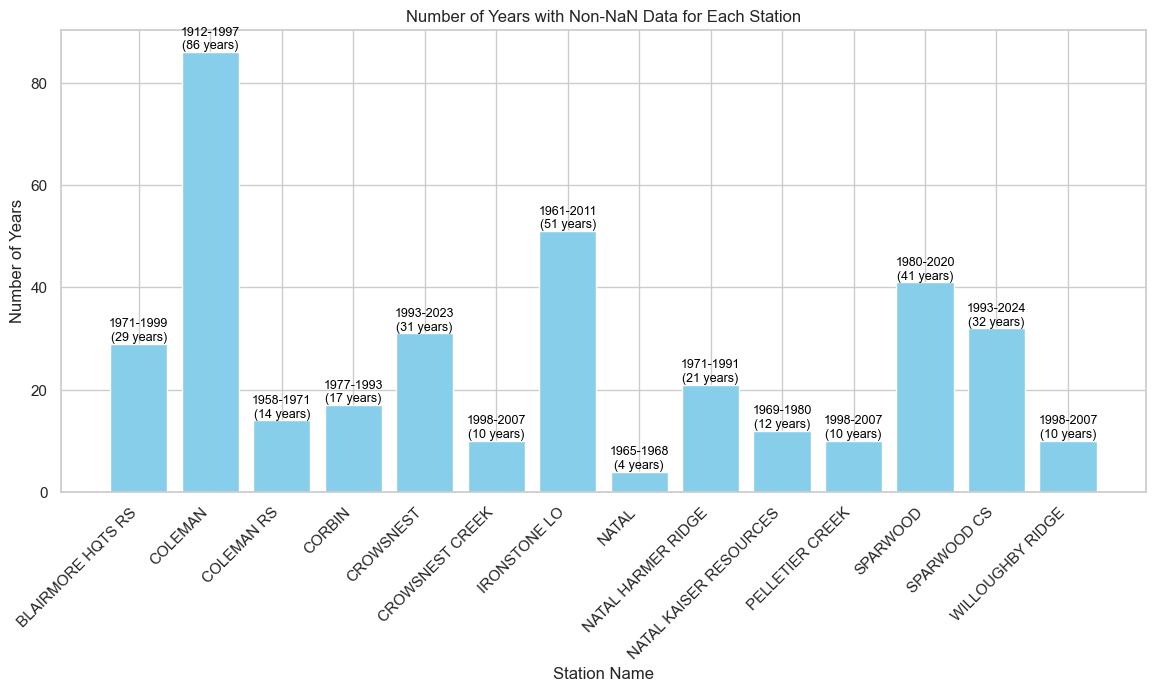

In [221]:
# Group by 'station_name' and get the range of years for each station
station_years_range = (
    weathercan_df.dropna(subset=['total_precip'])  # Exclude rows with NaN in 'total_precip'
    .groupby('station_name')['year']
    .agg(['min', 'max'])
)

# Calculate the number of years for each station
station_years_range['count'] = station_years_range['max'] - station_years_range['min'] + 1

# Plotting the histogram with the correct year range and station names
plt.figure(figsize=(14, 6))

# Plotting the bar chart
bar_plot = plt.bar(station_years_range.index, station_years_range['count'], color='skyblue')

# Adding text on top of each bar with the correct year range
for bar, min_year, max_year, count in zip(bar_plot, station_years_range['min'], station_years_range['max'], station_years_range['count']):
    end_year = min(max_year, weathercan_df['year'].max())  # Set the maximum year to the overall max year
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{min_year}-{end_year}\n({count} years)",
             ha='center', va='bottom', fontsize=9, color='black')

plt.title('Number of Years with Non-NaN Data for Each Station')
plt.xlabel('Station Name')
plt.ylabel('Number of Years')
plt.xticks(rotation=45, ha='right')
plt.show()

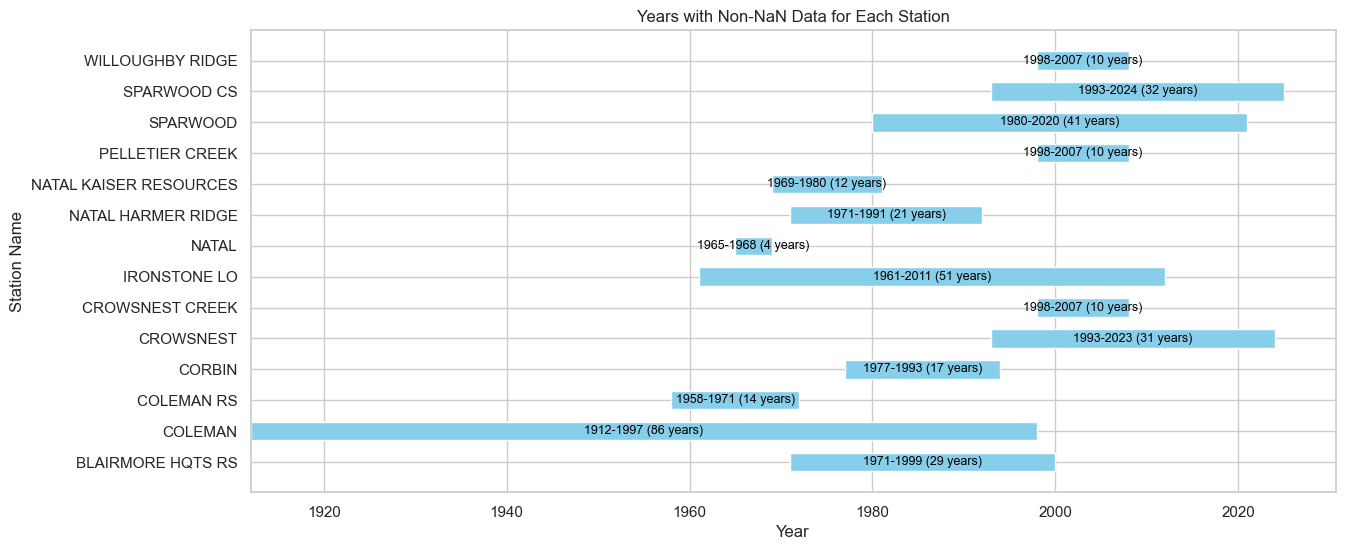

In [222]:

# Group by 'station_name' and get the range of years for each station
station_years_range = (
    weathercan_df.dropna(subset=['total_precip'])  # Exclude rows with NaN in 'total_precip'
    .groupby('station_name')['year']
    .agg(['min', 'max'])
)

# Calculate the number of years for each station
station_years_range['count'] = station_years_range['max'] - station_years_range['min'] + 1

# Plotting the horizontal bar chart
plt.figure(figsize=(14, 6))
bar_plot = plt.barh(station_years_range.index, station_years_range['count'], 
                   left=station_years_range['min'], color='skyblue', height=0.6)

# Adding concise text beside each bar with the correct year range
for bar, min_year, max_year, count in zip(bar_plot, station_years_range['min'], station_years_range['max'], station_years_range['count']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
             f"{min_year}-{max_year} ({count} years)", ha='center', va='center', fontsize=9, color='black')

plt.title('Years with Non-NaN Data for Each Station')
plt.xlabel('Year')
plt.ylabel('Station Name')
plt.show()


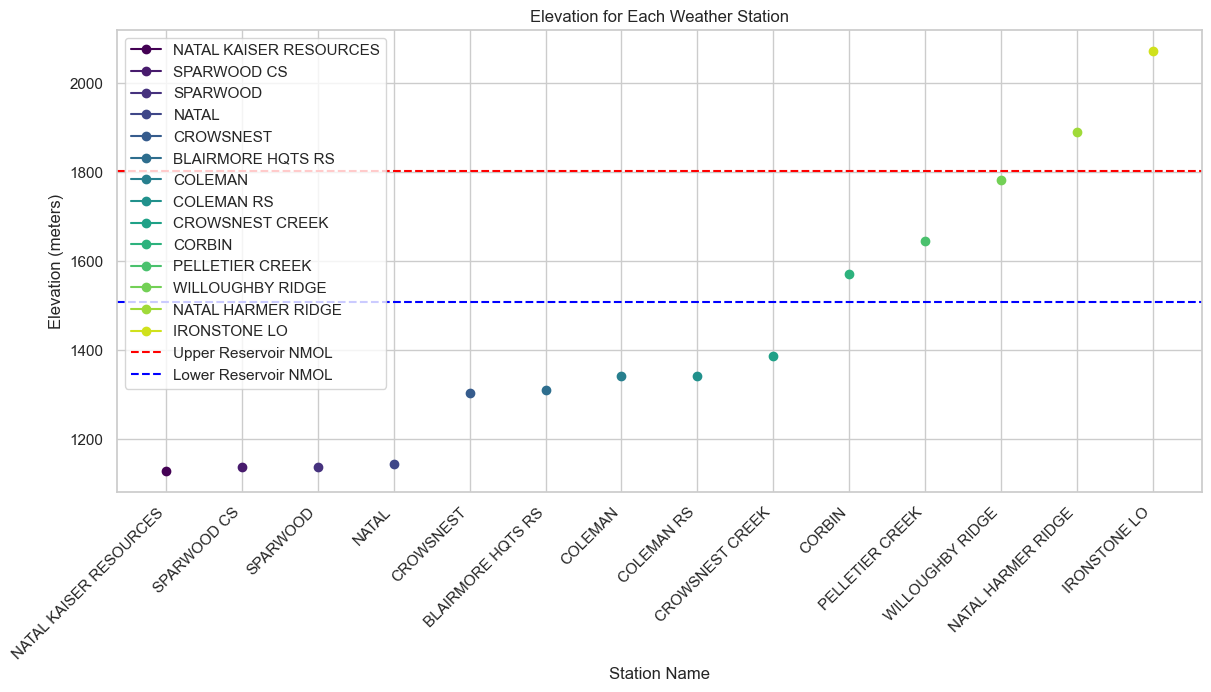

In [223]:
# Group by 'station_name' and get the mean elevation for each station
station_elevation = weathercan_df.groupby('station_name')['elev'].mean().reset_index()

# Sorting the data by elevation for better visualization
station_elevation = station_elevation.sort_values(by='elev')

# Elevation values for Upper and Lower Reservoir NMOL
upper_reservoir_elevation = 1803.3
lower_reservoir_elevation = 1509

# Plotting the line chart for station elevations with labels and different colors
plt.figure(figsize=(14, 6))
for i, (station, elevation) in enumerate(zip(station_elevation['station_name'], station_elevation['elev'])):
    plt.plot([i], [elevation], marker='o', linestyle='-', label=station, color=plt.cm.viridis(i / len(station_elevation)))

# Adding horizontal lines for Upper and Lower Reservoir NMOL elevations
plt.axhline(y=upper_reservoir_elevation, color='red', linestyle='--', label='Upper Reservoir NMOL')
plt.axhline(y=lower_reservoir_elevation, color='blue', linestyle='--', label='Lower Reservoir NMOL')

plt.title('Elevation for Each Weather Station')
plt.xlabel('Station Name')
plt.ylabel('Elevation (meters)')
plt.xticks(range(len(station_elevation)), station_elevation['station_name'], rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.show()

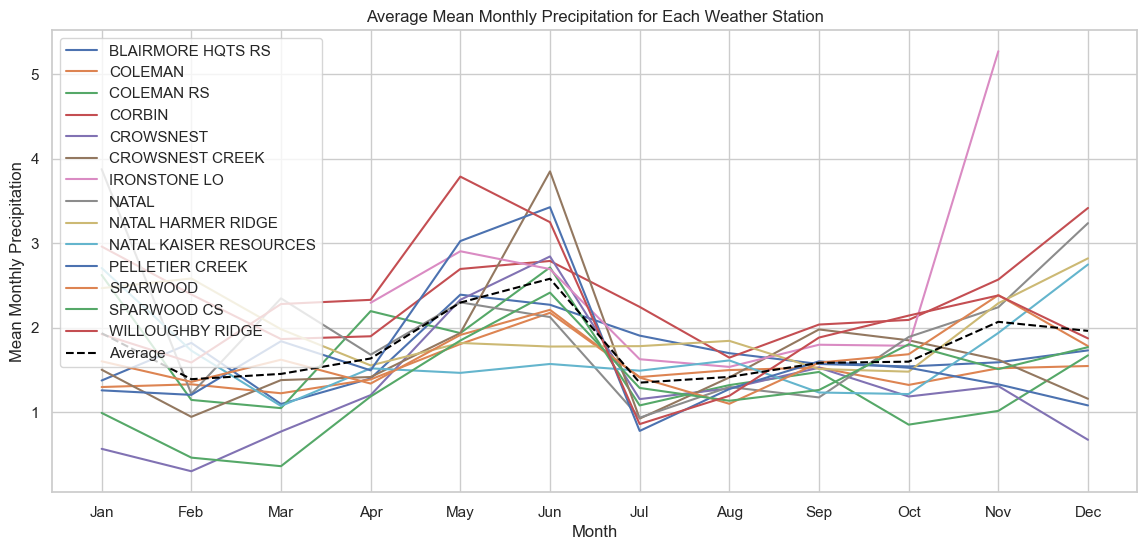

In [224]:
# Group by 'station_name', 'year', and 'month' and calculate the mean precipitation
mean_monthly_precip = (
    weathercan_df.groupby(['station_name', 'month'])['total_precip']
    .mean()
    .reset_index()
)

# Group by 'month' and calculate the average mean monthly precipitation for each station
average_monthly_precip = mean_monthly_precip.groupby('month')['total_precip'].mean().reset_index()

# Pivot the table to have each station as a line on the plot
station_monthly_precip = mean_monthly_precip.pivot(index='month', columns='station_name', values='total_precip')

# Plotting the line chart for average mean monthly precipitation for each station
plt.figure(figsize=(14, 6))
for station in station_monthly_precip.columns:
    plt.plot(station_monthly_precip.index, station_monthly_precip[station], label=station)

# Plotting the average mean monthly precipitation line
plt.plot(average_monthly_precip['month'], average_monthly_precip['total_precip'], linestyle='--', color='black', label='Average')

plt.title('Average Mean Monthly Precipitation for Each Weather Station')
plt.xlabel('Month')
plt.ylabel('Mean Monthly Precipitation')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True)
plt.show()

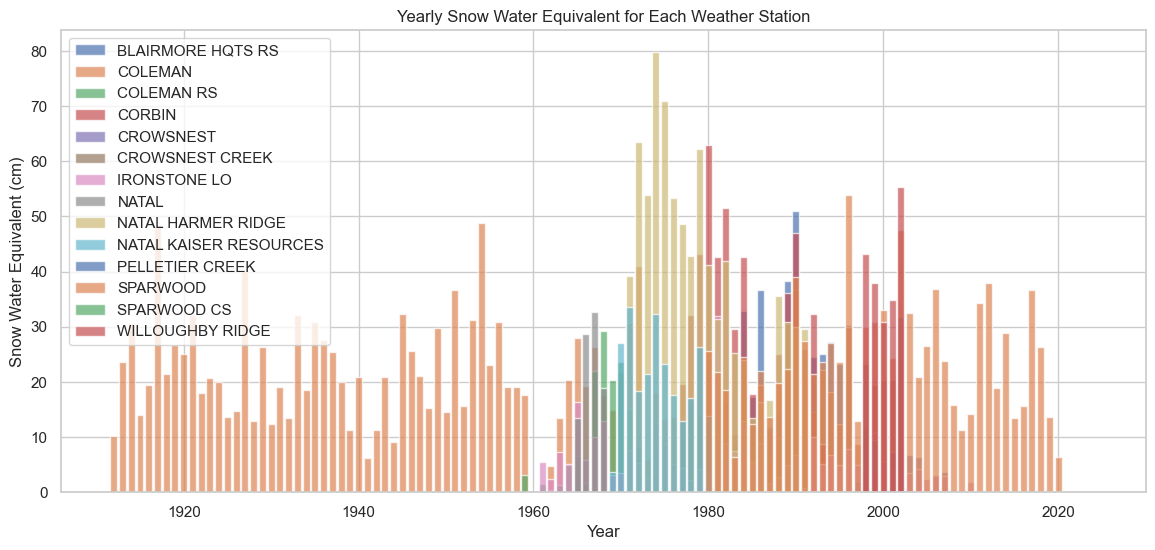

In [225]:
# Group by 'station_name' and 'year', then calculate the sum of snow water equivalent for each year and station
yearly_swe = weathercan_df.groupby(['station_name', 'year'])['swe'].sum().reset_index()

# Plotting the bar chart
plt.figure(figsize=(14, 6))
for station in yearly_swe['station_name'].unique():
    station_data = yearly_swe[yearly_swe['station_name'] == station]
    plt.bar(station_data['year'], station_data['swe'], label=station, alpha=0.7)

plt.title('Yearly Snow Water Equivalent for Each Weather Station')
plt.xlabel('Year')
plt.ylabel('Snow Water Equivalent (cm)')
plt.legend()
plt.show()

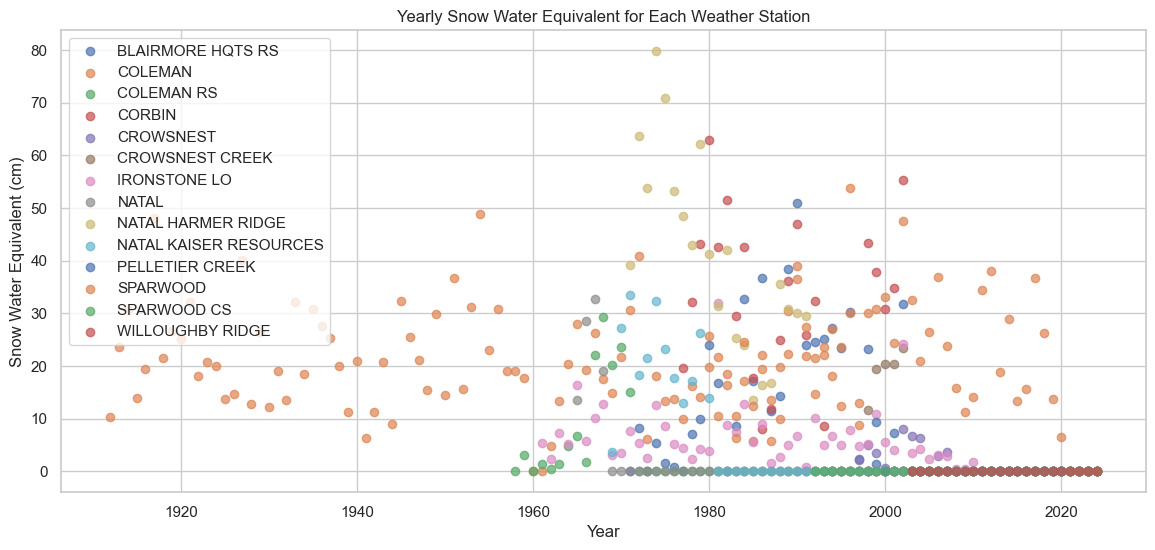

In [226]:
# Group by 'station_name' and 'year', then calculate the sum of snow water equivalent for each year and station
yearly_swe = weathercan_df.groupby(['station_name', 'year'])['swe'].sum().reset_index()

# Plotting the scatter plot
plt.figure(figsize=(14, 6))
for station in yearly_swe['station_name'].unique():
    station_data = yearly_swe[yearly_swe['station_name'] == station]
    plt.scatter(station_data['year'], station_data['swe'], label=station, alpha=0.7)

plt.title('Yearly Snow Water Equivalent for Each Weather Station')
plt.xlabel('Year')
plt.ylabel('Snow Water Equivalent (cm)')
plt.legend()
plt.grid(True)
plt.show()

### Gauge Station Visuals

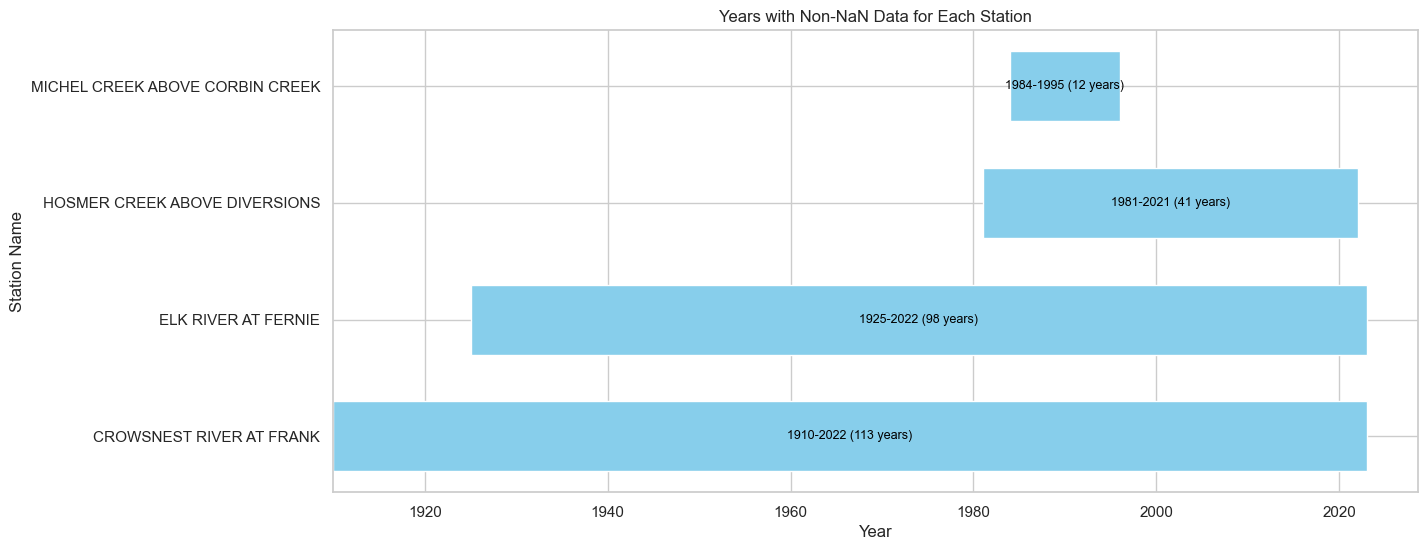

In [227]:
# Group by 'Station_name' and get the range of years for each station
station_years_range = (
    hydrometric_df.dropna(subset=['Date'])  # Exclude rows with NaN in 'Date'
    .groupby('Station_name')['Date']
    .agg(['min', 'max'])
)

# Calculate the number of years for each station
station_years_range['count'] = station_years_range['max'].dt.year - station_years_range['min'].dt.year + 1

# Plotting the horizontal bar chart
plt.figure(figsize=(14, 6))
bar_plot = plt.barh(station_years_range.index, station_years_range['count'], 
                   left=station_years_range['min'].dt.year, color='skyblue', height=0.6)

# Adding concise text beside each bar with the correct year range
for bar, min_year, max_year, count in zip(bar_plot, station_years_range['min'].dt.year, station_years_range['max'].dt.year, station_years_range['count']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
             f"{min_year}-{max_year} ({count} years)", ha='center', va='center', fontsize=9, color='black')

plt.title('Years with Non-NaN Data for Each Station')
plt.xlabel('Year')
plt.ylabel('Station Name')
plt.show()


In [228]:

# plot flows over time for each gauge (peak annual discharge vs drainage area)


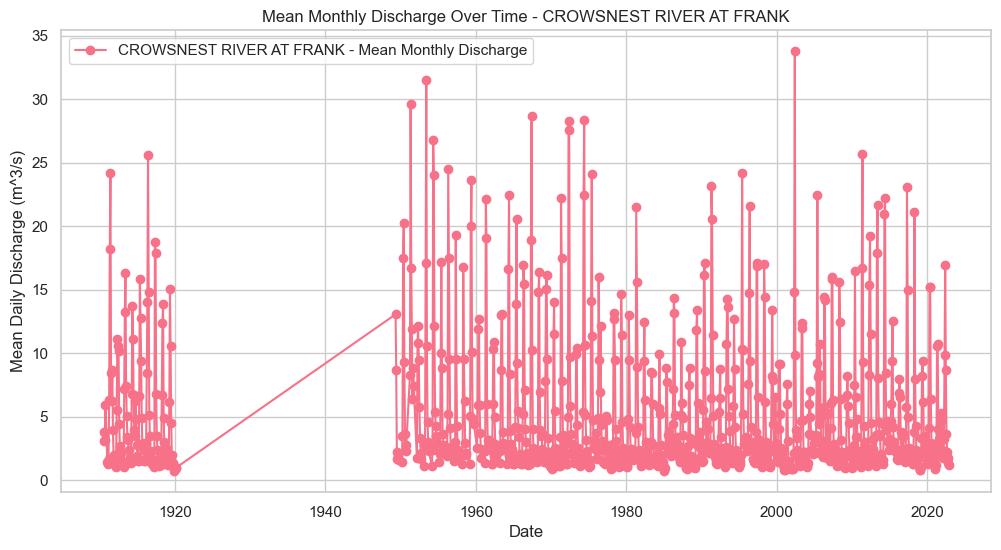

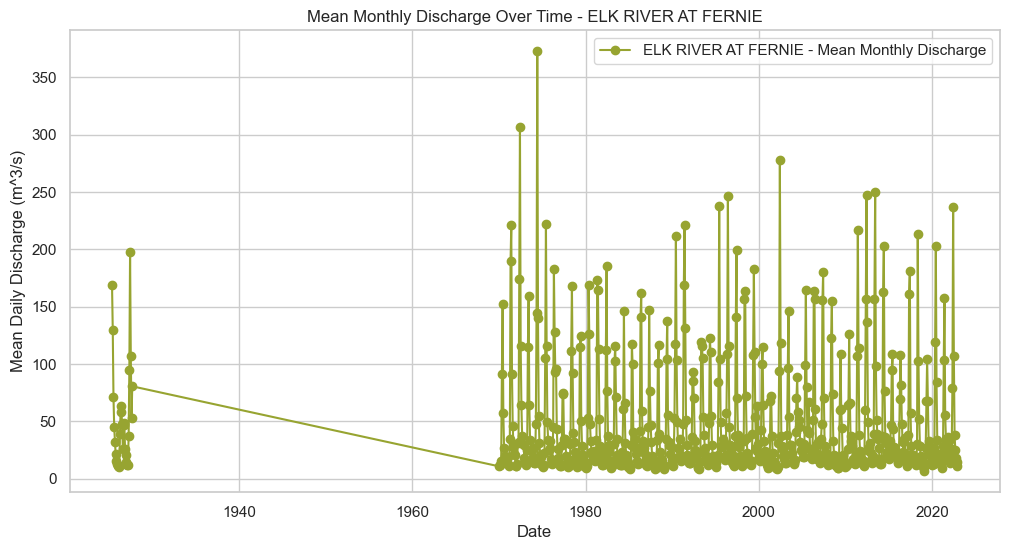

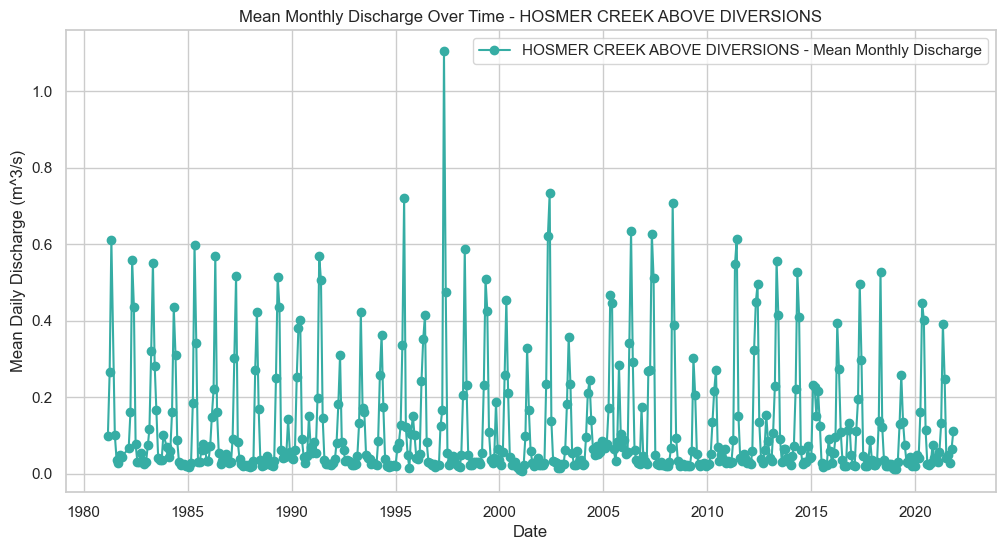

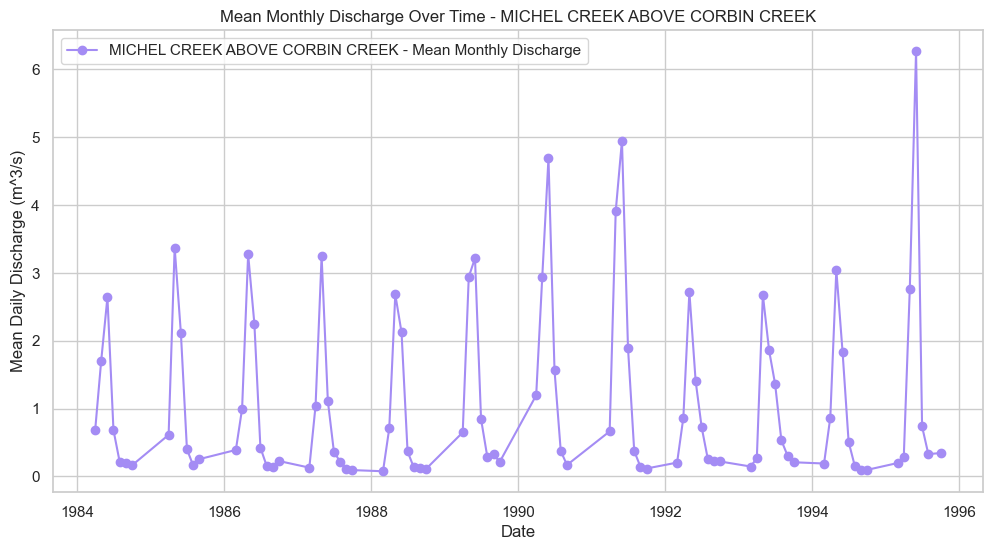

In [229]:
# Group by 'Station_name', 'Year', and 'Month', then calculate the mean monthly discharge
mean_monthly_discharge = hydrometric_df.groupby(['Station_name', 'Year', 'Month'])['Daily_Discharge_m3/s'].mean().reset_index()

# Create a new 'Date' column combining 'Year' and 'Month'
mean_monthly_discharge['Year_Month'] = pd.to_datetime(mean_monthly_discharge[['Year', 'Month']].assign(DAY=1))

# Create a color palette for each station
palette = sns.color_palette('husl', n_colors=len(mean_monthly_discharge['Station_name'].unique()))
station_color_dict = dict(zip(mean_monthly_discharge['Station_name'].unique(), palette))

# Loop through each station and create individual plots
stations = mean_monthly_discharge['Station_name'].unique()

for station in stations:
    station_data = mean_monthly_discharge[mean_monthly_discharge['Station_name'] == station]
    
    plt.figure(figsize=(12, 6))
    plt.plot(station_data['Year_Month'], station_data['Daily_Discharge_m3/s'], label=f'{station} - Mean Monthly Discharge', marker='o', color=station_color_dict[station])
    plt.title(f'Mean Monthly Discharge Over Time - {station}')
    plt.xlabel('Date')
    plt.ylabel('Mean Daily Discharge (m^3/s)')
    plt.legend()
    plt.show()

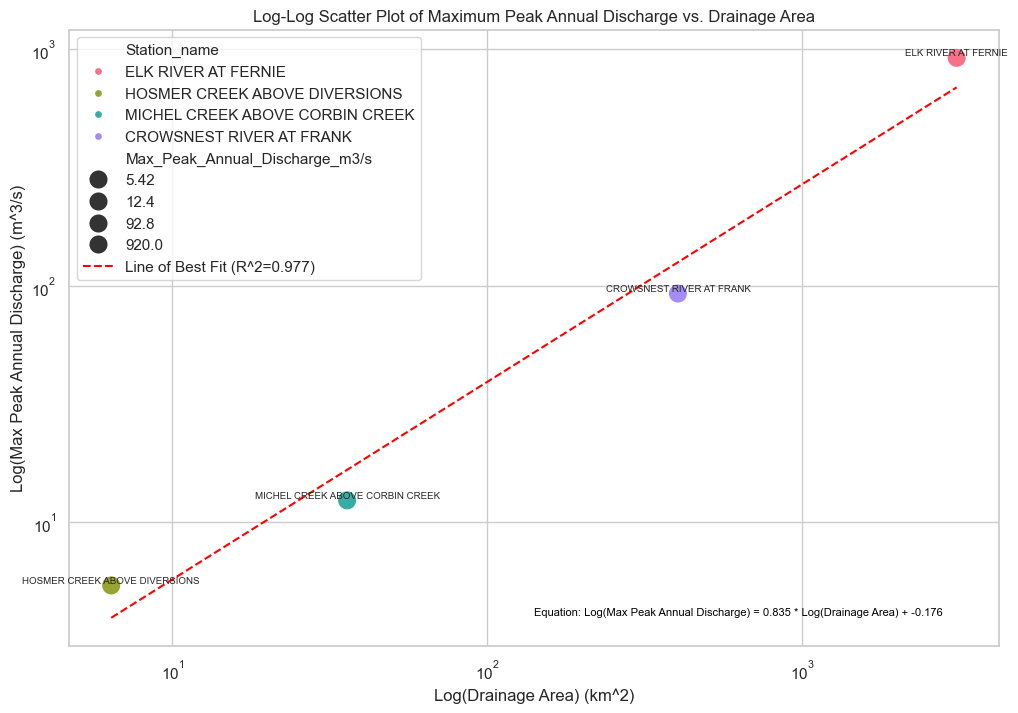

In [230]:
# Create a DataFrame with unique station information (including drainage area)
unique_station_info = hydrometric_df[['Station_name', 'gross_drainage_area_km2']].drop_duplicates()

# Merge unique station information with maximum peak annual discharge data
station_peak_area = pd.merge(unique_station_info, hydrometric_df.groupby('Station_name')['Max_Peak_Annual_Discharge_m3/s'].max().reset_index(), on='Station_name')

# Set up Seaborn style
sns.set(style="whitegrid")

# Plotting the log-log scatter plot
plt.figure(figsize=(12, 8))
scatter_plot = sns.scatterplot(
    x='gross_drainage_area_km2',
    y='Max_Peak_Annual_Discharge_m3/s',
    hue='Station_name',
    size='Max_Peak_Annual_Discharge_m3/s', 
    sizes=(200, 200),
    data=station_peak_area,
    palette=sns.color_palette("husl", n_colors=len(station_peak_area['Station_name'])),
    legend='full'
)
# Adding labels above the dots
for i, row in station_peak_area.iterrows():
    plt.text(row['gross_drainage_area_km2'], row['Max_Peak_Annual_Discharge_m3/s'], row['Station_name'],
             fontsize=7, ha='center', va='bottom')

# Adding labels and title
plt.title('Log-Log Scatter Plot of Maximum Peak Annual Discharge vs. Drainage Area')
plt.xlabel('Log(Drainage Area) (km^2)')
plt.ylabel('Log(Max Peak Annual Discharge) (m^3/s)')

# Setting log scale for both axes
plt.xscale('log')
plt.yscale('log')

# Adding a regression line
slope, intercept, r_value, p_value, std_err = linregress(np.log(station_peak_area['gross_drainage_area_km2']),
                                                          np.log(station_peak_area['Max_Peak_Annual_Discharge_m3/s']))

x_values = np.linspace(np.log(station_peak_area['gross_drainage_area_km2'].min()),
                       np.log(station_peak_area['gross_drainage_area_km2'].max()), 100)
y_values = slope * x_values + intercept

plt.plot(np.exp(x_values), np.exp(y_values), color='red', linestyle='--', label=f'Line of Best Fit (R^2={r_value**2:.3f})')

# Displaying the equation of the line
equation_label = f'Equation: Log(Max Peak Annual Discharge) = {slope:.3f} * Log(Drainage Area) + {intercept:.3f}'
plt.text(0.5, 0.05, equation_label, transform=scatter_plot.transAxes, fontsize=8, color='black')


# Displaying the legend
plt.legend()

# Displaying the plot
plt.show()

## Cross-Correlation of Weather Stations

In [231]:
# selected_columns = ['station_name', 'station_id', 'date', 'total_precip']
# weathercan_total_precip_df = weathercan_df[selected_columns].copy()

# weathercan_total_precip_df.to_csv('weathercan_total_precip.csv', index=False)

### Station Combinations of at least 5 years of overlapping daily data

In [287]:
combo1 = ['IRONSTONE LO', 'COLEMAN RS', 'COLEMAN'] # 1242
combo2 = ['NATAL KAISER RESOURCES', 'NATAL HARMER RIDGE', 'IRONSTONE LO', 'COLEMAN', 'BLAIRMORE HQTS RS'] # 896
combo3 = ['NATAL HARMER RIDGE', 'IRONSTONE LO', 'CROWSNEST', 'COLEMAN', 'BLAIRMORE HQTS RS'] # 0
combo4 = ['WILLOUGHBY RIDGE', 'SPARWOOD CS', 'SPARWOOD', 'PELLETIER CREEK', 'IRONSTONE LO', 'CROWSNEST CREEK', 'CROWSNEST'] # 85

combo5 = ['COLEMAN', 'BLAIRMORE HQTS RS'] # 6927
combo6 = ['COLEMAN', 'IRONSTONE LO'] # 4978
combo7 = ['IRONSTONE LO', 'CROWSNEST'] # 1613
combo8 = ['IRONSTONE LO', 'NATAL HARMER RIDGE'] # 2661
combo9 = ['SPARWOOD CS', 'SPARWOOD'] # 3802
combo10 = ['WILLOUGHBY RIDGE', 'SPARWOOD'] # 2713
combo11 = ['COLEMAN', 'IRONSTONE LO'] # 4978
combo12 = ['NATAL HARMER RIDGE', 'NATAL KAISER RESOURCES'] # 3135
combo13 = ['IRONSTONE LO', 'BLAIRMORE HQTS RS'] # 3381

combo14 = ['COLEMAN', 'BLAIRMORE HQTS RS', 'CORBIN', 'IRONSTONE LO'] # 2114
combo15 = ['COLEMAN', 'BLAIRMORE HQTS RS', 'CORBIN', 'IRONSTONE LO', 'NATAL HARMER RIDGE'] # 1664

In [233]:
combo1_df = extract_and_transform(combo1, weathercan_df)
combo1_df.head()

station_name       date  COLEMAN  COLEMAN RS  IRONSTONE LO
0            1962-05-15      3.0         4.1           2.5
1            1962-05-16      0.0         0.0           0.0
2            1962-05-17      0.0         0.0           0.0
3            1962-05-18     10.9        15.0          12.7
4            1962-05-19      3.8         4.3           4.1

In [234]:
combo1_df.describe(include='all') # not enough data

station_name                           date      COLEMAN   COLEMAN RS  \
count                                  1242  1242.000000  1242.000000   
mean          1966-07-04 16:25:30.434782608     1.727697     1.687198   
min                     1962-05-15 00:00:00     0.000000     0.000000   
25%                     1964-06-28 06:00:00     0.000000     0.000000   
50%                     1966-07-22 12:00:00     0.000000     0.000000   
75%                     1968-08-02 18:00:00     1.000000     0.800000   
max                     1970-09-16 00:00:00    52.300000    53.600000   
std                                     NaN     4.544865     4.690875   

station_name  IRONSTONE LO  
count          1242.000000  
mean              2.117311  
min               0.000000  
25%               0.000000  
50%               0.000000  
75%               1.300000  
max              58.400000  
std               5.336761

In [235]:
nan_check = combo1_df.isna().any()
nan_check[nan_check].index.tolist()
combo1_df.isna().sum()

station_name
date            0
COLEMAN         0
COLEMAN RS      0
IRONSTONE LO    0
dtype: int64

In [236]:
combo2_df = extract_and_transform(combo2, weathercan_df)
combo2_df.head()

station_name       date  BLAIRMORE HQTS RS  COLEMAN  IRONSTONE LO  \
0            1971-07-27               12.2     14.5           8.6   
1            1971-07-28                0.0      0.0           3.3   
2            1971-07-29                0.0      0.0           0.0   
3            1971-07-30                0.0      0.0           0.0   
4            1971-07-31                0.0      0.0           0.0   

station_name  NATAL HARMER RIDGE  NATAL KAISER RESOURCES  
0                            6.9                     7.6  
1                            0.0                     0.0  
2                            0.0                     0.0  
3                            0.0                     0.0  
4                            0.0                     0.0

In [237]:
combo2_df.describe()

station_name                           date  BLAIRMORE HQTS RS     COLEMAN  \
count                                   896         896.000000  896.000000   
mean          1976-08-22 06:30:32.142857152           1.886161    1.853683   
min                     1971-07-27 00:00:00           0.000000    0.000000   
25%                     1975-07-01 18:00:00           0.000000    0.000000   
50%                     1976-08-26 12:00:00           0.000000    0.000000   
75%                     1978-08-14 06:00:00           1.200000    1.000000   
max                     1979-10-23 00:00:00          54.400000   63.000000   
std                                     NaN           5.190796    4.978424   

station_name  IRONSTONE LO  NATAL HARMER RIDGE  NATAL KAISER RESOURCES  
count           896.000000          896.000000              896.000000  
mean              2.259487            1.820759                1.643973  
min               0.000000            0.000000                0.000000  
25%               0.000000            0.000000                0.000000  
50%               0.000000            0.000000                0.000000  
75%               1.600000            1.800000                1.000000  
max              49.700000           53.300000               37.600000  
std               5.401961            4.358673                3.849987

In [238]:
nan_check = combo2_df.isna().any()
nan_check[nan_check].index.tolist()
combo2_df.isna().sum()

station_name
date                      0
BLAIRMORE HQTS RS         0
COLEMAN                   0
IRONSTONE LO              0
NATAL HARMER RIDGE        0
NATAL KAISER RESOURCES    0
dtype: int64

In [239]:
combo3_df = extract_and_transform(combo3, weathercan_df)
combo3_df.head()

Empty DataFrame
Columns: [date, BLAIRMORE HQTS RS, COLEMAN, CROWSNEST, IRONSTONE LO, NATAL HARMER RIDGE]
Index: []

In [240]:
combo3_df.describe()

station_name date  BLAIRMORE HQTS RS  COLEMAN  CROWSNEST  IRONSTONE LO  \
count           0                0.0      0.0        0.0           0.0   
mean          NaT                NaN      NaN        NaN           NaN   
min           NaT                NaN      NaN        NaN           NaN   
25%           NaT                NaN      NaN        NaN           NaN   
50%           NaT                NaN      NaN        NaN           NaN   
75%           NaT                NaN      NaN        NaN           NaN   
max           NaT                NaN      NaN        NaN           NaN   
std           NaN                NaN      NaN        NaN           NaN   

station_name  NATAL HARMER RIDGE  
count                        0.0  
mean                         NaN  
min                          NaN  
25%                          NaN  
50%                          NaN  
75%                          NaN  
max                          NaN  
std                          NaN

In [241]:
nan_check = combo3_df.isna().any()
nan_check[nan_check].index.tolist()
combo3_df.isna().sum()

station_name
date                  0
BLAIRMORE HQTS RS     0
COLEMAN               0
CROWSNEST             0
IRONSTONE LO          0
NATAL HARMER RIDGE    0
dtype: int64

In [242]:
combo4_df = extract_and_transform(combo4, weathercan_df)
combo4_df.head()

station_name       date  CROWSNEST  CROWSNEST CREEK  IRONSTONE LO  \
0            2003-09-01        0.0              0.0           0.0   
1            2003-09-02        0.0              0.0           0.0   
2            2003-09-03        0.0              0.0           0.0   
3            2003-09-04        0.0              0.0           0.0   
4            2003-09-05        0.0              0.0           0.0   

station_name  PELLETIER CREEK  SPARWOOD  SPARWOOD CS  WILLOUGHBY RIDGE  
0                         0.0       0.0          0.0               0.0  
1                         0.0       0.0          0.0               0.0  
2                         0.0       0.0          0.0               0.0  
3                         0.0       0.0          0.0               0.0  
4                         0.0       0.0          0.0               0.0

In [243]:
combo4_df.describe()

station_name                           date  CROWSNEST  CROWSNEST CREEK  \
count                                    85  85.000000        85.000000   
mean          2004-03-15 00:16:56.470588288   1.649412         2.183529   
min                     2003-09-01 00:00:00   0.000000         0.000000   
25%                     2003-09-23 00:00:00   0.000000         0.000000   
50%                     2004-05-31 00:00:00   0.000000         0.500000   
75%                     2004-06-21 00:00:00   1.600000         2.000000   
max                     2004-07-24 00:00:00  17.800000        38.200000   
std                                     NaN   3.394029         4.903032   

station_name  IRONSTONE LO  PELLETIER CREEK   SPARWOOD  SPARWOOD CS  \
count            85.000000        85.000000  85.000000    85.000000   
mean              1.941176         1.930588   1.795294     1.628235   
min               0.000000         0.000000   0.000000     0.000000   
25%               0.000000         0.000000   0.000000     0.000000   
50%               0.000000         0.800000   0.000000     0.000000   
75%               1.800000         2.000000   2.400000     2.400000   
max              14.400000        19.600000  14.900000    13.000000   
std               3.503851         3.335096   3.195194     2.961041   

station_name  WILLOUGHBY RIDGE  
count                85.000000  
mean                  2.821176  
min                   0.000000  
25%                   0.000000  
50%                   0.500000  
75%                   3.300000  
max                  31.800000  
std                   5.500521

In [244]:
nan_check = combo4_df.isna().any()
nan_check[nan_check].index.tolist()
combo4_df.isna().sum()

station_name
date                0
CROWSNEST           0
CROWSNEST CREEK     0
IRONSTONE LO        0
PELLETIER CREEK     0
SPARWOOD            0
SPARWOOD CS         0
WILLOUGHBY RIDGE    0
dtype: int64

In [245]:
combo5_df = extract_and_transform(combo5, weathercan_df)
combo5_df.describe()

station_name                           date  BLAIRMORE HQTS RS      COLEMAN
count                                  6927        6927.000000  6927.000000
mean          1986-09-24 23:32:08.627111360           1.741706     1.652057
min                     1971-06-01 00:00:00           0.000000     0.000000
25%                     1981-06-07 12:00:00           0.000000     0.000000
50%                     1987-03-08 00:00:00           0.000000     0.000000
75%                     1992-01-30 12:00:00           1.000000     1.200000
max                     1997-09-30 00:00:00          79.000000    63.000000
std                                     NaN           4.848114     4.160507

In [246]:
combo6_df = extract_and_transform(combo6, weathercan_df)
combo6_df.describe()

station_name                           date      COLEMAN  IRONSTONE LO
count                                  4978  4978.000000   4978.000000
mean          1979-07-25 07:24:02.024909568     1.800964      2.118200
min                     1962-05-15 00:00:00     0.000000      0.000000
25%                     1971-05-18 06:00:00     0.000000      0.000000
50%                     1979-07-31 12:00:00     0.000000      0.000000
75%                     1987-07-23 18:00:00     1.300000      1.500000
max                     1997-09-17 00:00:00    63.000000     75.800000
std                                     NaN     4.481894      5.413542

In [247]:
combo7_df = extract_and_transform(combo7, weathercan_df)
combo7_df.describe()

station_name                           date    CROWSNEST  IRONSTONE LO
count                                  1613  1613.000000   1613.000000
mean          2001-11-03 02:40:41.661500160     1.775077      1.916243
min                     1993-06-07 00:00:00     0.000000      0.000000
25%                     1998-07-23 00:00:00     0.000000      0.000000
50%                     2001-07-15 00:00:00     0.000000      0.000000
75%                     2005-07-16 00:00:00     0.800000      1.400000
max                     2011-08-23 00:00:00    97.600000     69.000000
std                                     NaN     5.469407      5.123009

In [248]:
combo8_df = extract_and_transform(combo8, weathercan_df)
combo8_df.describe()

station_name                           date  IRONSTONE LO  NATAL HARMER RIDGE
count                                  2661   2661.000000         2661.000000
mean          1980-12-18 15:38:21.240135360      2.048628            1.719579
min                     1971-07-27 00:00:00      0.000000            0.000000
25%                     1976-06-09 00:00:00      0.000000            0.000000
50%                     1980-07-11 00:00:00      0.000000            0.000000
75%                     1985-06-21 00:00:00      1.500000            1.500000
max                     1991-06-30 00:00:00     75.800000           53.300000
std                                     NaN      5.445845            4.035978

In [249]:
combo9_df = extract_and_transform(combo9, weathercan_df)
combo9_df.describe()

station_name                           date     SPARWOOD  SPARWOOD CS
count                                  3802  3802.000000  3802.000000
mean          2006-12-16 00:06:03.598106112     1.717359     1.495029
min                     1993-04-01 00:00:00     0.000000     0.000000
25%                     1997-10-14 06:00:00     0.000000     0.000000
50%                     2007-03-24 12:00:00     0.000000     0.000000
75%                     2014-03-18 18:00:00     1.600000     1.200000
max                     2019-08-20 00:00:00    81.800000    63.000000
std                                     NaN     4.149916     3.778485

In [250]:
combo10_df = extract_and_transform(combo10, weathercan_df)
combo10_df.describe()

station_name                           date     SPARWOOD  WILLOUGHBY RIDGE
count                                  2713  2713.000000       2713.000000
mean          2002-07-21 04:16:21.938813184     1.769738          2.137339
min                     1998-04-01 00:00:00     0.000000          0.000000
25%                     2000-04-22 00:00:00     0.000000          0.000000
50%                     2002-06-02 00:00:00     0.000000          0.000000
75%                     2004-05-11 00:00:00     1.600000          1.500000
max                     2007-11-29 00:00:00    49.100000        103.000000
std                                     NaN     4.130047          5.848723

In [251]:
combo11_df = extract_and_transform(combo11, weathercan_df)
combo11_df.describe()

station_name                           date      COLEMAN  IRONSTONE LO
count                                  4978  4978.000000   4978.000000
mean          1979-07-25 07:24:02.024909568     1.800964      2.118200
min                     1962-05-15 00:00:00     0.000000      0.000000
25%                     1971-05-18 06:00:00     0.000000      0.000000
50%                     1979-07-31 12:00:00     0.000000      0.000000
75%                     1987-07-23 18:00:00     1.300000      1.500000
max                     1997-09-17 00:00:00    63.000000     75.800000
std                                     NaN     4.481894      5.413542

In [252]:
combo12_df = extract_and_transform(combo12, weathercan_df)
combo12_df.describe()

station_name                           date  NATAL HARMER RIDGE  \
count                                  3135         3135.000000   
mean          1975-12-14 09:47:01.435406688            2.263828   
min                     1971-07-27 00:00:00            0.000000   
25%                     1973-10-23 12:00:00            0.000000   
50%                     1975-12-16 00:00:00            0.000000   
75%                     1978-02-06 12:00:00            2.500000   
max                     1980-03-31 00:00:00           53.300000   
std                                     NaN            4.883264   

station_name  NATAL KAISER RESOURCES  
count                    3135.000000  
mean                        1.713652  
min                         0.000000  
25%                         0.000000  
50%                         0.000000  
75%                         1.100000  
max                        49.000000  
std                         4.219612

In [253]:
combo13_df = extract_and_transform(combo13, weathercan_df)
combo13_df.describe()

station_name                           date  BLAIRMORE HQTS RS  IRONSTONE LO
count                                  3381        3381.000000   3381.000000
mean          1985-06-20 06:28:00.212954752           1.914877      2.154540
min                     1971-06-01 00:00:00           0.000000      0.000000
25%                     1979-07-09 00:00:00           0.000000      0.000000
50%                     1984-08-31 00:00:00           0.000000      0.000000
75%                     1991-07-19 00:00:00           1.100000      1.600000
max                     1999-09-30 00:00:00          79.000000     75.800000
std                                     NaN           5.394196      5.506283

In [290]:
combo14_df = extract_and_transform(combo14, weathercan_df)
combo14_df.describe()

station_name                           date  BLAIRMORE HQTS RS      COLEMAN  \
count                                  2114        2114.000000  2114.000000   
mean          1985-01-04 22:37:34.683065280           1.821003     1.822422   
min                     1977-06-01 00:00:00           0.000000     0.000000   
25%                     1980-10-15 06:00:00           0.000000     0.000000   
50%                     1984-07-27 12:00:00           0.000000     0.000000   
75%                     1988-08-29 18:00:00           1.200000     1.500000   
max                     1993-07-14 00:00:00          58.000000    39.400000   
std                                     NaN           4.834135     4.257812   

station_name       CORBIN  IRONSTONE LO  
count         2114.000000   2114.000000  
mean             2.204541      2.081457  
min              0.000000      0.000000  
25%              0.000000      0.000000  
50%              0.000000      0.000000  
75%              1.300000      1.500000  
max             83.000000     75.800000  
std              5.708479      5.517317

In [288]:
combo15_df = extract_and_transform(combo15, weathercan_df)
combo15_df.describe()

station_name                           date  BLAIRMORE HQTS RS      COLEMAN  \
count                                  1664        1664.000000  1664.000000   
mean          1983-12-15 14:21:55.384615360           1.696935     1.746995   
min                     1977-06-01 00:00:00           0.000000     0.000000   
25%                     1980-06-24 18:00:00           0.000000     0.000000   
50%                     1983-05-12 12:00:00           0.000000     0.000000   
75%                     1987-08-23 06:00:00           1.100000     1.300000   
max                     1991-06-30 00:00:00          58.000000    39.400000   
std                                     NaN           4.549737     4.242338   

station_name       CORBIN  IRONSTONE LO  NATAL HARMER RIDGE  
count         1664.000000   1664.000000         1664.000000  
mean             2.102764      2.017969            1.657692  
min              0.000000      0.000000            0.000000  
25%              0.000000      0.000000            0.000000  
50%              0.000000      0.000000            0.000000  
75%              1.200000      1.400000            1.400000  
max             83.000000     75.800000           34.600000  
std              5.536894      5.672185            3.819095

### Cross-Correlation Matrices

In [291]:
c1_monthly_dataframes = create_monthly_dataframes(combo1_df)
c2_monthly_dataframes = create_monthly_dataframes(combo2_df)
c3_monthly_dataframes = create_monthly_dataframes(combo3_df)
c4_monthly_dataframes = create_monthly_dataframes(combo4_df)
c5_monthly_dataframes = create_monthly_dataframes(combo5_df)
c6_monthly_dataframes = create_monthly_dataframes(combo6_df)
c7_monthly_dataframes = create_monthly_dataframes(combo7_df)
c8_monthly_dataframes = create_monthly_dataframes(combo8_df)
c9_monthly_dataframes = create_monthly_dataframes(combo9_df)
c10_monthly_dataframes = create_monthly_dataframes(combo10_df)
c11_monthly_dataframes = create_monthly_dataframes(combo11_df)
c12_monthly_dataframes = create_monthly_dataframes(combo12_df)
c13_monthly_dataframes = create_monthly_dataframes(combo13_df)
c14_monthly_dataframes = create_monthly_dataframes(combo14_df)
c15_monthly_dataframes = create_monthly_dataframes(combo15_df)


In [255]:
# for month, month_df in monthly_dataframes.items():
#     print(f"Month: {month}")
#     print(month_df)
#     print("------------------")

#### Combination 1 
['IRONSTONE LO', 'COLEMAN RS', 'COLEMAN'] 1242 count

In [256]:
summary_combo1_monthly_df = describe_dataframes_to_dataframe(c1_monthly_dataframes)
summary_combo1_monthly_df

count       mean       std   min     25%    50%     75%   max
   station_name                                                               
5  COLEMAN        57.0   3.205263  6.909916   0.0   0.000   0.00   3.300  36.3
   COLEMAN RS     57.0   2.692982  5.894303   0.0   0.000   0.00   3.000  27.4
   IRONSTONE LO   57.0   2.607018  4.707853   0.0   0.000   0.00   3.300  18.3
   month          57.0   5.000000  0.000000   5.0   5.000   5.00   5.000   5.0
6  COLEMAN       269.0   2.937175  6.676738   0.0   0.000   0.00   2.500  52.3
   COLEMAN RS    269.0   3.178439  7.085637   0.0   0.000   0.00   2.300  53.6
   IRONSTONE LO  269.0   3.602230  8.001184   0.0   0.000   0.00   3.600  58.4
   month         269.0   6.000000  0.000000   6.0   6.000   6.00   6.000   6.0
7  COLEMAN       279.0   1.200000  3.467060   0.0   0.000   0.00   0.000  27.2
   COLEMAN RS    279.0   0.956631  2.892377   0.0   0.000   0.00   0.000  22.1
   IRONSTONE LO  279.0   1.207168  3.149823   0.0   0.000   0.00   0.300  22.6
   month         279.0   7.000000  0.000000   7.0   7.000   7.00   7.000   7.0
8  COLEMAN       279.0   1.165591  3.584805   0.0   0.000   0.00   0.000  26.2
   COLEMAN RS    279.0   1.132616  4.017172   0.0   0.000   0.00   0.000  39.1
   IRONSTONE LO  279.0   1.371685  3.997034   0.0   0.000   0.00   0.150  32.5
   month         279.0   8.000000  0.000000   8.0   8.000   8.00   8.000   8.0
9  COLEMAN       254.0   1.393701  3.090333   0.0   0.000   0.00   1.000  17.5
   COLEMAN RS    254.0   1.397244  3.387170   0.0   0.000   0.00   0.500  20.6
   IRONSTONE LO  254.0   2.111811  4.730117   0.0   0.000   0.00   1.300  27.9
   month         254.0   9.000000  0.000000   9.0   9.000   9.00   9.000   9.0
10 COLEMAN       100.0   1.405000  2.939023   0.0   0.000   0.00   1.500  15.5
   COLEMAN RS    100.0   1.425000  3.572294   0.0   0.000   0.00   1.075  26.9
   IRONSTONE LO  100.0   2.351000  5.498659   0.0   0.000   0.00   1.575  40.6
   month         100.0  10.000000  0.000000  10.0  10.000  10.00  10.000  10.0
11 COLEMAN         4.0   4.625000  4.871943   0.0   0.750   4.30   8.175   9.9
   COLEMAN RS      4.0   1.675000  1.795132   0.0   0.225   1.55   3.000   3.6
   IRONSTONE LO    4.0   5.275000  4.275024   0.0   2.700   6.10   8.675   8.9
   month           4.0  11.000000  0.000000  11.0  11.000  11.00  11.000  11.0

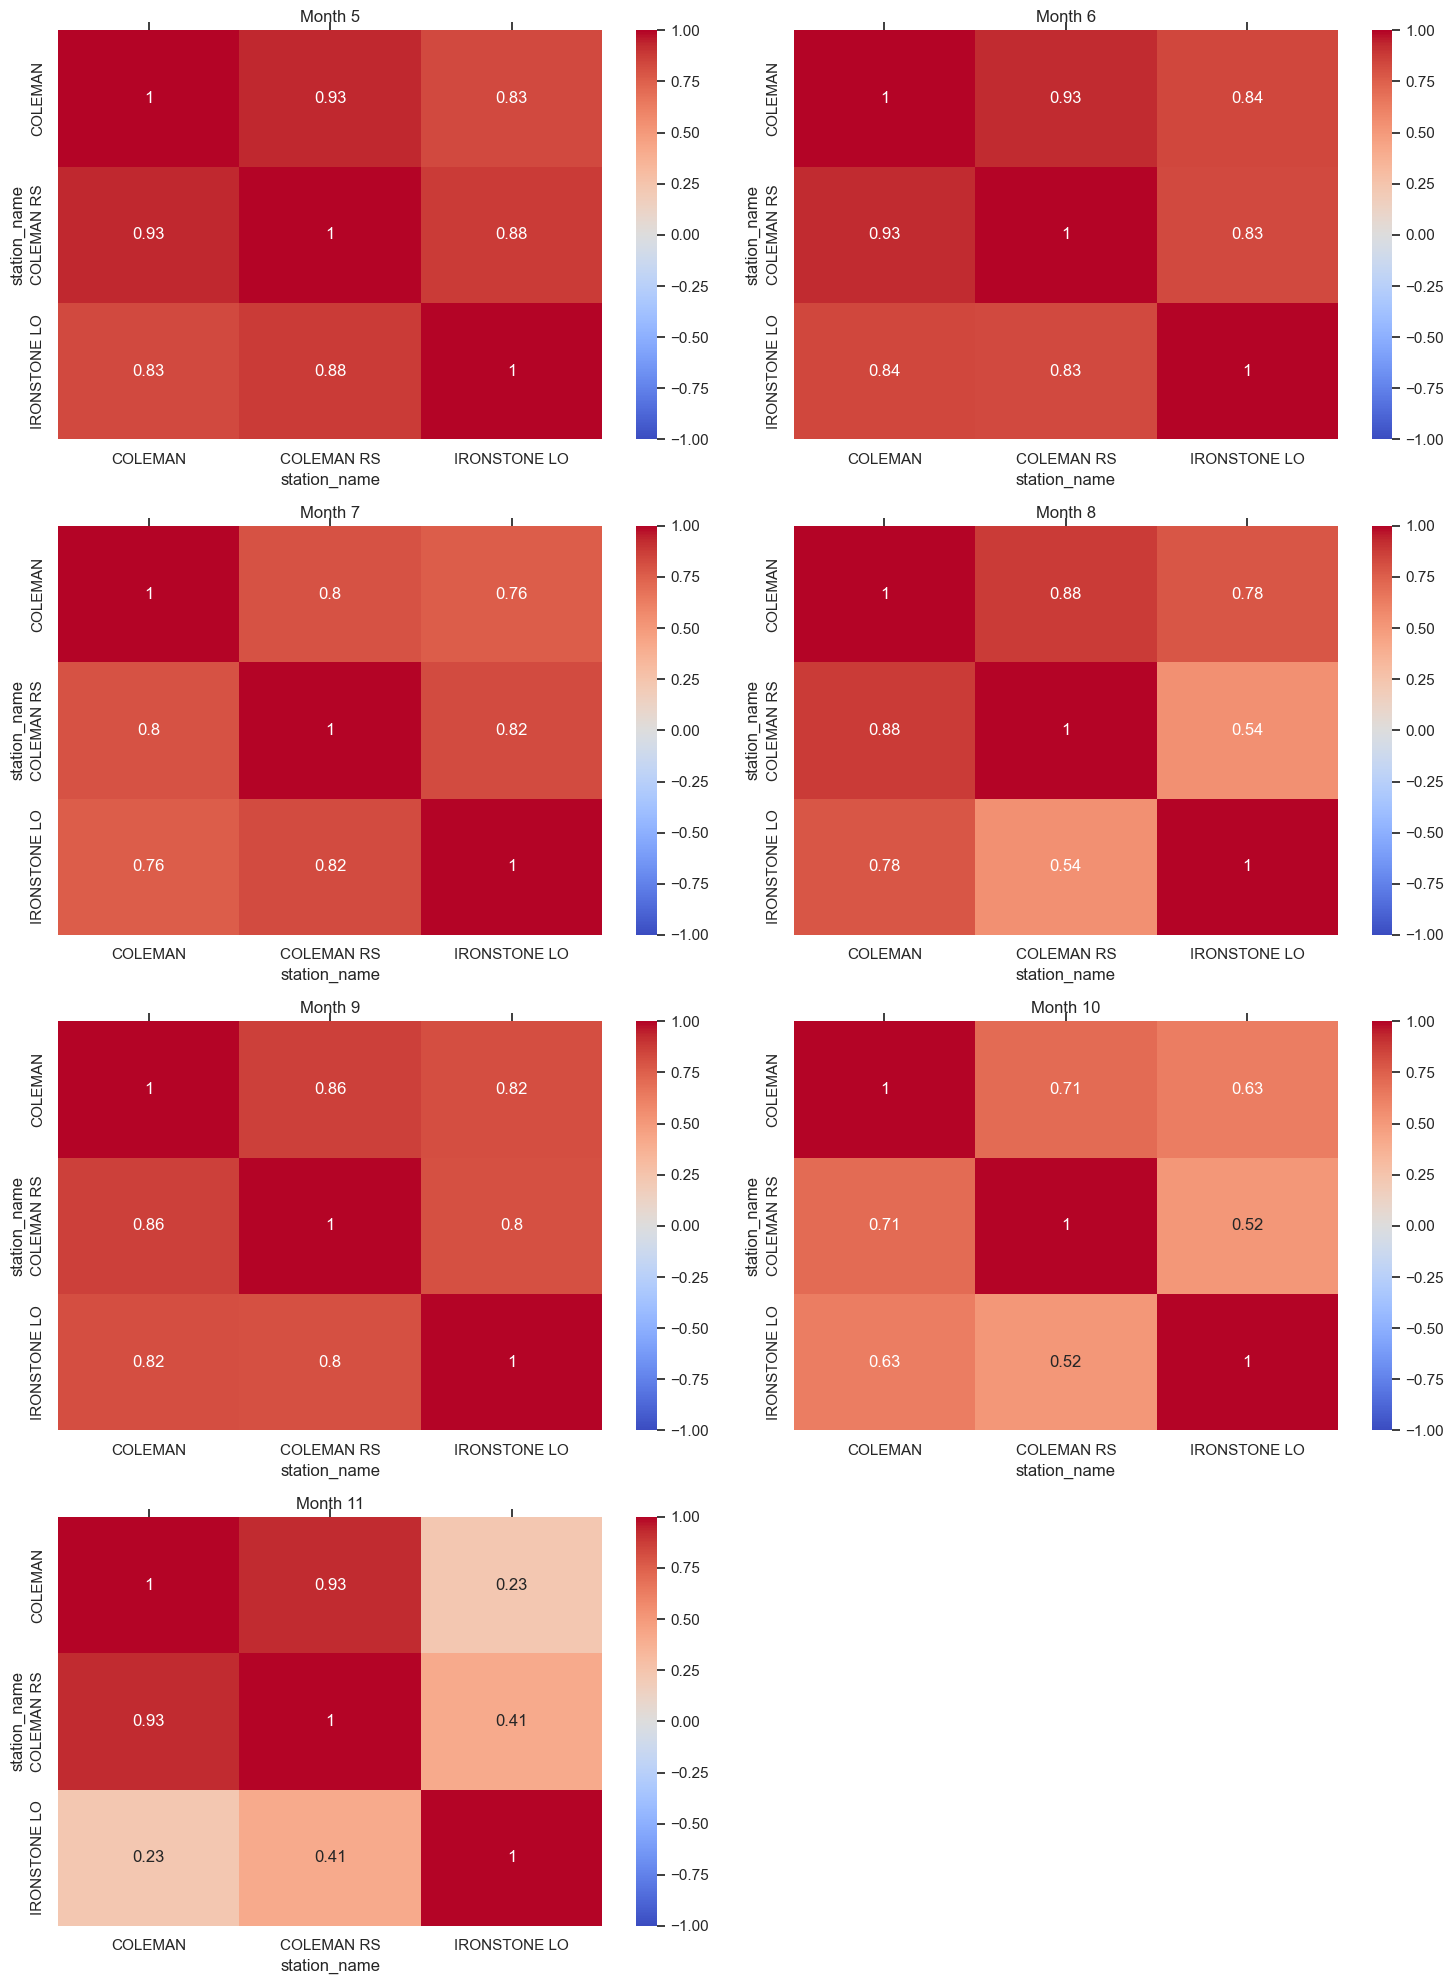

In [257]:
plot_cross_correlation_matrices(c1_monthly_dataframes)

#### Combination 2 
combo2 = ['NATAL KAISER RESOURCES', 'NATAL HARMER RIDGE', 'IRONSTONE LO', 'COLEMAN', 'BLAIRMORE HQTS RS'] 896 count

In [258]:
summary_combo2_monthly_df = describe_dataframes_to_dataframe(c2_monthly_dataframes)
summary_combo2_monthly_df

count       mean       std   min   25%   50%  \
   station_name                                                           
4  BLAIRMORE HQTS RS         4.0   4.750000  9.500000   0.0   0.0   0.0   
   COLEMAN                   4.0   0.900000  1.800000   0.0   0.0   0.0   
   IRONSTONE LO              4.0   0.550000  1.100000   0.0   0.0   0.0   
   NATAL HARMER RIDGE        4.0   2.675000  5.350000   0.0   0.0   0.0   
   NATAL KAISER RESOURCES    4.0   1.900000  3.800000   0.0   0.0   0.0   
   month                     4.0   4.000000  0.000000   4.0   4.0   4.0   
5  BLAIRMORE HQTS RS        95.0   1.796842  5.206838   0.0   0.0   0.0   
   COLEMAN                  95.0   1.228421  3.127968   0.0   0.0   0.0   
   IRONSTONE LO             95.0   2.413684  4.845169   0.0   0.0   0.0   
   NATAL HARMER RIDGE       95.0   1.578947  3.608733   0.0   0.0   0.0   
   NATAL KAISER RESOURCES   95.0   1.722105  3.875405   0.0   0.0   0.0   
   month                    95.0   5.000000  0.000000   5.0   5.0   5.0   
6  BLAIRMORE HQTS RS       150.0   1.696000  4.426414   0.0   0.0   0.0   
   COLEMAN                 150.0   1.714000  4.220309   0.0   0.0   0.0   
   IRONSTONE LO            150.0   1.870000  4.514432   0.0   0.0   0.0   
   NATAL HARMER RIDGE      150.0   1.376667  2.670003   0.0   0.0   0.0   
   NATAL KAISER RESOURCES  150.0   1.315333  2.687798   0.0   0.0   0.0   
   month                   150.0   6.000000  0.000000   6.0   6.0   6.0   
7  BLAIRMORE HQTS RS       191.0   1.969110  4.722203   0.0   0.0   0.0   
   COLEMAN                 191.0   2.013613  4.778474   0.0   0.0   0.0   
   IRONSTONE LO            191.0   2.558115  5.915913   0.0   0.0   0.0   
   NATAL HARMER RIDGE      191.0   2.092147  4.265145   0.0   0.0   0.0   
   NATAL KAISER RESOURCES  191.0   1.832984  4.061139   0.0   0.0   0.0   
   month                   191.0   7.000000  0.000000   7.0   7.0   7.0   
8  BLAIRMORE HQTS RS       215.0   2.586977  6.790697   0.0   0.0   0.0   
   COLEMAN                 215.0   2.600465  6.763028   0.0   0.0   0.0   
   IRONSTONE LO            215.0   2.874884  6.529002   0.0   0.0   0.0   
   NATAL HARMER RIDGE      215.0   2.386977  5.794851   0.0   0.0   0.0   
   NATAL KAISER RESOURCES  215.0   2.189767  4.948934   0.0   0.0   0.0   
   month                   215.0   8.000000  0.000000   8.0   8.0   8.0   
9  BLAIRMORE HQTS RS       165.0   1.401818  4.654050   0.0   0.0   0.0   
   COLEMAN                 165.0   1.449697  4.287213   0.0   0.0   0.0   
   IRONSTONE LO            165.0   1.542424  4.314089   0.0   0.0   0.0   
   NATAL HARMER RIDGE      165.0   1.458182  4.046183   0.0   0.0   0.0   
   NATAL KAISER RESOURCES  165.0   1.252727  3.213378   0.0   0.0   0.0   
   month                   165.0   9.000000  0.000000   9.0   9.0   9.0   
10 BLAIRMORE HQTS RS        76.0   1.082895  2.544452   0.0   0.0   0.0   
   COLEMAN                  76.0   1.323684  4.068476   0.0   0.0   0.0   
   IRONSTONE LO             76.0   1.990789  4.926721   0.0   0.0   0.0   
   NATAL HARMER RIDGE       76.0   1.457895  3.917049   0.0   0.0   0.0   
   NATAL KAISER RESOURCES   76.0   1.011842  2.639847   0.0   0.0   0.0   
   month                    76.0  10.000000  0.000000  10.0  10.0  10.0   

                              75%   max  
   station_name                          
4  BLAIRMORE HQTS RS        4.750  19.0  
   COLEMAN                  0.900   3.6  
   IRONSTONE LO             0.550   2.2  
   NATAL HARMER RIDGE       2.675  10.7  
   NATAL KAISER RESOURCES   1.900   7.6  
   month                    4.000   4.0  
5  BLAIRMORE HQTS RS        1.250  41.7  
   COLEMAN                  0.800  17.8  
   IRONSTONE LO             1.900  21.6  
   NATAL HARMER RIDGE       0.900  19.1  
   NATAL KAISER RESOURCES   1.350  18.0  
   month                    5.000   5.0  
6  BLAIRMORE HQTS RS        1.400  35.6  
   COLEMAN                  1.300  28.7  
   IRONSTONE LO             1.450  31.0  
   NATAL HAR

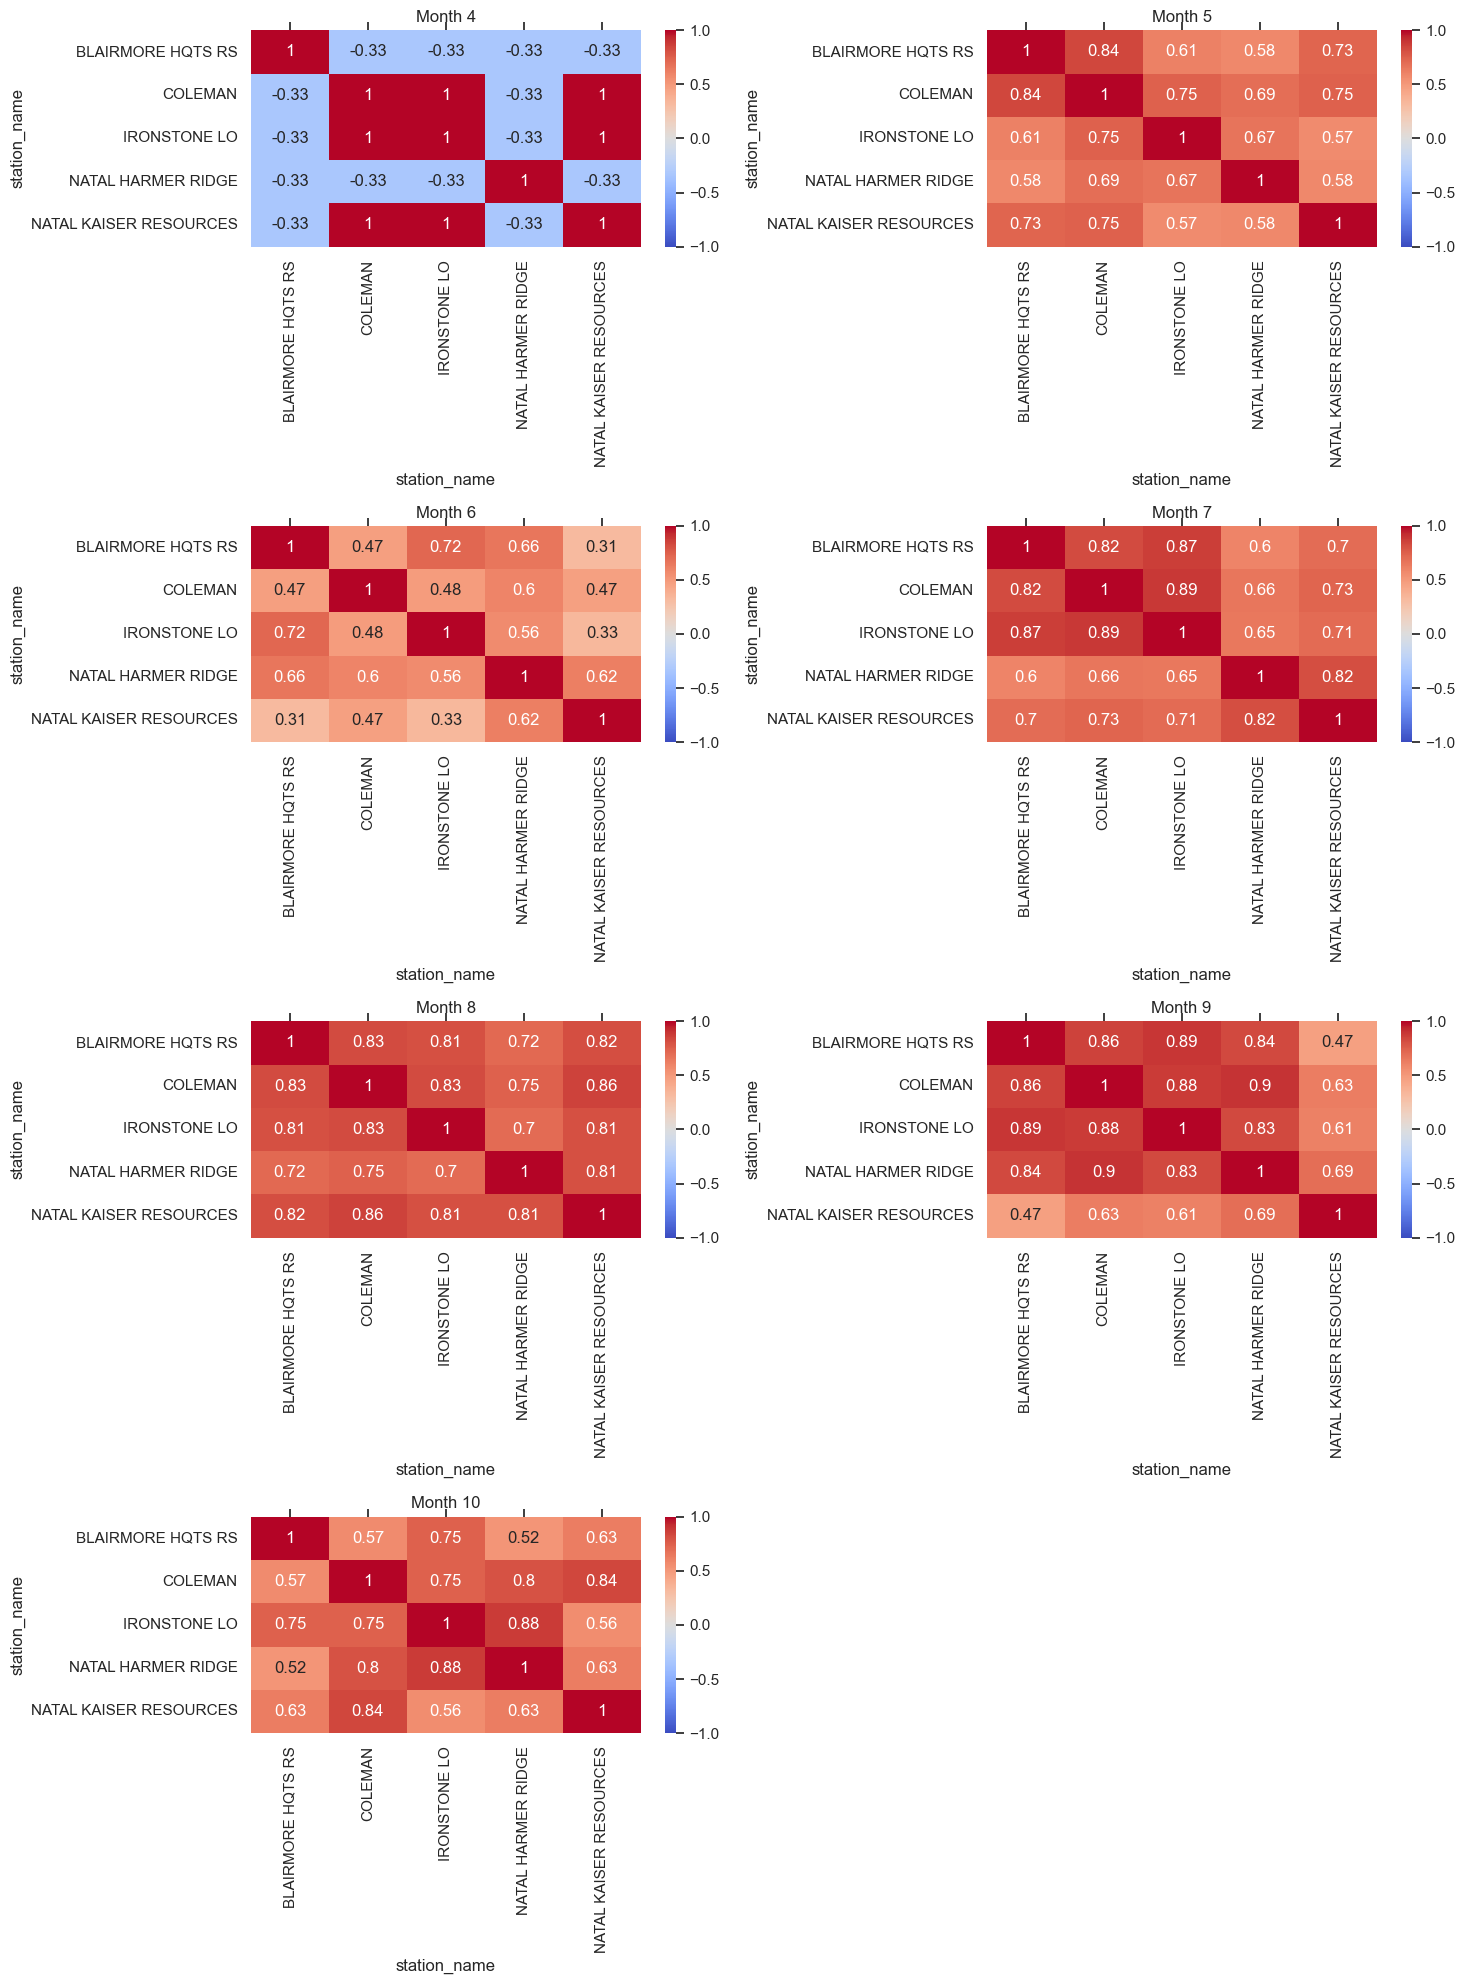

In [259]:
plot_cross_correlation_matrices(c2_monthly_dataframes)

#### Combination 3 
combo3 = ['NATAL HARMER RIDGE', 'IRONSTONE LO', 'CROWSNEST', 'COLEMAN', 'BLAIRMORE HQTS RS'] 0 count

In [260]:
# summary_combo3_monthly_df = describe_dataframes_to_dataframe(c3_monthly_dataframes)
# summary_combo3_monthly_df

In [261]:
# plot_cross_correlation_matrices(c3_monthly_dataframes)

#### Combination 4 
combo4 = ['WILLOUGHBY RIDGE', 'SPARWOOD CS', 'SPARWOOD', 'PELLETIER CREEK', 'IRONSTONE LO', 'CROWSNEST CREEK', 'CROWSNEST'] 85 count

In [262]:
summary_combo4_monthly_df = describe_dataframes_to_dataframe(c4_monthly_dataframes)
summary_combo4_monthly_df

count      mean       std  min    25%   50%    75%   max
  station_name                                                              
5 CROWSNEST          14.0  3.200000  5.280443  0.0  0.000  0.70  3.500  17.8
  CROWSNEST CREEK    14.0  2.614286  2.715725  0.0  0.800  2.15  3.475   8.4
  IRONSTONE LO       14.0  3.600000  4.970683  0.0  0.000  0.70  6.500  14.4
  PELLETIER CREEK    14.0  2.307143  2.586790  0.0  0.800  1.40  2.600   8.1
  SPARWOOD           14.0  2.428571  2.974618  0.0  0.575  2.00  3.000  11.5
  SPARWOOD CS        14.0  2.185714  2.074704  0.0  0.400  2.00  3.100   7.0
  WILLOUGHBY RIDGE   14.0  4.678571  8.665953  0.0  0.000  0.80  5.475  31.8
  month              14.0  5.000000  0.000000  5.0  5.000  5.00  5.000   5.0
6 CROWSNEST          30.0  2.273333  3.885777  0.0  0.000  0.20  2.550  16.4
  CROWSNEST CREEK    30.0  3.246667  7.324250  0.0  0.075  0.40  2.625  38.2
  IRONSTONE LO       30.0  2.570000  3.724398  0.0  0.000  0.40  4.500  13.8
  PELLETIER CREEK    30.0  2.783333  4.589575  0.0  0.300  0.80  2.450  19.6
  SPARWOOD           30.0  2.403333  3.930033  0.0  0.000  0.00  4.100  14.9
  SPARWOOD CS        30.0  2.320000  3.673052  0.0  0.000  0.10  4.600  12.8
  WILLOUGHBY RIDGE   30.0  3.830000  6.349920  0.0  0.300  1.00  3.800  24.4
  month              30.0  6.000000  0.000000  6.0  6.000  6.00  6.000   6.0
7 CROWSNEST          12.0  0.366667  1.146801  0.0  0.000  0.00  0.050   4.0
  CROWSNEST CREEK    12.0  2.350000  4.508880  0.3  0.300  0.50  0.575  13.0
  IRONSTONE LO       12.0  0.558333  1.782469  0.0  0.000  0.00  0.000   6.2
  PELLETIER CREEK    12.0  1.058333  1.864724  0.0  0.300  0.30  0.625   6.6
  SPARWOOD           12.0  1.283333  3.040584  0.0  0.000  0.00  0.000   8.9
  SPARWOOD CS        12.0  1.250000  3.744693  0.0  0.000  0.00  0.000  13.0
  WILLOUGHBY RIDGE   12.0  1.216667  2.542309  0.0  0.225  0.40  0.800   9.1
  month              12.0  7.000000  0.000000  7.0  7.000  7.00  7.000   7.0
9 CROWSNEST          29.0  0.786207  1.536630  0.0  0.000  0.00  0.800   6.6
  CROWSNEST CREEK    29.0  0.806897  1.367200  0.0  0.000  0.00  1.500   5.3
  IRONSTONE LO       29.0  1.062069  2.515014  0.0  0.000  0.00  0.600   9.2
  PELLETIER CREEK    29.0  1.227586  2.321929  0.0  0.000  0.00  1.300   9.9
  SPARWOOD           29.0  1.072414  2.375003  0.0  0.000  0.00  0.000   8.4
  SPARWOOD CS        29.0  0.800000  1.839255  0.0  0.000  0.00  0.000   6.8
  WILLOUGHBY RIDGE   29.0  1.544828  2.448117  0.0  0.000  0.00  3.000   9.0
  month              29.0  9.000000  0.000000  9.0  9.000  9.00  9.000   9.0

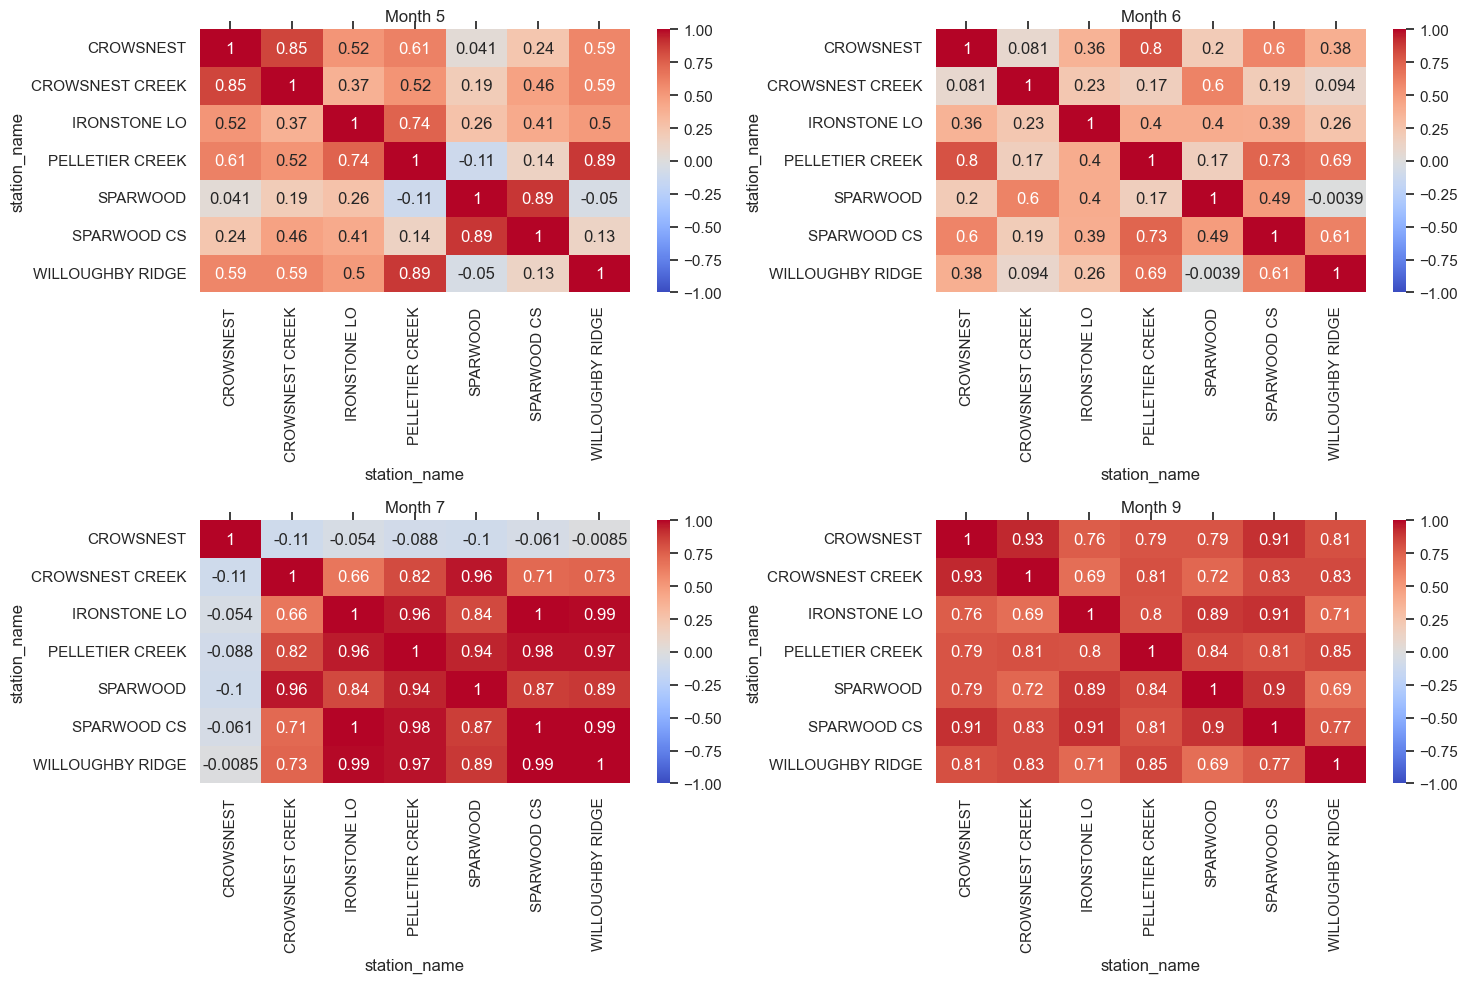

In [263]:
plot_cross_correlation_matrices(c4_monthly_dataframes)

#### Combination 5 
combo5 = ['COLEMAN', 'BLAIRMORE HQTS RS'] 6927 count

In [264]:
summary_combo5_monthly_df = describe_dataframes_to_dataframe(c5_monthly_dataframes)
summary_combo5_monthly_df

count       mean       std   min   25%   50%     75%  \
   station_name                                                              
1  BLAIRMORE HQTS RS  434.0   1.391475  3.590055   0.0   0.0   0.0   0.000   
   COLEMAN            434.0   1.156912  3.338765   0.0   0.0   0.0   0.000   
   month              434.0   1.000000  0.000000   1.0   1.0   1.0   1.000   
2  BLAIRMORE HQTS RS  397.0   1.818388  5.281576   0.0   0.0   0.0   0.000   
   COLEMAN            397.0   1.329723  4.055165   0.0   0.0   0.0   1.000   
   month              397.0   2.000000  0.000000   2.0   2.0   2.0   2.000   
3  BLAIRMORE HQTS RS  434.0   1.094009  2.606558   0.0   0.0   0.0   0.000   
   COLEMAN            434.0   1.112673  2.498637   0.0   0.0   0.0   1.000   
   month              434.0   3.000000  0.000000   3.0   3.0   3.0   3.000   
4  BLAIRMORE HQTS RS  527.0   1.397723  3.909070   0.0   0.0   0.0   0.600   
   COLEMAN            527.0   1.343454  3.149813   0.0   0.0   0.0   1.000   
   month              527.0   4.000000  0.000000   4.0   4.0   4.0   4.000   
5  BLAIRMORE HQTS RS  695.0   2.377554  5.695601   0.0   0.0   0.0   2.000   
   COLEMAN            695.0   2.090360  4.460409   0.0   0.0   0.0   2.000   
   month              695.0   5.000000  0.000000   5.0   5.0   5.0   5.000   
6  BLAIRMORE HQTS RS  660.0   2.274091  6.774672   0.0   0.0   0.0   1.925   
   COLEMAN            660.0   2.103030  4.552232   0.0   0.0   0.0   2.000   
   month              660.0   6.000000  0.000000   6.0   6.0   6.0   6.000   
7  BLAIRMORE HQTS RS  775.0   1.927613  5.282689   0.0   0.0   0.0   1.200   
   COLEMAN            775.0   1.951871  4.629237   0.0   0.0   0.0   1.600   
   month              775.0   7.000000  0.000000   7.0   7.0   7.0   7.000   
8  BLAIRMORE HQTS RS  775.0   1.720774  4.878455   0.0   0.0   0.0   0.800   
   COLEMAN            775.0   1.750194  4.625083   0.0   0.0   0.0   1.300   
   month              775.0   8.000000  0.000000   8.0   8.0   8.0   8.000   
9  BLAIRMORE HQTS RS  682.0   1.586950  4.283653   0.0   0.0   0.0   0.800   
   COLEMAN            682.0   1.564370  3.953876   0.0   0.0   0.0   1.000   
   month              682.0   9.000000  0.000000   9.0   9.0   9.0   9.000   
10 BLAIRMORE HQTS RS  543.0   1.480663  3.656230   0.0   0.0   0.0   0.600   
   COLEMAN            543.0   1.556722  3.892720   0.0   0.0   0.0   1.000   
   month              543.0  10.000000  0.000000  10.0  10.0  10.0  10.000   
11 BLAIRMORE HQTS RS  509.0   1.576817  4.403628   0.0   0.0   0.0   0.000   
   COLEMAN            509.0   1.785855  5.034010   0.0   0.0   0.0   1.000   
   month              509.0  11.000000  0.000000  11.0  11.0  11.0  11.000   
12 BLAIRMORE HQTS RS  496.0   1.729637  4.913160   0.0   0.0   0.0   0.650   
   COLEMAN            496.0   1.394758  3.909622   0.0   0.0   0.0   0.525   
   month              496.0  12.000000  0.000000  12.0  12.0  12.0  12.000   

                       max  
   station_name             
1  BLAIRMORE HQTS RS  26.4  
   COLEMAN            24.3  
   month               1.0  
2  BLAIRMORE HQTS RS  48.8  
   COLEMAN            39.0  
   month               2.0  
3  BLAIRMORE HQTS RS  16.0  
   COLEMAN            20.2  
   month               3.0  
4  BLAIRMORE HQTS RS  42.6  
   COLEMAN            32.1  
   month               4.0  
5  BLAIRMORE HQTS RS  53.8  
   COLEMAN            39.4  
   month               5.0  
6  BLAIRMORE HQTS RS  79.0  
   COLEMAN            35.6  
   month               6.0  
7  BLAIRMORE HQTS RS  58.0  
   COLEMAN            37.4  
   month               7.0  
8  BLAIRMORE HQTS RS  54.4  
   COLEMAN            63.0  
   month               8.0  
9  BLAIRMORE HQTS RS  44.2  
   COLEMAN            38.1  
   month               9.0  
10 BLAIRMORE HQTS RS  25.2  
   COLEMAN            31.4  
   month              10.0  
11 BLAIRMORE HQTS RS  30.8  
   COLEMAN            53.2  
   month              11.0  
12 BLAIRMORE HQTS RS  47.6  
   COLEMAN   

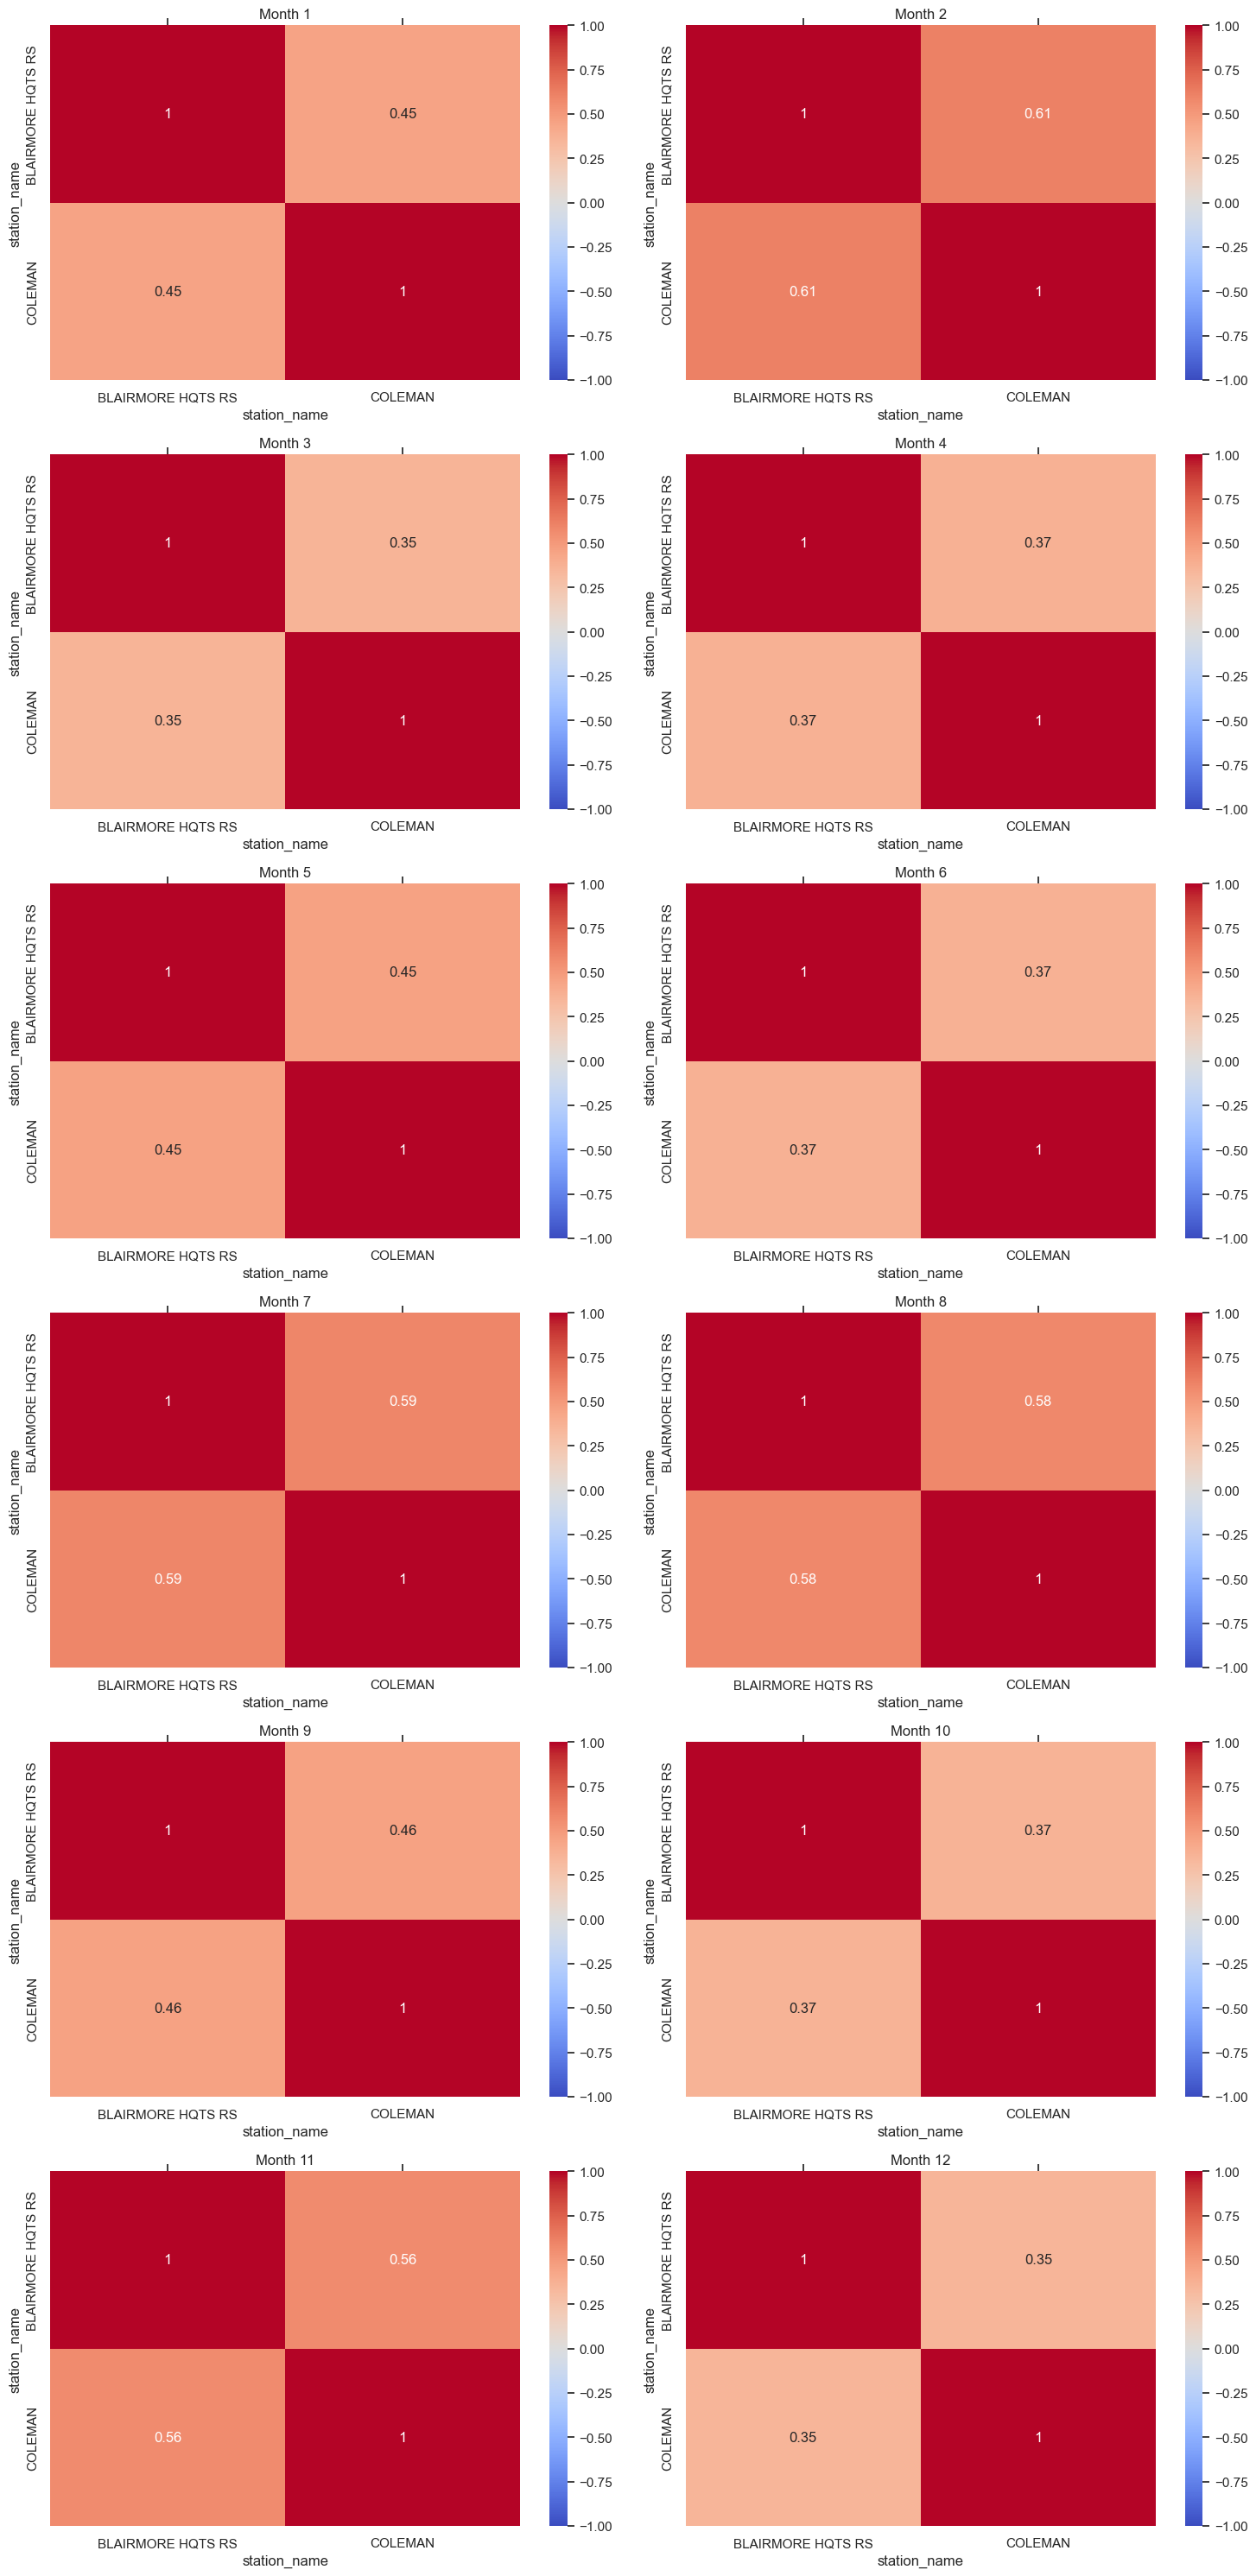

In [265]:
plot_cross_correlation_matrices(c5_monthly_dataframes)

#### Combination 6
combo6 = ['COLEMAN', 'IRONSTONE LO'] 4978 count

In [266]:
summary_combo6_monthly_df = describe_dataframes_to_dataframe(c6_monthly_dataframes)
summary_combo6_monthly_df


count       mean       std   min    25%   50%     75%   max
   station_name                                                              
4  COLEMAN         16.0   1.125000  2.388724   0.0   0.00   0.0   1.050   9.0
   IRONSTONE LO    16.0   2.293750  4.057334   0.0   0.00   0.0   2.500  14.4
   month           16.0   4.000000  0.000000   4.0   4.00   4.0   4.000   4.0
5  COLEMAN        631.0   2.184152  4.783235   0.0   0.00   0.0   2.000  39.4
   IRONSTONE LO   631.0   2.931854  7.042786   0.0   0.00   0.0   2.800  75.8
   month          631.0   5.000000  0.000000   5.0   5.00   5.0   5.000   5.0
6  COLEMAN       1079.0   2.336886  5.237808   0.0   0.00   0.0   2.000  52.3
   IRONSTONE LO  1079.0   2.675255  6.375551   0.0   0.00   0.0   2.300  63.0
   month         1079.0   6.000000  0.000000   6.0   6.00   6.0   6.000   6.0
7  COLEMAN       1099.0   1.658235  4.264556   0.0   0.00   0.0   1.000  37.4
   IRONSTONE LO  1099.0   1.770155  4.862312   0.0   0.00   0.0   1.200  62.4
   month         1099.0   7.000000  0.000000   7.0   7.00   7.0   7.000   7.0
8  COLEMAN       1083.0   1.540997  4.375539   0.0   0.00   0.0   0.800  63.0
   IRONSTONE LO  1083.0   1.680055  4.469458   0.0   0.00   0.0   1.000  49.7
   month         1083.0   8.000000  0.000000   8.0   8.00   8.0   8.000   8.0
9  COLEMAN        833.0   1.526891  3.829823   0.0   0.00   0.0   1.000  38.1
   IRONSTONE LO   833.0   1.884034  4.471872   0.0   0.00   0.0   1.300  34.7
   month          833.0   9.000000  0.000000   9.0   9.00   9.0   9.000   9.0
10 COLEMAN        233.0   1.140773  3.107779   0.0   0.00   0.0   0.000  25.2
   IRONSTONE LO   233.0   1.784120  4.676100   0.0   0.00   0.0   1.000  40.6
   month          233.0  10.000000  0.000000  10.0  10.00  10.0  10.000  10.0
11 COLEMAN          4.0   4.625000  4.871943   0.0   0.75   4.3   8.175   9.9
   IRONSTONE LO     4.0   5.275000  4.275024   0.0   2.70   6.1   8.675   8.9
   month            4.0  11.000000  0.000000  11.0  11.00  11.0  11.000  11.0

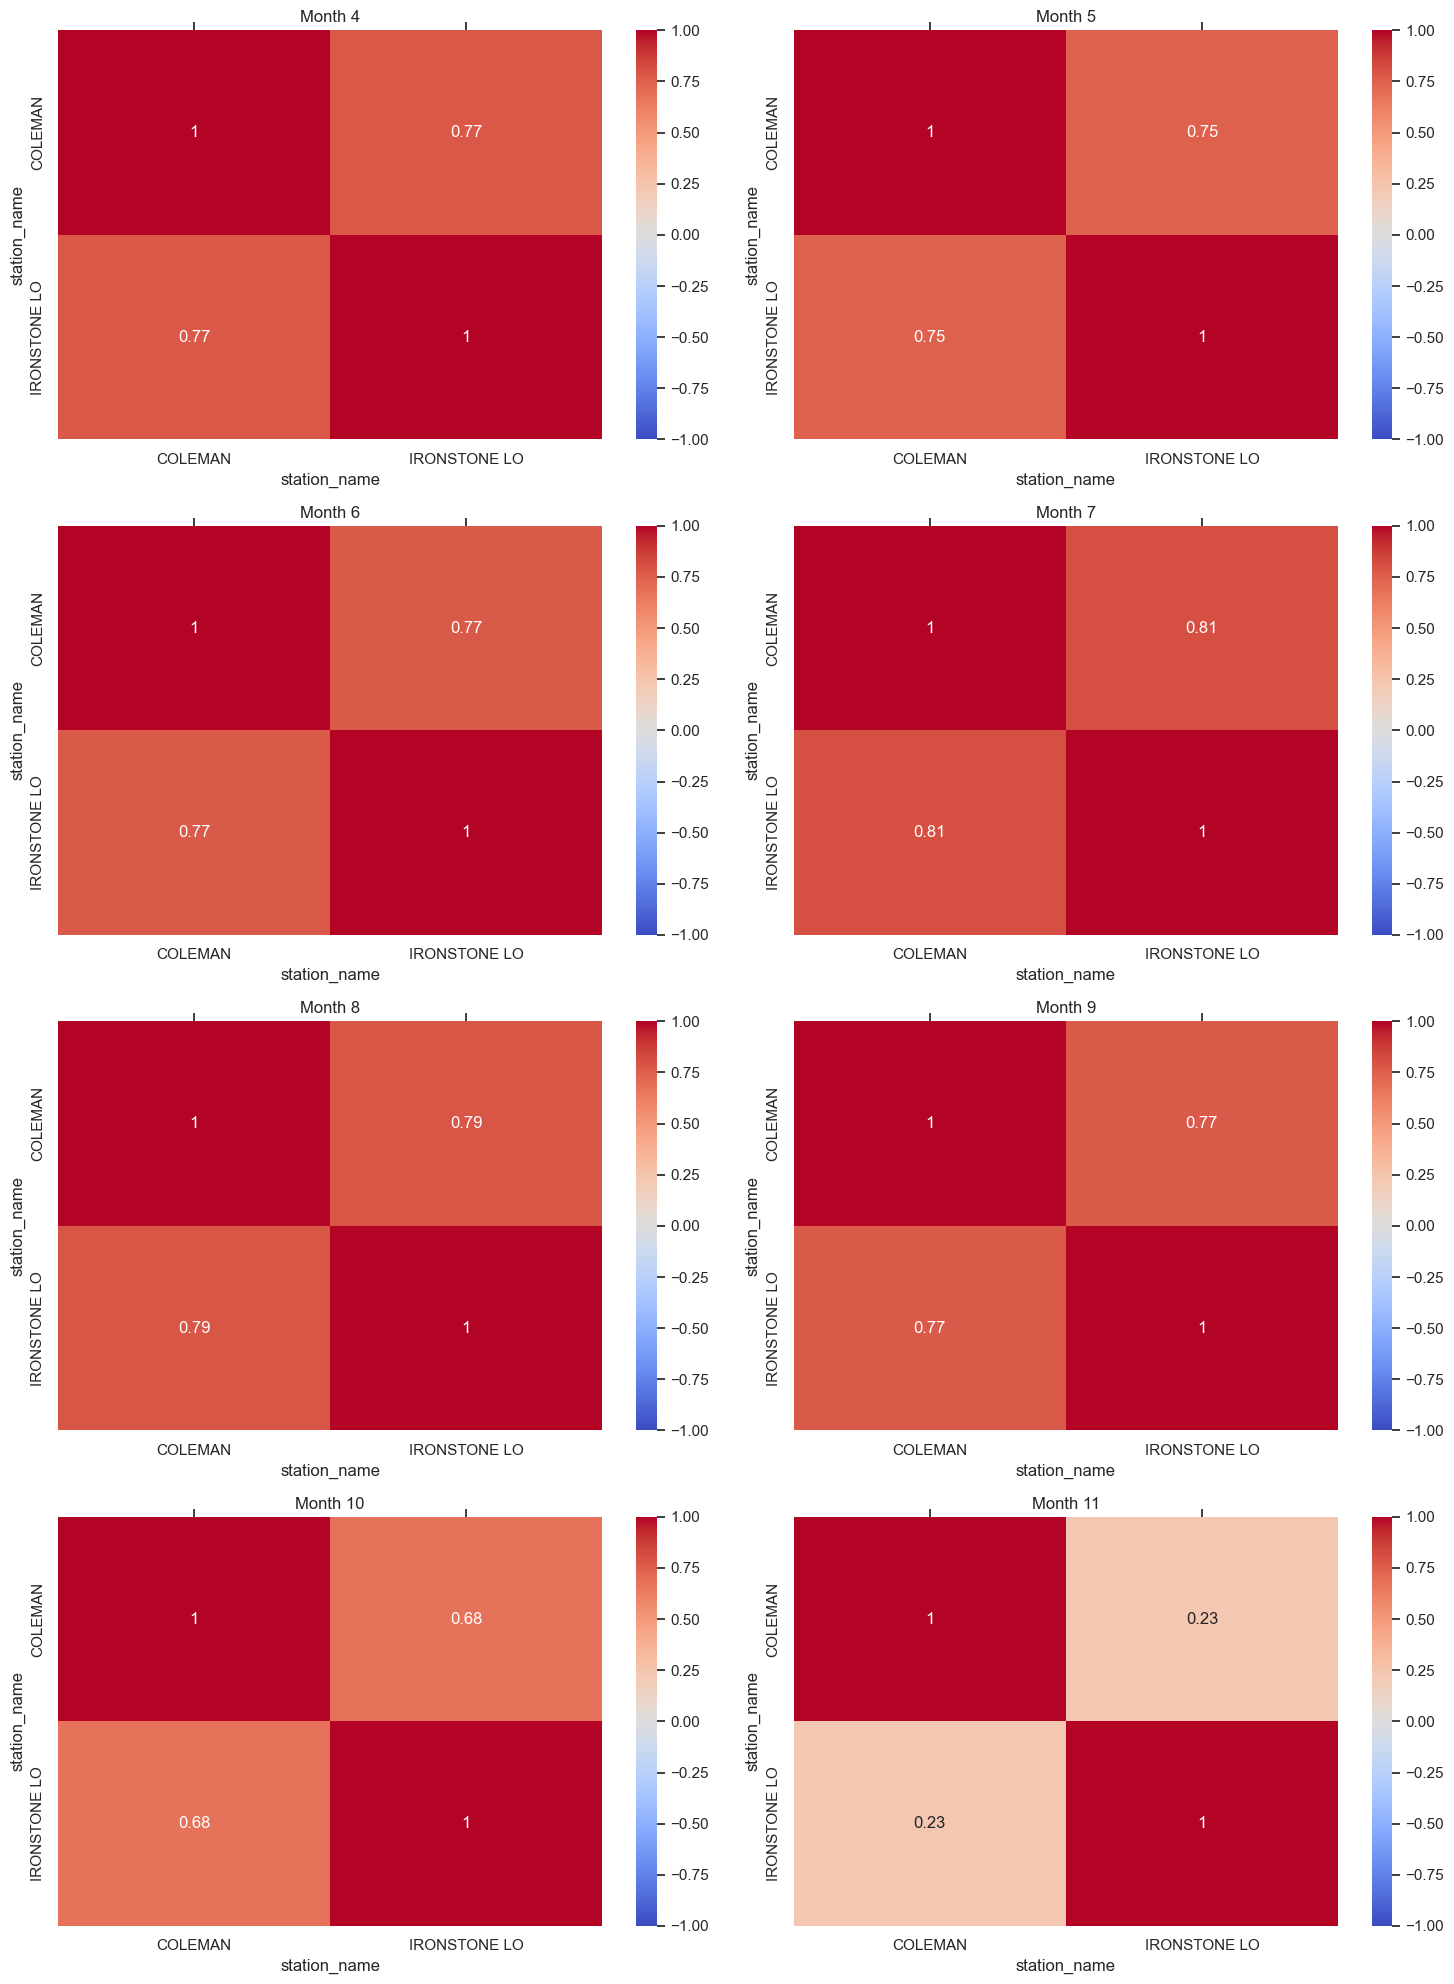

In [267]:
plot_cross_correlation_matrices(c6_monthly_dataframes)

#### Combination 7
combo7 = ['IRONSTONE LO', 'CROWSNEST'] 1613 count

In [268]:
summary_combo7_monthly_df = describe_dataframes_to_dataframe(c7_monthly_dataframes)
summary_combo7_monthly_df

count      mean       std  min  25%   50%    75%   max
  station_name                                                        
5 CROWSNEST     135.0  2.472593  5.199805  0.0  0.0  0.00  2.000  34.4
  IRONSTONE LO  135.0  2.447407  4.143018  0.0  0.0  0.20  3.000  18.3
  month         135.0  5.000000  0.000000  5.0  5.0  5.00  5.000   5.0
6 CROWSNEST     394.0  2.901015  7.804941  0.0  0.0  0.20  2.000  97.6
  IRONSTONE LO  394.0  3.277157  7.569847  0.0  0.0  0.45  3.375  69.0
  month         394.0  6.000000  0.000000  6.0  6.0  6.00  6.000   6.0
7 CROWSNEST     407.0  1.154300  3.900180  0.0  0.0  0.00  0.200  46.0
  IRONSTONE LO  407.0  1.488452  4.586921  0.0  0.0  0.00  0.400  44.8
  month         407.0  7.000000  0.000000  7.0  7.0  7.00  7.000   7.0
8 CROWSNEST     415.0  1.189880  3.650768  0.0  0.0  0.00  0.200  31.0
  IRONSTONE LO  415.0  1.279036  3.551821  0.0  0.0  0.00  0.600  31.2
  month         415.0  8.000000  0.000000  8.0  8.0  8.00  8.000   8.0
9 CROWSNEST     262.0  1.613740  5.568766  0.0  0.0  0.00  0.600  65.0
  IRONSTONE LO  262.0  1.269847  3.157483  0.0  0.0  0.00  1.000  21.4
  month         262.0  9.000000  0.000000  9.0  9.0  9.00  9.000   9.0

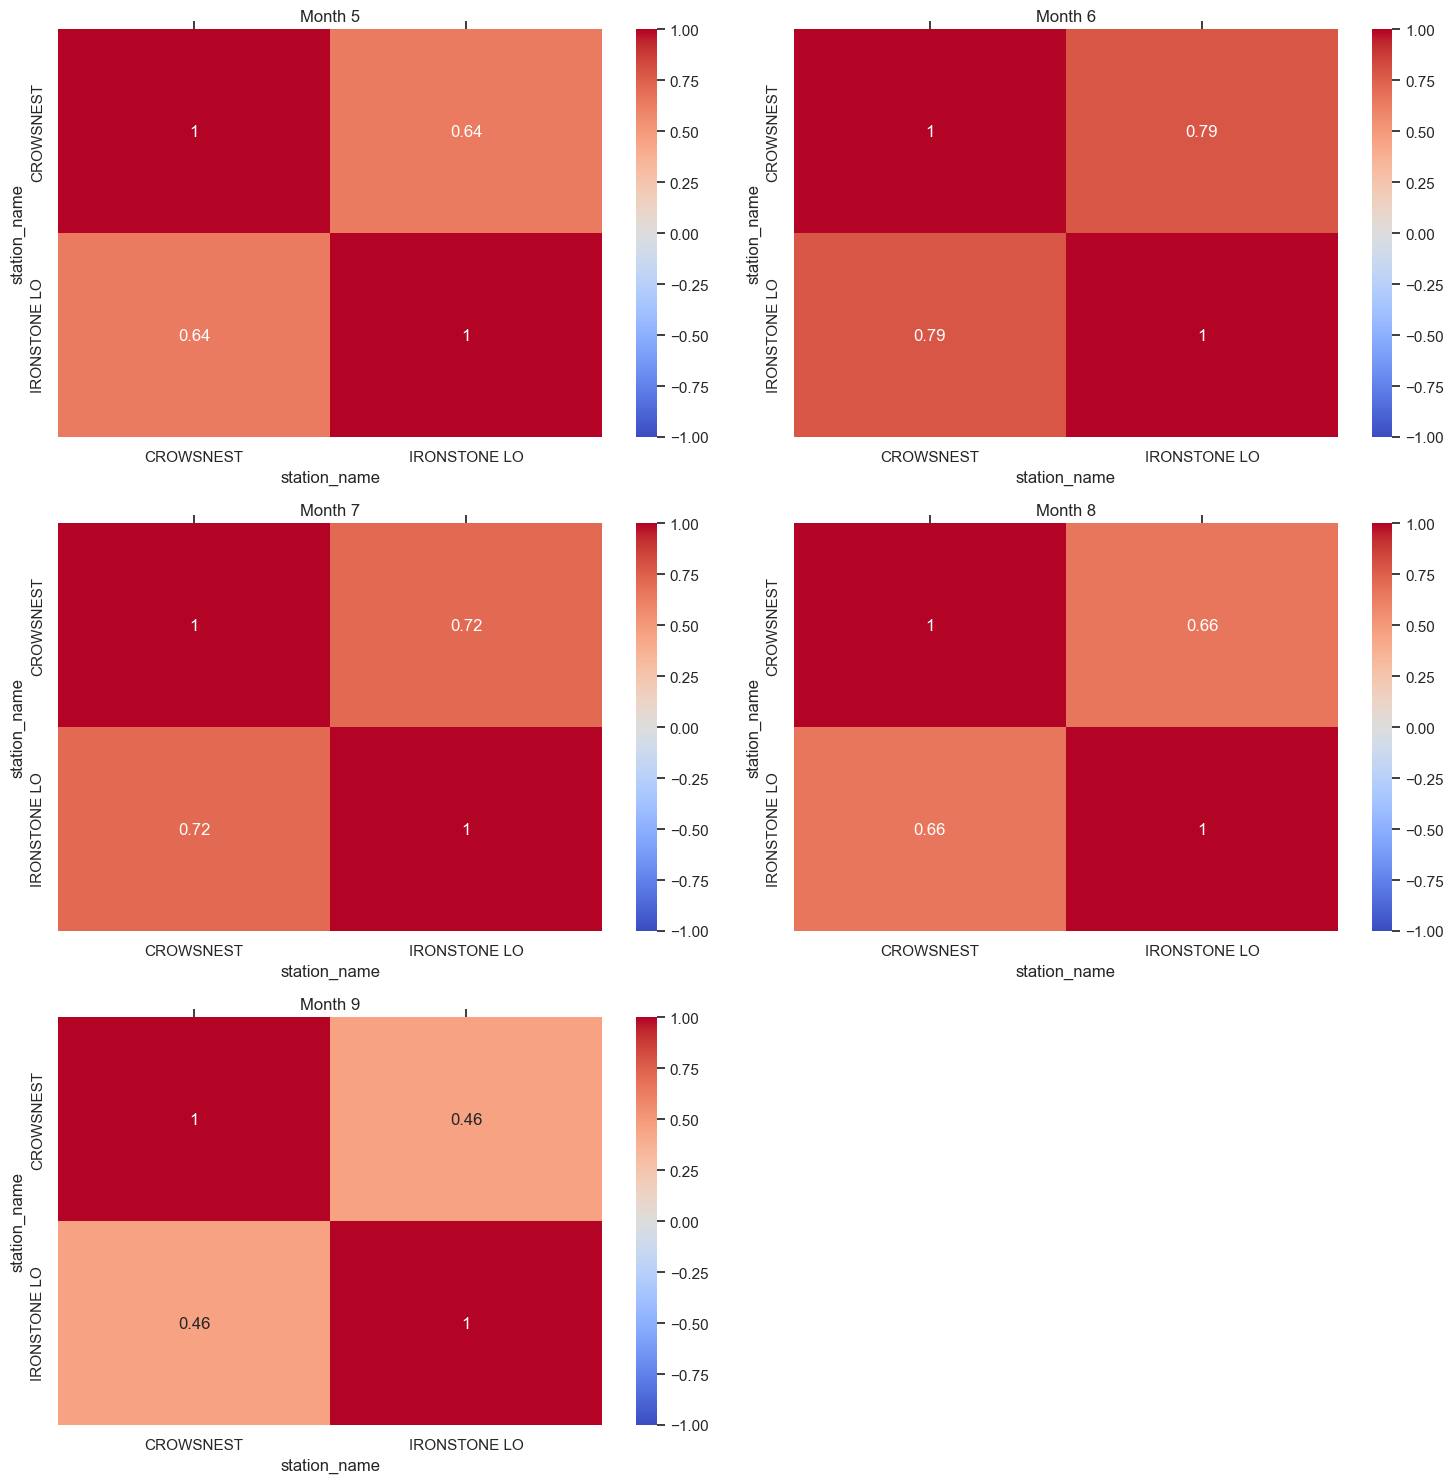

In [269]:
plot_cross_correlation_matrices(c7_monthly_dataframes)

#### Combination 8
combo8 = ['IRONSTONE LO', 'NATAL HARMER RIDGE'] 2661 count

In [270]:
summary_combo8_monthly_df = describe_dataframes_to_dataframe(c8_monthly_dataframes)
summary_combo8_monthly_df

count       mean       std   min   25%   50%     75%  \
   station_name                                                               
4  IRONSTONE LO          9.0   2.477778  4.677012   0.0   0.0   0.0   2.200   
   NATAL HARMER RIDGE    9.0   2.966667  5.714893   0.0   0.0   0.0   1.000   
   month                 9.0   4.000000  0.000000   4.0   4.0   4.0   4.000   
5  IRONSTONE LO        424.0   2.799528  7.471456   0.0   0.0   0.0   2.000   
   NATAL HARMER RIDGE  424.0   1.787972  3.715837   0.0   0.0   0.0   1.800   
   month               424.0   5.000000  0.000000   5.0   5.0   5.0   5.000   
6  IRONSTONE LO        540.0   2.127407  5.251962   0.0   0.0   0.0   1.625   
   NATAL HARMER RIDGE  540.0   1.775000  3.657958   0.0   0.0   0.0   2.000   
   month               540.0   6.000000  0.000000   6.0   6.0   6.0   6.000   
7  IRONSTONE LO        553.0   1.735624  5.031208   0.0   0.0   0.0   1.300   
   NATAL HARMER RIDGE  553.0   1.779747  4.324859   0.0   0.0   0.0   1.200   
   month               553.0   7.000000  0.000000   7.0   7.0   7.0   7.000   
8  IRONSTONE LO        556.0   2.057914  5.087801   0.0   0.0   0.0   1.500   
   NATAL HARMER RIDGE  556.0   1.823022  4.556110   0.0   0.0   0.0   1.800   
   month               556.0   8.000000  0.000000   8.0   8.0   8.0   8.000   
9  IRONSTONE LO        458.0   1.770306  4.563377   0.0   0.0   0.0   1.000   
   NATAL HARMER RIDGE  458.0   1.480131  3.682690   0.0   0.0   0.0   0.750   
   month               458.0   9.000000  0.000000   9.0   9.0   9.0   9.000   
10 IRONSTONE LO        121.0   1.475207  4.085794   0.0   0.0   0.0   0.500   
   NATAL HARMER RIDGE  121.0   1.295868  3.976963   0.0   0.0   0.0   0.300   
   month               121.0  10.000000  0.000000  10.0  10.0  10.0  10.000   

                        max  
   station_name              
4  IRONSTONE LO        14.4  
   NATAL HARMER RIDGE  15.0  
   month                4.0  
5  IRONSTONE LO        75.8  
   NATAL HARMER RIDGE  25.0  
   month                5.0  
6  IRONSTONE LO        52.0  
   NATAL HARMER RIDGE  25.0  
   month                6.0  
7  IRONSTONE LO        62.4  
   NATAL HARMER RIDGE  34.6  
   month                7.0  
8  IRONSTONE LO        49.7  
   NATAL HARMER RIDGE  53.3  
   month                8.0  
9  IRONSTONE LO        34.7  
   NATAL HARMER RIDGE  34.8  
   month                9.0  
10 IRONSTONE LO        25.4  
   NATAL HARMER RIDGE  24.0  
   month               10.0

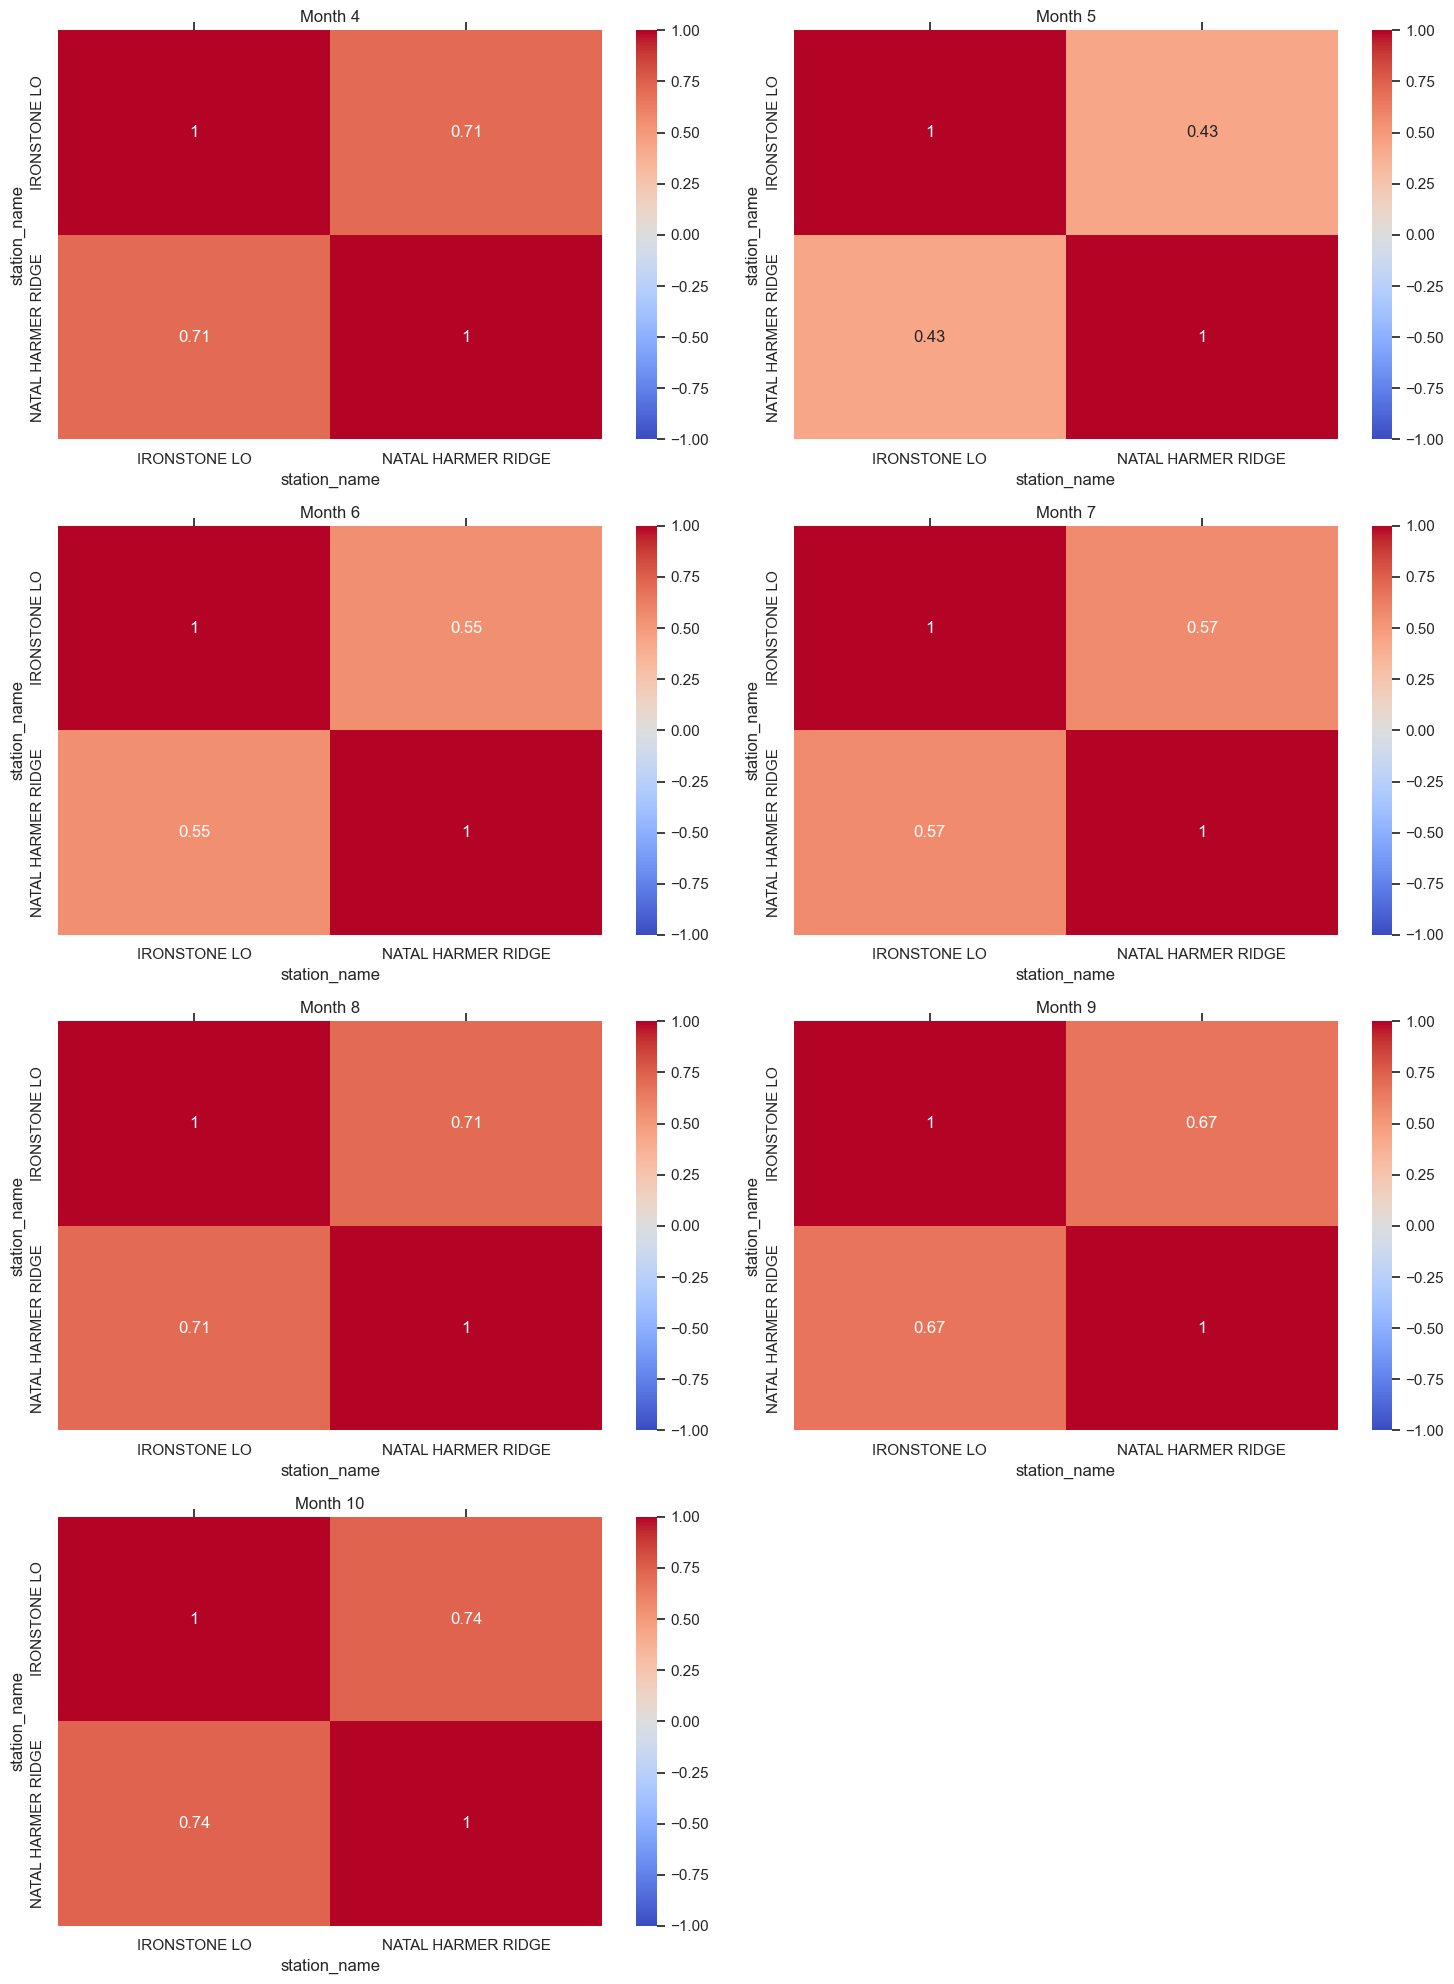

In [271]:
plot_cross_correlation_matrices(c8_monthly_dataframes)

#### Combination 9
combo9 = ['SPARWOOD CS', 'SPARWOOD'] 3802 count

In [272]:
summary_combo9_monthly_df = describe_dataframes_to_dataframe(c9_monthly_dataframes)
summary_combo9_monthly_df


count       mean       std   min   25%   50%     75%   max
   station_name                                                            
1  SPARWOOD       34.0   1.323529  2.554148   0.0   0.0   0.0   1.350   9.2
   SPARWOOD CS    34.0   0.141176  0.823193   0.0   0.0   0.0   0.000   4.8
   month          34.0   1.000000  0.000000   1.0   1.0   1.0   1.000   1.0
2  SPARWOOD       34.0   2.164706  3.209256   0.0   0.0   0.2   3.950  14.2
   SPARWOOD CS    34.0   0.135294  0.754334   0.0   0.0   0.0   0.000   4.4
   month          34.0   2.000000  0.000000   2.0   2.0   2.0   2.000   2.0
3  SPARWOOD      149.0   2.085235  3.798370   0.0   0.0   0.3   2.400  24.4
   SPARWOOD CS   149.0   0.034228  0.228323   0.0   0.0   0.0   0.000   2.4
   month         149.0   3.000000  0.000000   3.0   3.0   3.0   3.000   3.0
4  SPARWOOD      420.0   1.311905  2.879149   0.0   0.0   0.0   1.400  27.1
   SPARWOOD CS   420.0   1.261905  2.815263   0.0   0.0   0.2   1.200  26.8
   month         420.0   4.000000  0.000000   4.0   4.0   4.0   4.000   4.0
5  SPARWOOD      511.0   1.992955  4.171513   0.0   0.0   0.0   2.000  31.7
   SPARWOOD CS   511.0   1.970646  4.119533   0.0   0.0   0.2   2.200  37.8
   month         511.0   5.000000  0.000000   5.0   5.0   5.0   5.000   5.0
6  SPARWOOD      560.0   2.443036  5.885207   0.0   0.0   0.2   2.250  81.8
   SPARWOOD CS   560.0   2.519643  5.860941   0.0   0.0   0.4   2.400  63.0
   month         560.0   6.000000  0.000000   6.0   6.0   6.0   6.000   6.0
7  SPARWOOD      545.0   1.259083  2.807552   0.0   0.0   0.0   0.800  17.4
   SPARWOOD CS   545.0   1.297615  2.999506   0.0   0.0   0.0   0.800  29.2
   month         545.0   7.000000  0.000000   7.0   7.0   7.0   7.000   7.0
8  SPARWOOD      488.0   1.003279  2.710393   0.0   0.0   0.0   0.200  22.1
   SPARWOOD CS   488.0   0.974180  2.368329   0.0   0.0   0.0   0.400  16.8
   month         488.0   8.000000  0.000000   8.0   8.0   8.0   8.000   8.0
9  SPARWOOD      410.0   1.647561  5.015366   0.0   0.0   0.0   0.800  60.2
   SPARWOOD CS   410.0   1.383902  3.532128   0.0   0.0   0.0   0.800  30.8
   month         410.0   9.000000  0.000000   9.0   9.0   9.0   9.000   9.0
10 SPARWOOD      476.0   1.972269  4.302189   0.0   0.0   0.0   2.125  33.5
   SPARWOOD CS   476.0   1.862185  4.092283   0.0   0.0   0.2   1.400  31.4
   month         476.0  10.000000  0.000000  10.0  10.0  10.0  10.000  10.0
11 SPARWOOD      139.0   2.239568  4.174971   0.0   0.0   0.4   2.150  24.4
   SPARWOOD CS   139.0   0.611511  2.371176   0.0   0.0   0.0   0.000  19.8
   month         139.0  11.000000  0.000000  11.0  11.0  11.0  11.000  11.0
12 SPARWOOD       36.0   1.700000  4.900262   0.0   0.0   0.0   1.050  27.4
   SPARWOOD CS    36.0   0.005556  0.033333   0.0   0.0   0.0   0.000   0.2
   month          36.0  12.000000  0.000000  12.0  12.0  12.0  12.000  12.0

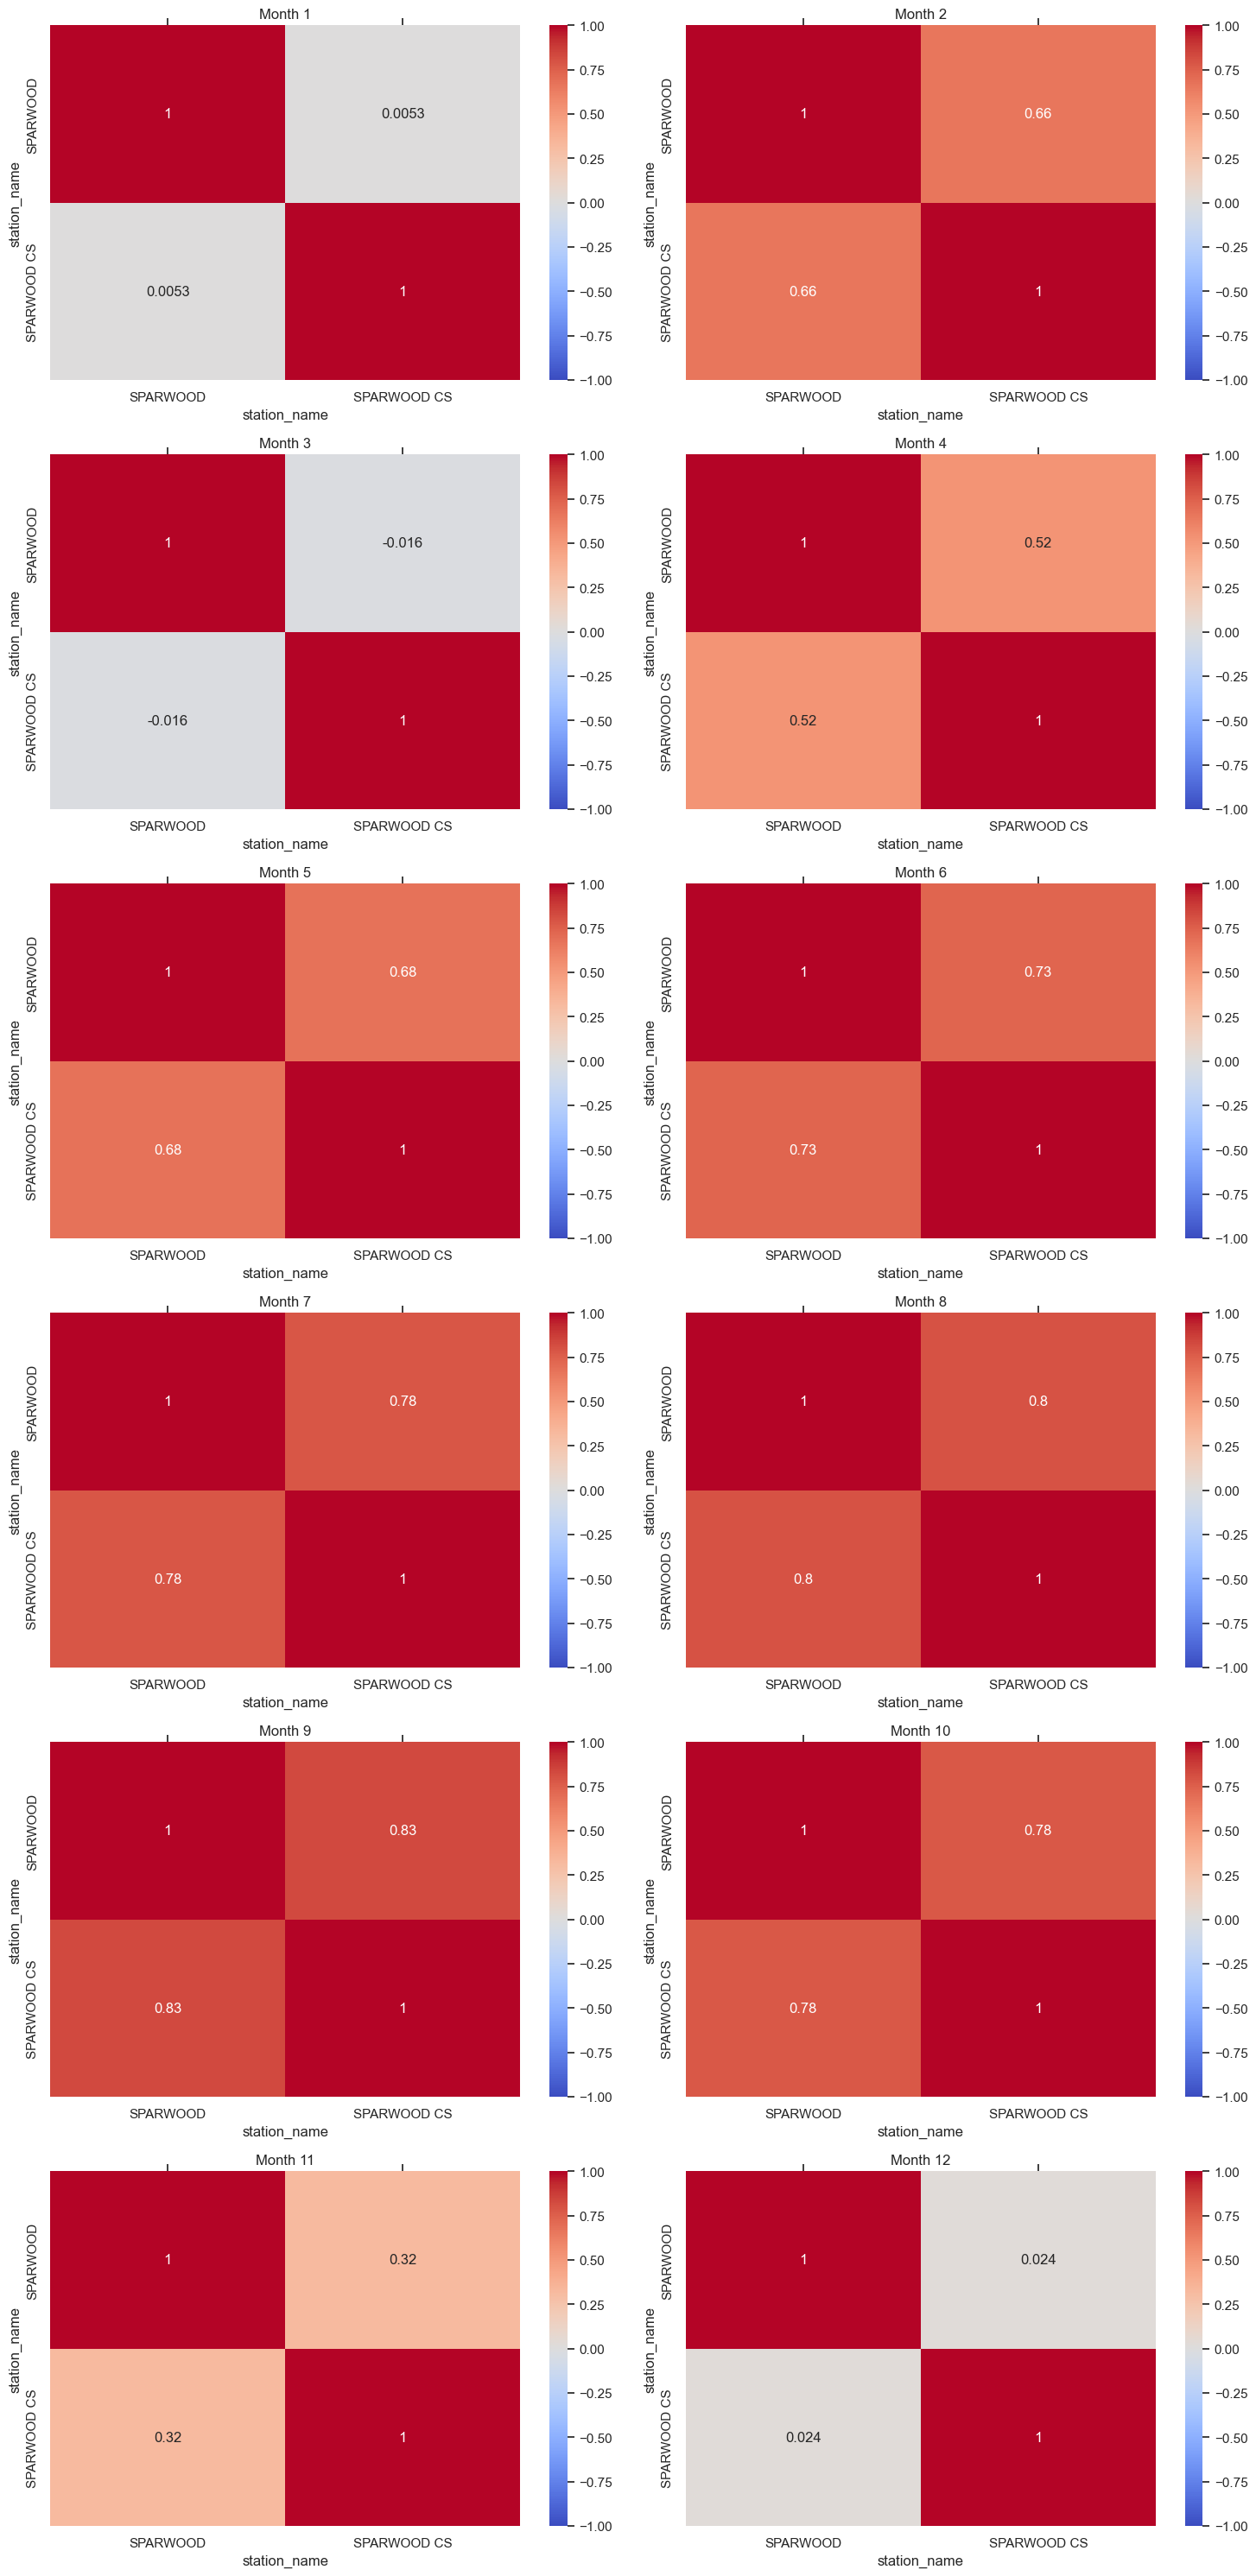

In [273]:
plot_cross_correlation_matrices(c9_monthly_dataframes)

#### Combination 10
combo10 = ['WILLOUGHBY RIDGE', 'SPARWOOD'] 2713 count

In [274]:
summary_combo10_monthly_df = describe_dataframes_to_dataframe(c10_monthly_dataframes)
summary_combo10_monthly_df

count       mean        std   min   25%   50%     75%  \
   station_name                                                              
1  SPARWOOD          247.0   2.039271   4.060462   0.0   0.0   0.0   2.000   
   WILLOUGHBY RIDGE  247.0   1.922267   4.066434   0.0   0.0   0.0   1.800   
   month             247.0   1.000000   0.000000   1.0   1.0   1.0   1.000   
2  SPARWOOD          218.0   1.539908   3.889892   0.0   0.0   0.0   0.800   
   WILLOUGHBY RIDGE  218.0   1.529358   4.871743   0.0   0.0   0.0   0.800   
   month             218.0   2.000000   0.000000   2.0   2.0   2.0   2.000   
3  SPARWOOD          232.0   2.193534   4.590127   0.0   0.0   0.0   2.050   
   WILLOUGHBY RIDGE  232.0   2.174569   4.509423   0.0   0.0   0.0   1.725   
   month             232.0   3.000000   0.000000   3.0   3.0   3.0   3.000   
4  SPARWOOD          268.0   1.442164   3.843177   0.0   0.0   0.0   1.000   
   WILLOUGHBY RIDGE  268.0   2.337313   5.656678   0.0   0.0   0.0   1.500   
   month             268.0   4.000000   0.000000   4.0   4.0   4.0   4.000   
5  SPARWOOD          251.0   2.232271   5.611256   0.0   0.0   0.0   2.100   
   WILLOUGHBY RIDGE  251.0   3.804382  10.369325   0.0   0.0   0.0   2.800   
   month             251.0   5.000000   0.000000   5.0   5.0   5.0   5.000   
6  SPARWOOD          239.0   2.266527   4.475372   0.0   0.0   0.4   2.900   
   WILLOUGHBY RIDGE  239.0   3.262762   8.770644   0.0   0.0   0.0   3.350   
   month             239.0   6.000000   0.000000   6.0   6.0   6.0   6.000   
7  SPARWOOD          247.0   0.747773   1.887352   0.0   0.0   0.0   0.350   
   WILLOUGHBY RIDGE  247.0   0.859514   2.669943   0.0   0.0   0.0   0.300   
   month             247.0   7.000000   0.000000   7.0   7.0   7.0   7.000   
8  SPARWOOD          214.0   1.103271   2.726507   0.0   0.0   0.0   0.375   
   WILLOUGHBY RIDGE  214.0   1.195327   3.136919   0.0   0.0   0.0   0.675   
   month             214.0   8.000000   0.000000   8.0   8.0   8.0   8.000   
9  SPARWOOD          217.0   1.505991   3.511332   0.0   0.0   0.0   2.000   
   WILLOUGHBY RIDGE  217.0   1.890323   4.654990   0.0   0.0   0.0   1.000   
   month             217.0   9.000000   0.000000   9.0   9.0   9.0   9.000   
10 SPARWOOD          185.0   1.786486   4.174766   0.0   0.0   0.0   1.600   
   WILLOUGHBY RIDGE  185.0   2.153514   5.002456   0.0   0.0   0.0   1.500   
   month             185.0  10.000000   0.000000  10.0  10.0  10.0  10.000   
11 SPARWOOD          209.0   2.249282   5.064518   0.0   0.0   0.0   2.300   
   WILLOUGHBY RIDGE  209.0   2.392344   5.661131   0.0   0.0   0.0   2.300   
   month             209.0  11.000000   0.000000  11.0  11.0  11.0  11.000   
12 SPARWOOD          186.0   2.238172   4.117569   0.0   0.0   0.2   2.850   
   WILLOUGHBY RIDGE  186.0   1.871505   4.402763   0.0   0.0   0.0   1.725   
   month             186.0  12.000000   0.000000  12.0  12.0  12.0  12.000   

                       max  
   station_name             
1  SPARWOOD           23.8  
   WILLOUGHBY RIDGE   25.1  
   month               1.0  
2  SPARWOOD           29.2  
   WILLOUGHBY RIDGE   41.4  
   month               2.0  
3  SPARWOOD           27.0  
   WILLOUGHBY RIDGE   27.2  
   month               3.0  
4  SPARWOOD           32.3  
   WILLOUGHBY RIDGE   44.7  
   month               4.0  
5  SPARWOOD           49.1  
   WILLOUGHBY RIDGE   85.3  
   month               5.0  
6  SPARWOOD           35.6  
   WILLOUGHBY RIDGE  103.0  
   month               6.0  
7  SPARWOOD           12.5  
   WILLOUGHBY RIDGE   18.5  
   month               7.0  
8  SPARWOOD           16.4  
   WILLOUGHBY RIDGE   22.9  
   month               8.0  
9  SPARWOOD           35.8  
   WILLOUGHBY RIDGE   39.6  
   month               9.0  
10 SPARWOOD           33.5  
   WILLOUGHBY RIDGE   36.3  
   month              10.0  
11 SPARWOOD           47.0  
   WILLOUGHBY RIDGE   52.6  
   month              11.0  
12 SPARWOOD           29.0  
   WILLOUGHB

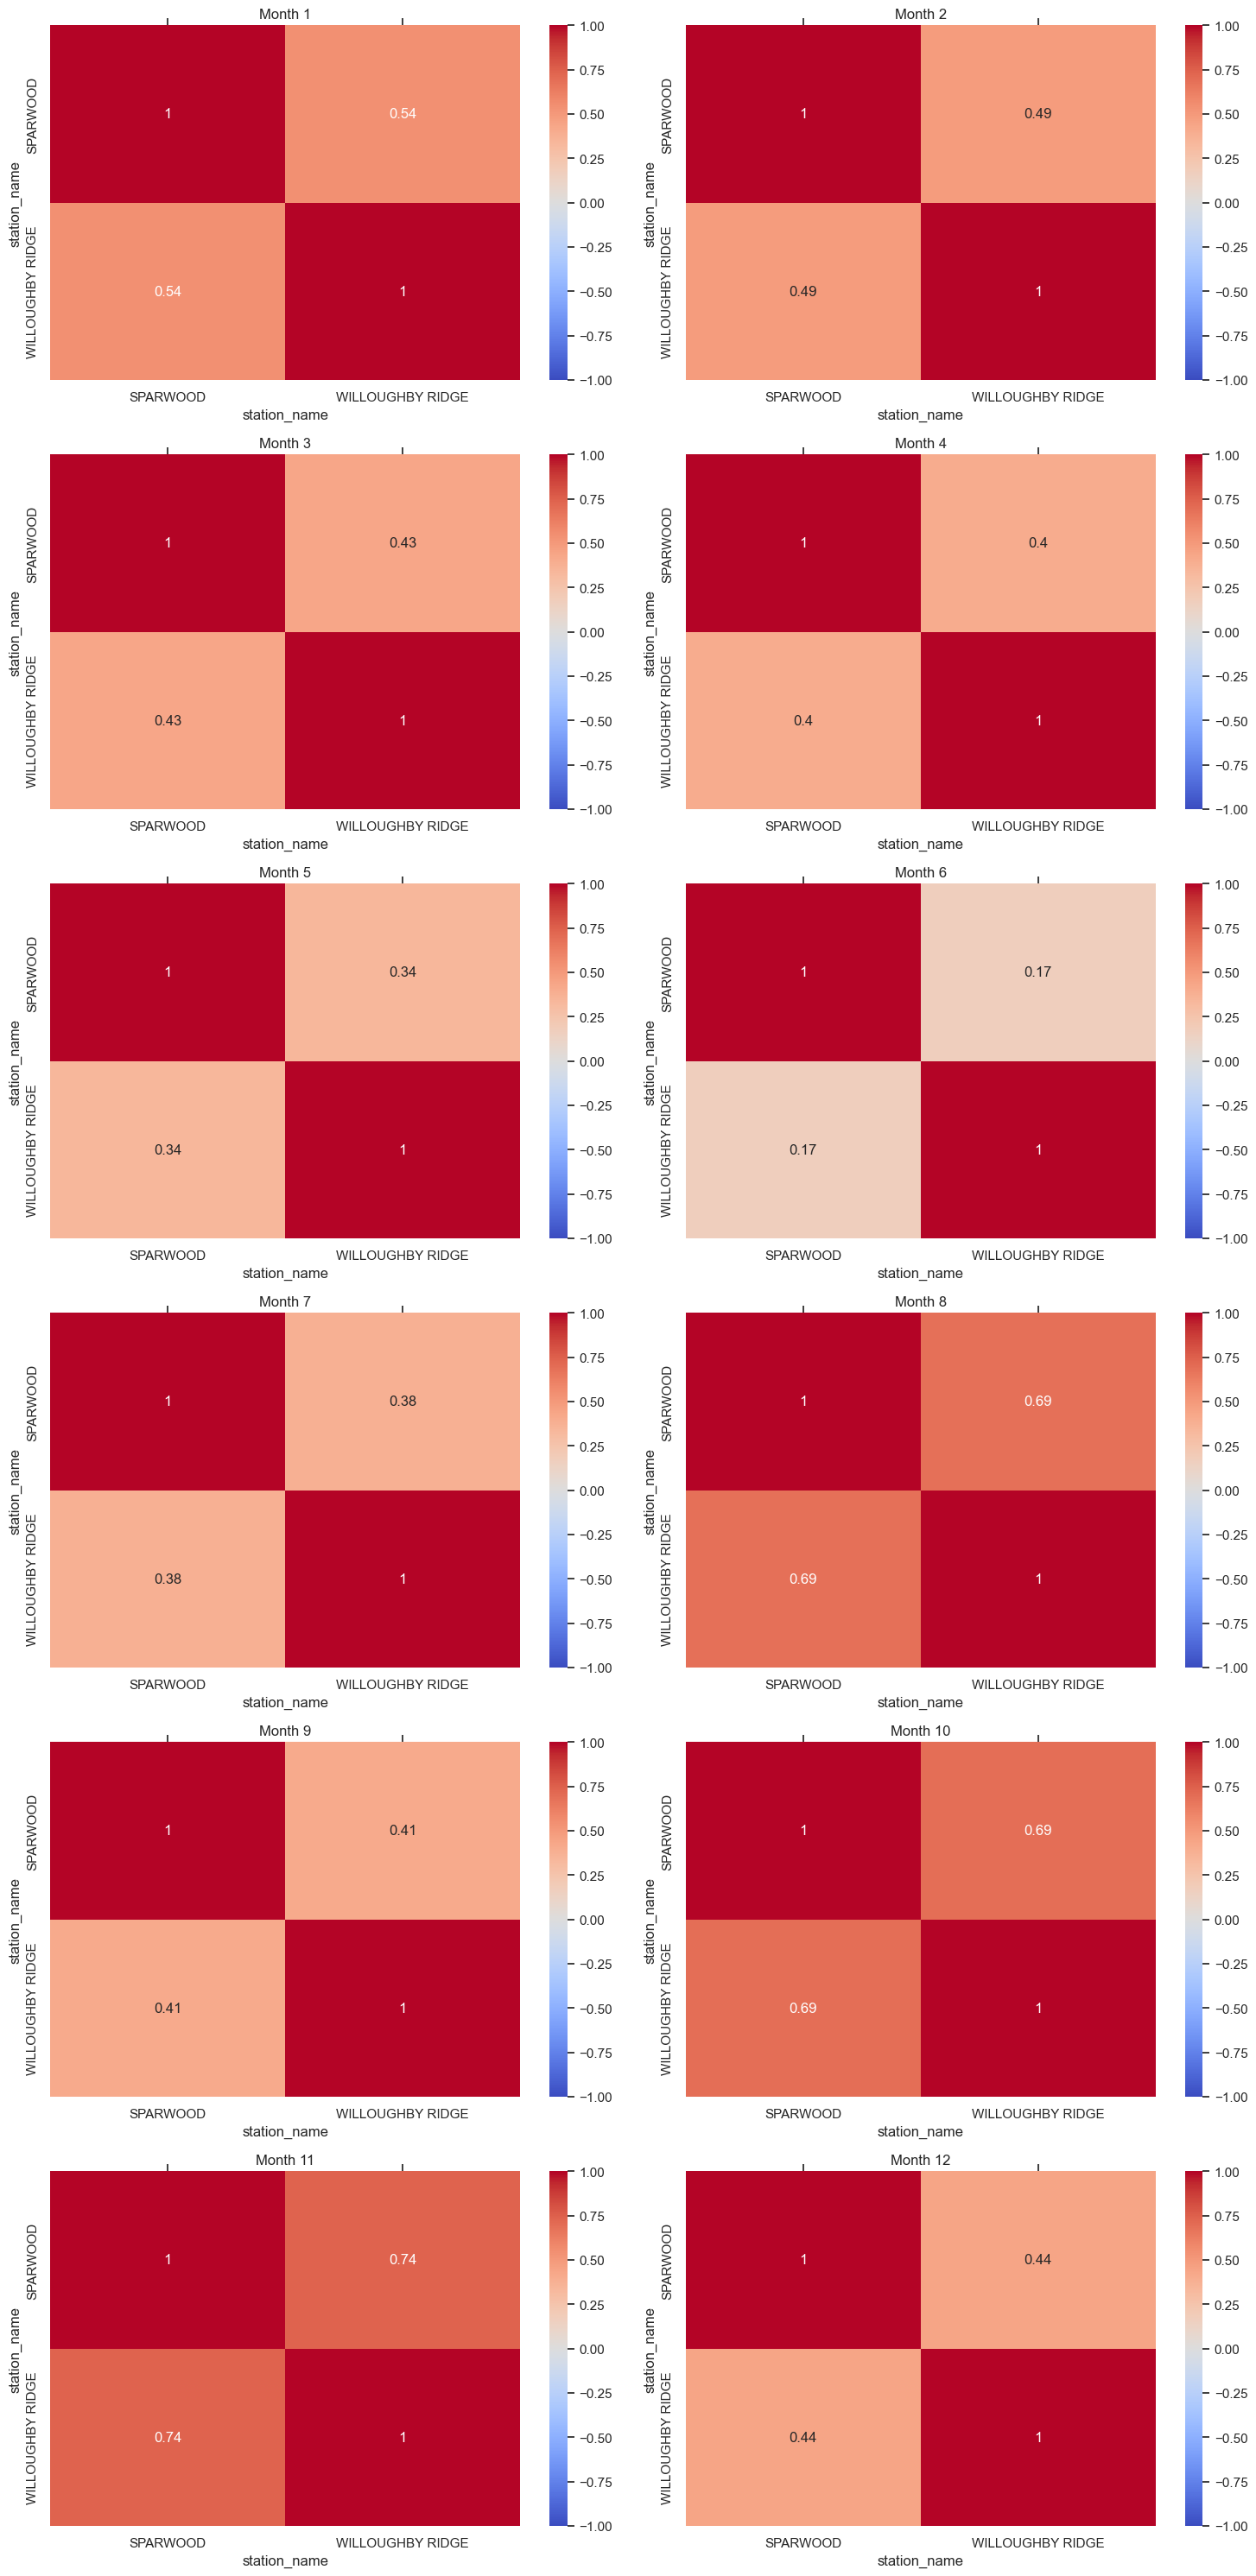

In [275]:
plot_cross_correlation_matrices(c10_monthly_dataframes)

#### Combination 11
combo11 = ['COLEMAN', 'IRONSTONE LO'] 4978 count

In [276]:
summary_combo11_monthly_df = describe_dataframes_to_dataframe(c11_monthly_dataframes)
summary_combo11_monthly_df

count       mean       std   min    25%   50%     75%   max
   station_name                                                              
4  COLEMAN         16.0   1.125000  2.388724   0.0   0.00   0.0   1.050   9.0
   IRONSTONE LO    16.0   2.293750  4.057334   0.0   0.00   0.0   2.500  14.4
   month           16.0   4.000000  0.000000   4.0   4.00   4.0   4.000   4.0
5  COLEMAN        631.0   2.184152  4.783235   0.0   0.00   0.0   2.000  39.4
   IRONSTONE LO   631.0   2.931854  7.042786   0.0   0.00   0.0   2.800  75.8
   month          631.0   5.000000  0.000000   5.0   5.00   5.0   5.000   5.0
6  COLEMAN       1079.0   2.336886  5.237808   0.0   0.00   0.0   2.000  52.3
   IRONSTONE LO  1079.0   2.675255  6.375551   0.0   0.00   0.0   2.300  63.0
   month         1079.0   6.000000  0.000000   6.0   6.00   6.0   6.000   6.0
7  COLEMAN       1099.0   1.658235  4.264556   0.0   0.00   0.0   1.000  37.4
   IRONSTONE LO  1099.0   1.770155  4.862312   0.0   0.00   0.0   1.200  62.4
   month         1099.0   7.000000  0.000000   7.0   7.00   7.0   7.000   7.0
8  COLEMAN       1083.0   1.540997  4.375539   0.0   0.00   0.0   0.800  63.0
   IRONSTONE LO  1083.0   1.680055  4.469458   0.0   0.00   0.0   1.000  49.7
   month         1083.0   8.000000  0.000000   8.0   8.00   8.0   8.000   8.0
9  COLEMAN        833.0   1.526891  3.829823   0.0   0.00   0.0   1.000  38.1
   IRONSTONE LO   833.0   1.884034  4.471872   0.0   0.00   0.0   1.300  34.7
   month          833.0   9.000000  0.000000   9.0   9.00   9.0   9.000   9.0
10 COLEMAN        233.0   1.140773  3.107779   0.0   0.00   0.0   0.000  25.2
   IRONSTONE LO   233.0   1.784120  4.676100   0.0   0.00   0.0   1.000  40.6
   month          233.0  10.000000  0.000000  10.0  10.00  10.0  10.000  10.0
11 COLEMAN          4.0   4.625000  4.871943   0.0   0.75   4.3   8.175   9.9
   IRONSTONE LO     4.0   5.275000  4.275024   0.0   2.70   6.1   8.675   8.9
   month            4.0  11.000000  0.000000  11.0  11.00  11.0  11.000  11.0

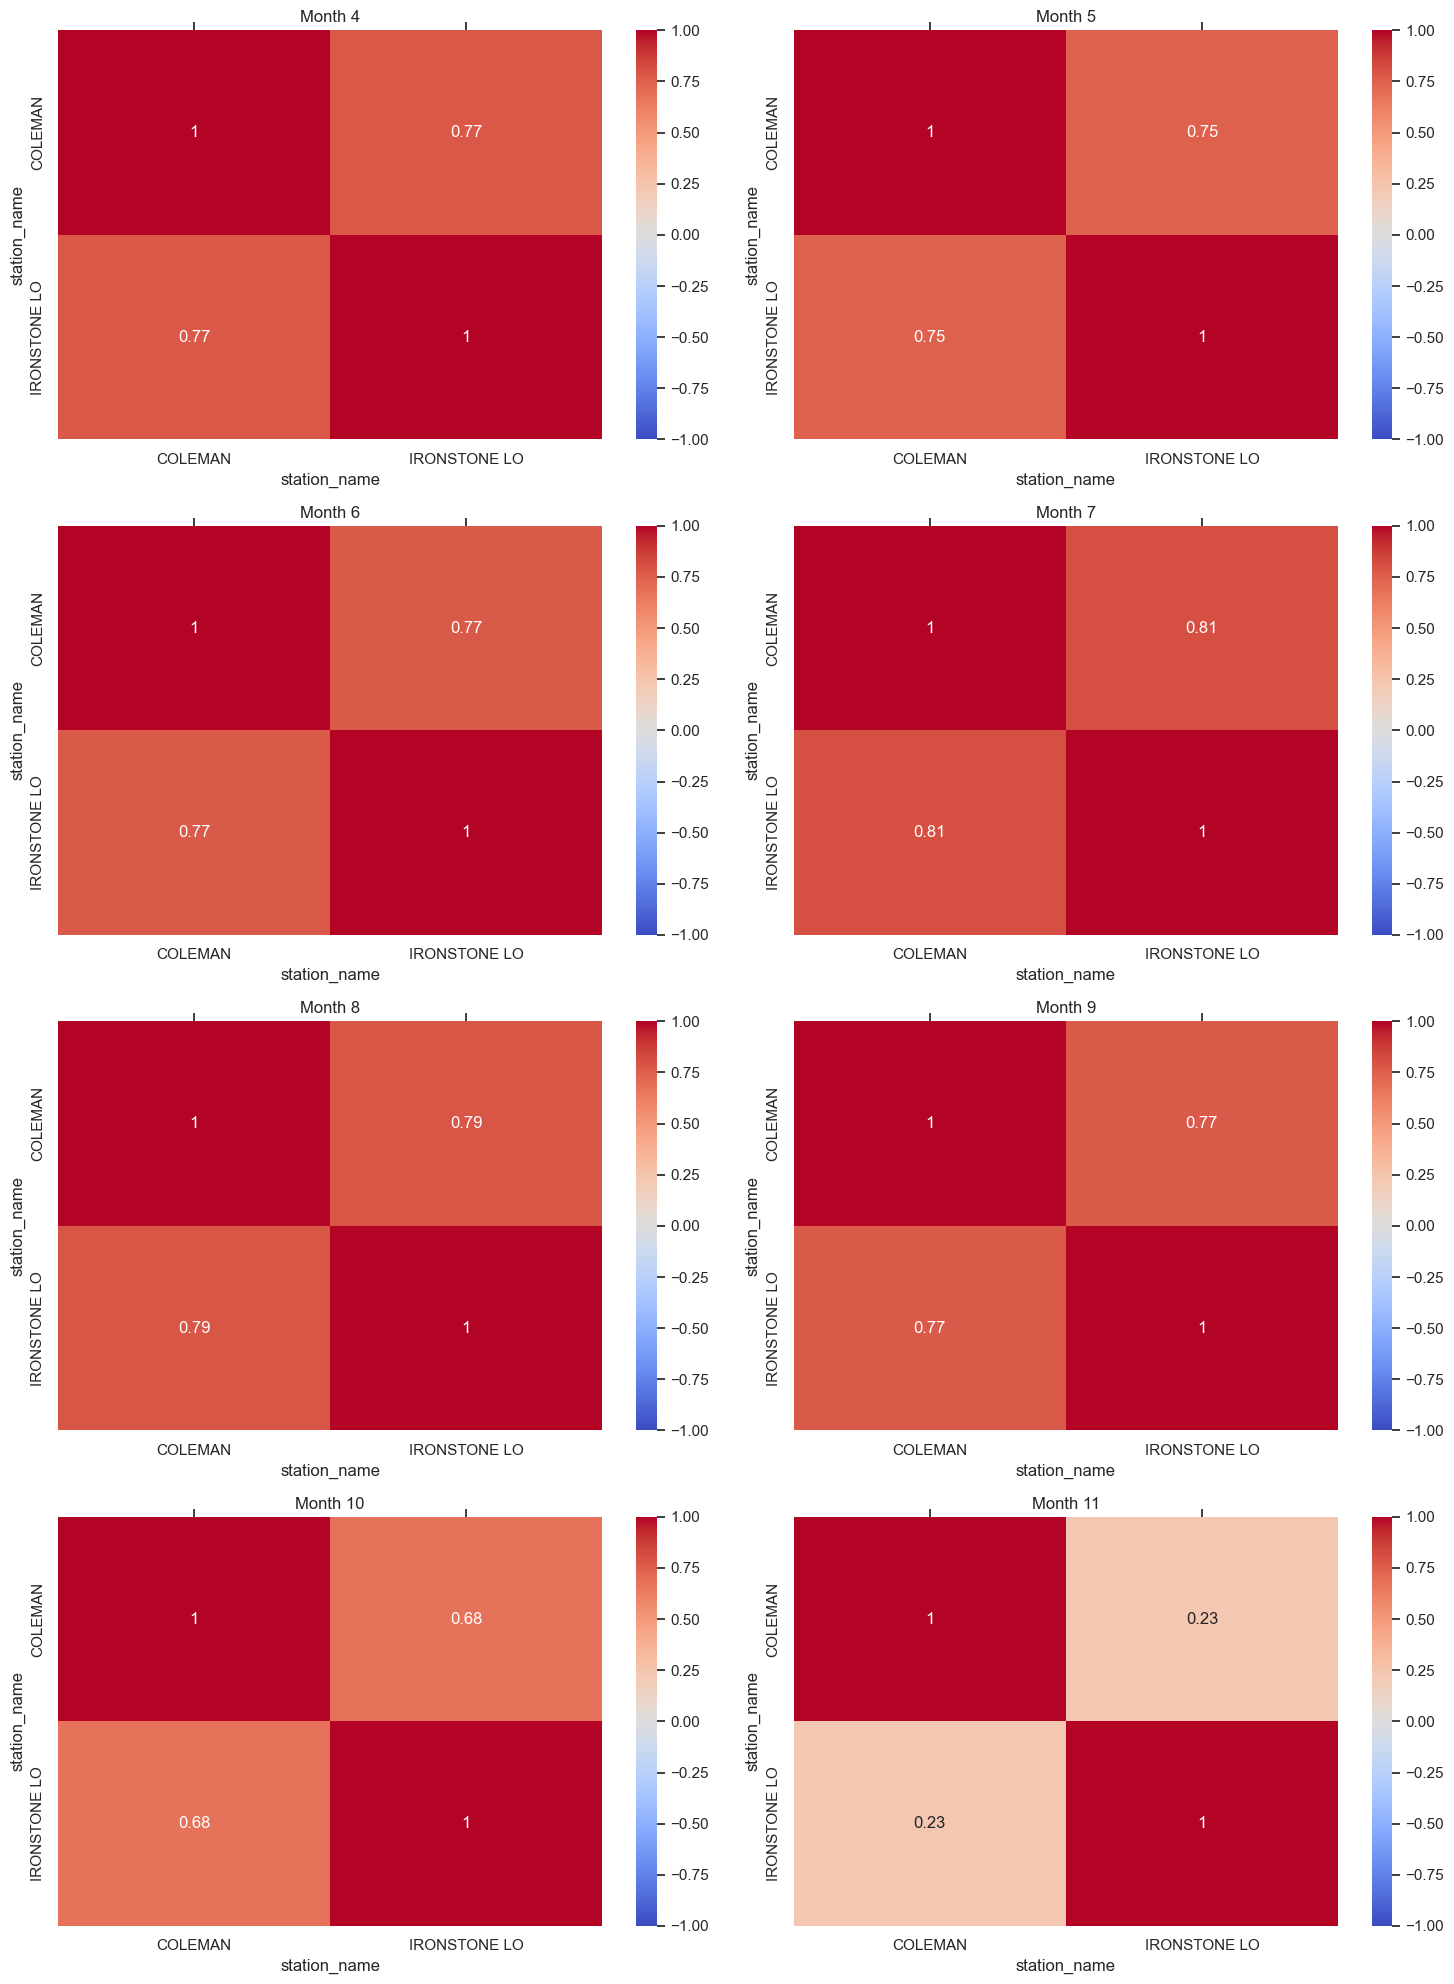

In [277]:
plot_cross_correlation_matrices(c11_monthly_dataframes)

#### Combination 12
combo12 = ['NATAL HARMER RIDGE', 'NATAL KAISER RESOURCES'] 3135 count

In [278]:
summary_combo12_monthly_df = describe_dataframes_to_dataframe(c12_monthly_dataframes)
summary_combo12_monthly_df

count       mean       std   min   25%   50%  \
   station_name                                                           
1  NATAL HARMER RIDGE      248.0   3.056048  5.895319   0.0   0.0   0.0   
   NATAL KAISER RESOURCES  248.0   1.978629  4.489518   0.0   0.0   0.0   
   month                   248.0   1.000000  0.000000   1.0   1.0   1.0   
2  NATAL HARMER RIDGE      255.0   3.364706  5.783183   0.0   0.0   0.5   
   NATAL KAISER RESOURCES  255.0   1.921176  4.969381   0.0   0.0   0.0   
   month                   255.0   2.000000  0.000000   2.0   2.0   2.0   
3  NATAL HARMER RIDGE      279.0   1.951254  3.617005   0.0   0.0   0.0   
   NATAL KAISER RESOURCES  279.0   1.117921  2.652114   0.0   0.0   0.0   
   month                   279.0   3.000000  0.000000   3.0   3.0   3.0   
4  NATAL HARMER RIDGE      240.0   1.745417  4.650287   0.0   0.0   0.0   
   NATAL KAISER RESOURCES  240.0   1.683750  4.353446   0.0   0.0   0.0   
   month                   240.0   4.000000  0.000000   4.0   4.0   4.0   
5  NATAL HARMER RIDGE      248.0   1.756452  3.767488   0.0   0.0   0.0   
   NATAL KAISER RESOURCES  248.0   1.522984  3.332881   0.0   0.0   0.0   
   month                   248.0   5.000000  0.000000   5.0   5.0   5.0   
6  NATAL HARMER RIDGE      240.0   1.400833  2.763237   0.0   0.0   0.0   
   NATAL KAISER RESOURCES  240.0   1.488333  3.659542   0.0   0.0   0.0   
   month                   240.0   6.000000  0.000000   6.0   6.0   6.0   
7  NATAL HARMER RIDGE      253.0   1.927273  4.200247   0.0   0.0   0.0   
   NATAL KAISER RESOURCES  253.0   1.697628  4.236790   0.0   0.0   0.0   
   month                   253.0   7.000000  0.000000   7.0   7.0   7.0   
8  NATAL HARMER RIDGE      279.0   2.200717  5.526073   0.0   0.0   0.0   
   NATAL KAISER RESOURCES  279.0   1.931541  4.582168   0.0   0.0   0.0   
   month                   279.0   8.000000  0.000000   8.0   8.0   8.0   
9  NATAL HARMER RIDGE      265.0   1.367170  3.737274   0.0   0.0   0.0   
   NATAL KAISER RESOURCES  265.0   1.082264  2.858352   0.0   0.0   0.0   
   month                   265.0   9.000000  0.000000   9.0   9.0   9.0   
10 NATAL HARMER RIDGE      279.0   1.633333  4.138110   0.0   0.0   0.0   
   NATAL KAISER RESOURCES  279.0   1.211828  2.960150   0.0   0.0   0.0   
   month                   279.0  10.000000  0.000000  10.0  10.0  10.0   
11 NATAL HARMER RIDGE      270.0   2.828148  5.765539   0.0   0.0   0.0   
   NATAL KAISER RESOURCES  270.0   2.042963  5.178143   0.0   0.0   0.0   
   month                   270.0  11.000000  0.000000  11.0  11.0  11.0   
12 NATAL HARMER RIDGE      279.0   3.809677  6.372164   0.0   0.0   1.3   
   NATAL KAISER RESOURCES  279.0   2.852688  5.760657   0.0   0.0   0.0   
   month                   279.0  12.000000  0.000000  12.0  12.0  12.0   

                              75%   max  
   station_name                          
1  NATAL HARMER RIDGE       3.300  38.4  
   NATAL KAISER RESOURCES   1.850  25.4  
   month                    1.000   1.0  
2  NATAL HARMER RIDGE       3.800  29.5  
   NATAL KAISER RESOURCES   1.000  39.7  
   month                    2.000   2.0  
3  NATAL HARMER RIDGE       2.500  25.4  
   NATAL KAISER RESOURCES   0.800  21.6  
   month                    3.000   3.0  
4  NATAL HARMER RIDGE       1.325  51.6  
   NATAL KAISER RESOURCES   1.300  48.3  
   month                    4.000   4.0  
5  NATAL HARMER RIDGE       1.575  21.6  
   NATAL KAISER RESOURCES   1.300  18.0  
   month                    5.000   5.0  
6  NATAL HARMER RIDGE       1.800  15.5  
   NATAL KAISER RESOURCES   1.000  33.0  
   month                    6.000   6.0  
7  NATAL HARMER RIDGE       1.800  27.4  
   NATAL KAISER RESOURCES   0.800  35.6  
   month                    7.000   7.0  
8  NATAL HARMER RIDGE       1.650  53.3  
   NATAL KAISER RESOURCES   0.900  37.6  
   month                    8.000   8.0  
9  NATAL HARMER RIDGE       0.500  34.8  
   NATAL KAISER RESOURCES   0.500  21.6  


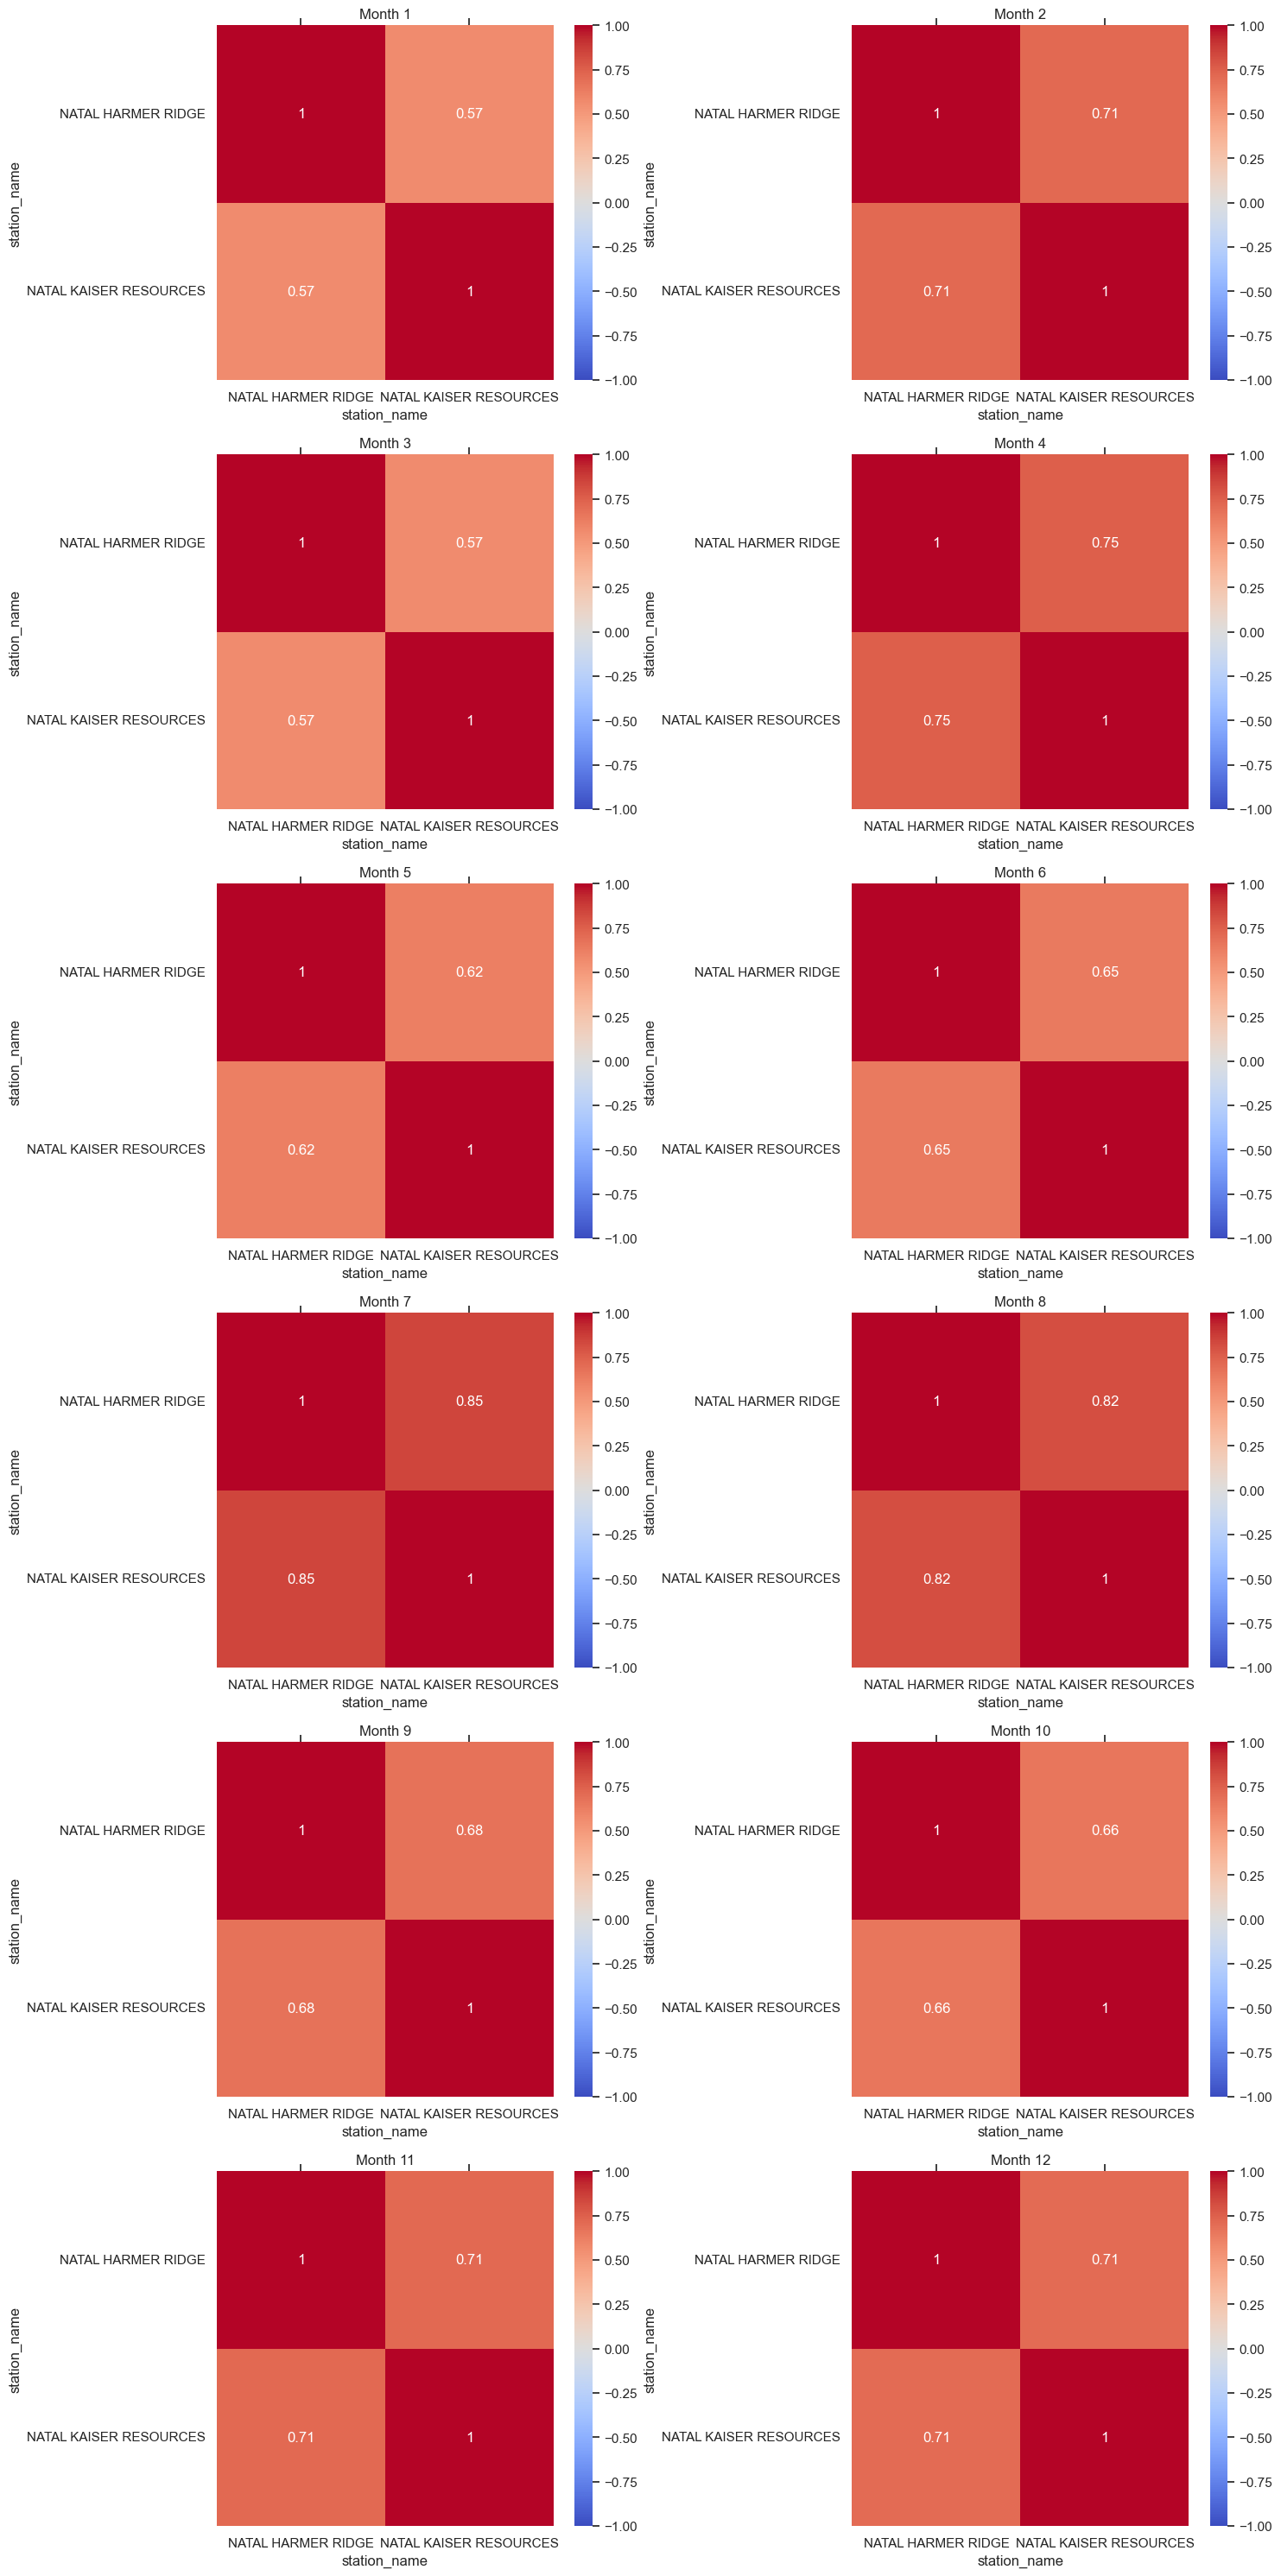

In [279]:
plot_cross_correlation_matrices(c12_monthly_dataframes)

#### Combination 13
combo13 = ['IRONSTONE LO', 'BLAIRMORE HQTS RS'] 3381 count

In [280]:
summary_combo13_monthly_df = describe_dataframes_to_dataframe(c13_monthly_dataframes)
summary_combo13_monthly_df

count       mean       std   min   25%   50%     75%  \
   station_name                                                              
4  BLAIRMORE HQTS RS   16.0   1.906250  4.980692   0.0   0.0   0.0   0.625   
   IRONSTONE LO        16.0   2.293750  4.057334   0.0   0.0   0.0   2.500   
   month               16.0   4.000000  0.000000   4.0   4.0   4.0   4.000   
5  BLAIRMORE HQTS RS  524.0   2.300573  5.457062   0.0   0.0   0.0   1.650   
   IRONSTONE LO       524.0   2.965267  7.305566   0.0   0.0   0.0   2.725   
   month              524.0   5.000000  0.000000   5.0   5.0   5.0   5.000   
6  BLAIRMORE HQTS RS  690.0   2.270290  6.738262   0.0   0.0   0.0   1.800   
   IRONSTONE LO       690.0   2.396087  5.755943   0.0   0.0   0.0   2.000   
   month              690.0   6.000000  0.000000   6.0   6.0   6.0   6.000   
7  BLAIRMORE HQTS RS  789.0   1.882636  5.240858   0.0   0.0   0.0   1.000   
   IRONSTONE LO       789.0   2.042079  5.434070   0.0   0.0   0.0   1.400   
   month              789.0   7.000000  0.000000   7.0   7.0   7.0   7.000   
8  BLAIRMORE HQTS RS  773.0   1.657956  4.866000   0.0   0.0   0.0   0.800   
   IRONSTONE LO       773.0   1.747607  4.492626   0.0   0.0   0.0   1.200   
   month              773.0   8.000000  0.000000   8.0   8.0   8.0   8.000   
9  BLAIRMORE HQTS RS  486.0   1.648971  4.597896   0.0   0.0   0.0   0.800   
   IRONSTONE LO       486.0   1.862551  4.560973   0.0   0.0   0.0   1.200   
   month              486.0   9.000000  0.000000   9.0   9.0   9.0   9.000   
10 BLAIRMORE HQTS RS  103.0   1.002913  2.436506   0.0   0.0   0.0   0.300   
   IRONSTONE LO       103.0   1.683495  4.388289   0.0   0.0   0.0   0.800   
   month              103.0  10.000000  0.000000  10.0  10.0  10.0  10.000   

                       max  
   station_name             
4  BLAIRMORE HQTS RS  19.0  
   IRONSTONE LO       14.4  
   month               4.0  
5  BLAIRMORE HQTS RS  48.0  
   IRONSTONE LO       75.8  
   month               5.0  
6  BLAIRMORE HQTS RS  79.0  
   IRONSTONE LO       63.0  
   month               6.0  
7  BLAIRMORE HQTS RS  58.0  
   IRONSTONE LO       62.4  
   month               7.0  
8  BLAIRMORE HQTS RS  54.4  
   IRONSTONE LO       49.7  
   month               8.0  
9  BLAIRMORE HQTS RS  44.2  
   IRONSTONE LO       34.7  
   month               9.0  
10 BLAIRMORE HQTS RS  11.2  
   IRONSTONE LO       25.4  
   month              10.0

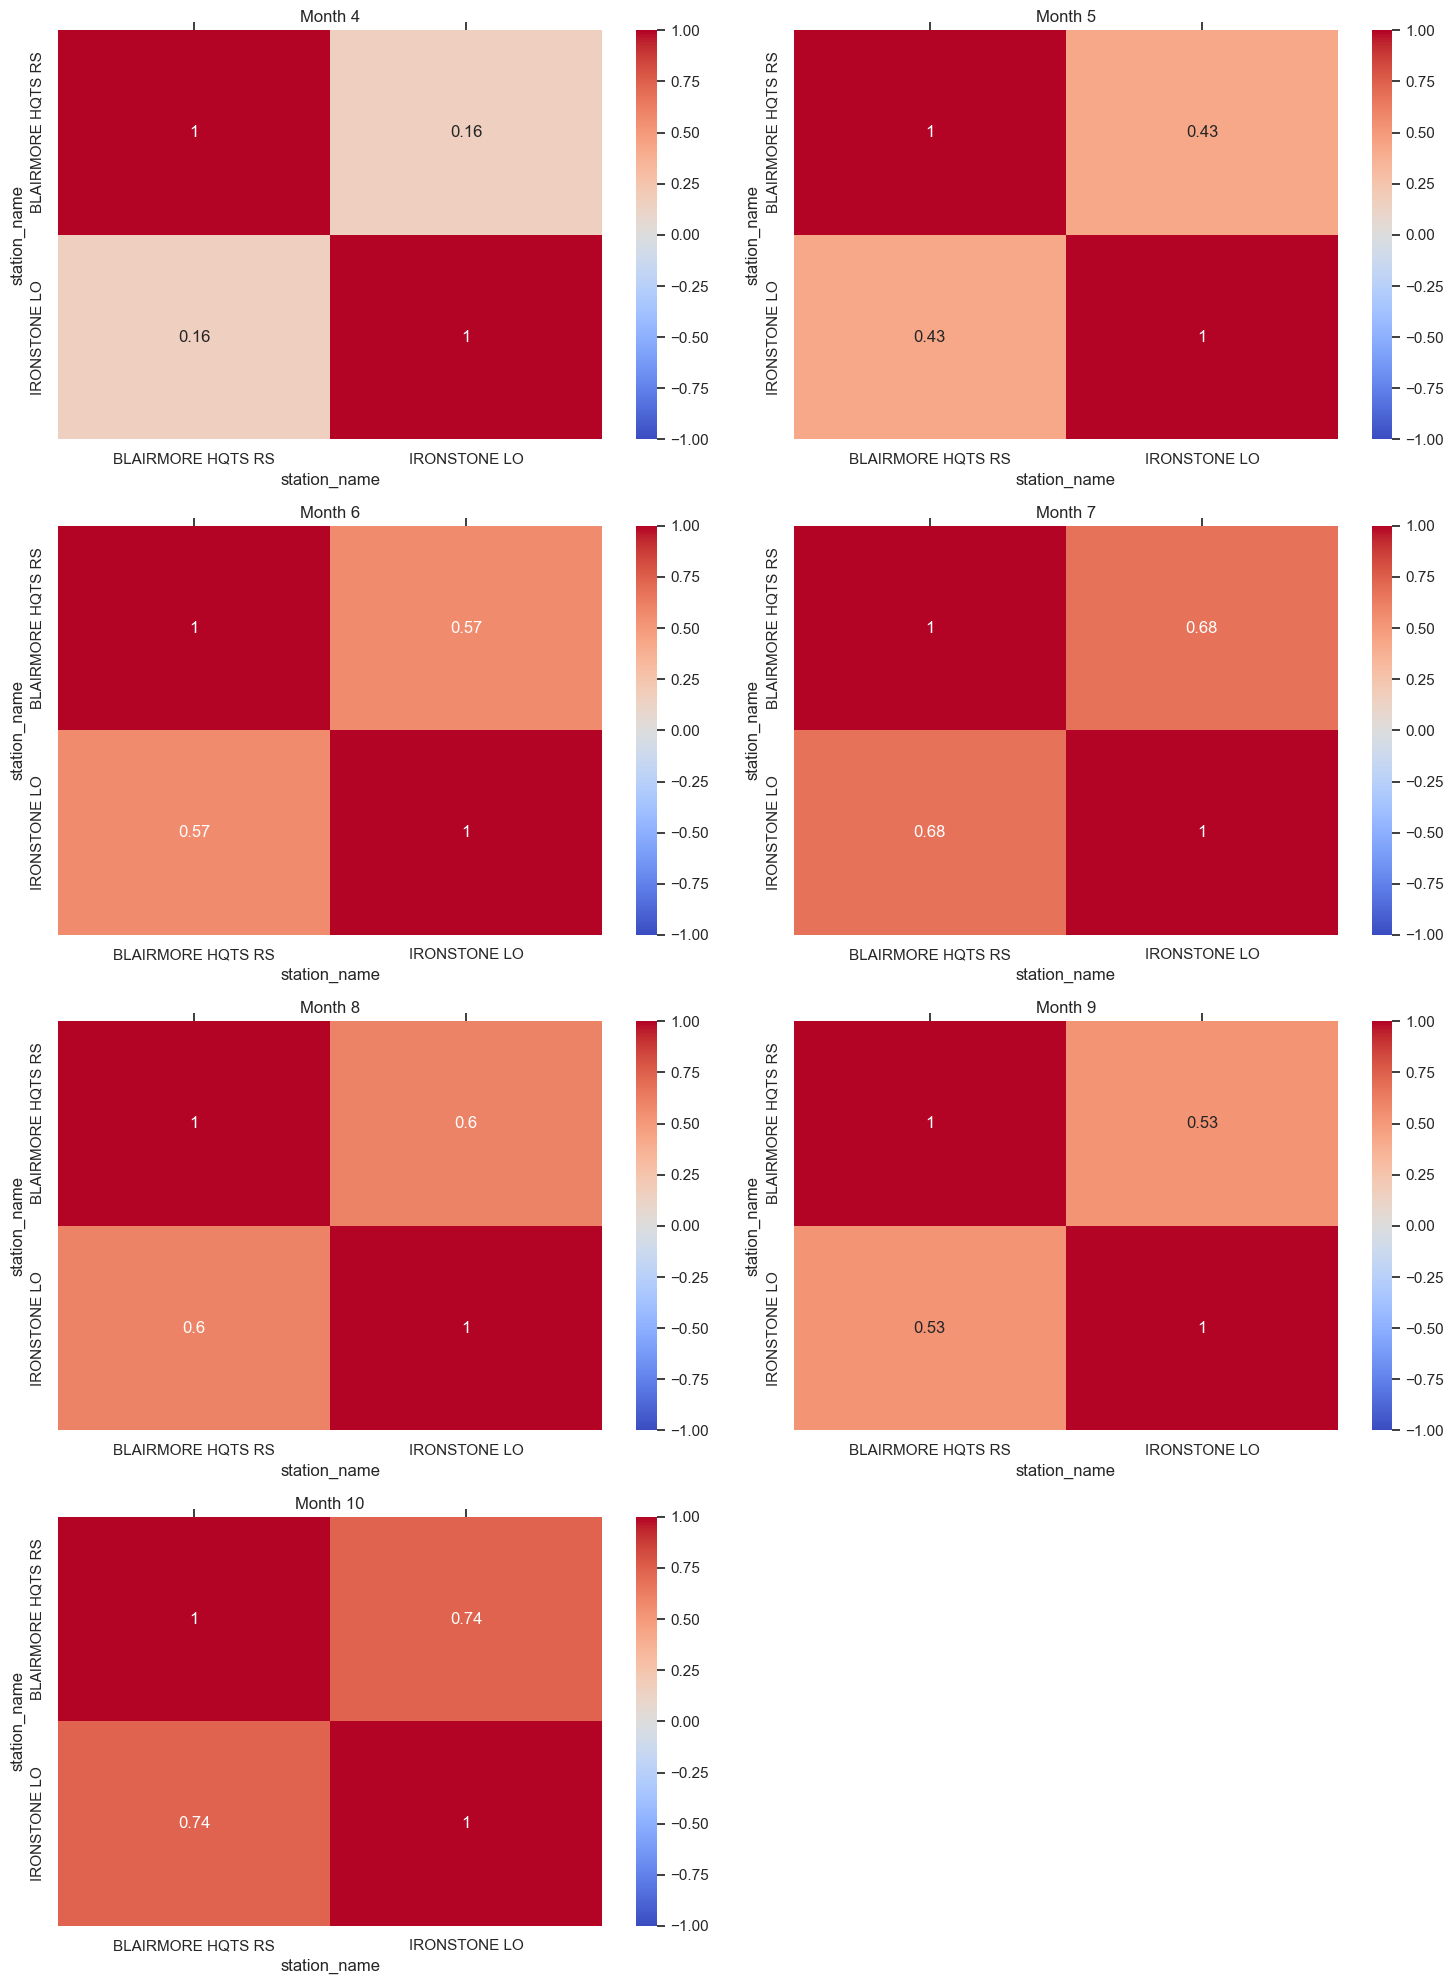

In [281]:
plot_cross_correlation_matrices(c13_monthly_dataframes)

#### Combination 14
combo14 = ['COLEMAN', 'BLAIRMORE HQTS RS', 'CORBIN', 'IRONSTONE LO'] 2114 count

In [294]:
summary_combo14_monthly_df = describe_dataframes_to_dataframe(c14_monthly_dataframes)
summary_combo14_monthly_df

count       mean       std   min   25%    50%     75%  \
   station_name                                                               
4  BLAIRMORE HQTS RS   12.0   0.958333  2.300774   0.0   0.0   0.00   0.625   
   COLEMAN             12.0   1.200000  2.621589   0.0   0.0   0.00   1.050   
   CORBIN              12.0   1.916667  5.501377   0.0   0.0   0.00   0.000   
   IRONSTONE LO        12.0   2.875000  4.543552   0.0   0.0   0.95   2.825   
   month               12.0   4.000000  0.000000   4.0   4.0   4.00   4.000   
5  BLAIRMORE HQTS RS  334.0   2.119162  5.339624   0.0   0.0   0.00   1.500   
   COLEMAN            334.0   2.053293  4.584099   0.0   0.0   0.00   1.950   
   CORBIN             334.0   2.623353  7.511176   0.0   0.0   0.00   1.000   
   IRONSTONE LO       334.0   2.808982  7.894886   0.0   0.0   0.00   2.000   
   month              334.0   5.000000  0.000000   5.0   5.0   5.00   5.000   
6  BLAIRMORE HQTS RS  412.0   1.913592  4.759435   0.0   0.0   0.00   1.825   
   COLEMAN            412.0   2.028398  4.415169   0.0   0.0   0.00   1.825   
   CORBIN             412.0   2.807039  6.345619   0.0   0.0   0.00   2.625   
   IRONSTONE LO       412.0   2.260194  5.540711   0.0   0.0   0.00   1.925   
   month              412.0   6.000000  0.000000   6.0   6.0   6.00   6.000   
7  BLAIRMORE HQTS RS  510.0   2.032353  5.722694   0.0   0.0   0.00   1.200   
   COLEMAN            510.0   1.948431  4.643447   0.0   0.0   0.00   1.575   
   CORBIN             510.0   2.167451  5.791386   0.0   0.0   0.00   1.075   
   IRONSTONE LO       510.0   2.074706  5.650725   0.0   0.0   0.00   1.400   
   month              510.0   7.000000  0.000000   7.0   7.0   7.00   7.000   
8  BLAIRMORE HQTS RS  496.0   1.571169  4.116225   0.0   0.0   0.00   0.800   
   COLEMAN            496.0   1.521371  3.722059   0.0   0.0   0.00   1.200   
   CORBIN             496.0   1.643347  4.103863   0.0   0.0   0.00   0.800   
   IRONSTONE LO       496.0   1.587500  3.794957   0.0   0.0   0.00   1.325   
   month              496.0   8.000000  0.000000   8.0   8.0   8.00   8.000   
9  BLAIRMORE HQTS RS  285.0   1.688772  4.211371   0.0   0.0   0.00   1.000   
   COLEMAN            285.0   1.791228  3.979829   0.0   0.0   0.00   1.300   
   CORBIN             285.0   2.263860  4.998774   0.0   0.0   0.00   2.000   
   IRONSTONE LO       285.0   2.061754  4.733687   0.0   0.0   0.00   1.500   
   month              285.0   9.000000  0.000000   9.0   9.0   9.00   9.000   
10 BLAIRMORE HQTS RS   65.0   0.689231  1.930036   0.0   0.0   0.00   0.200   
   COLEMAN             65.0   0.890769  3.402468   0.0   0.0   0.00   0.000   
   CORBIN              65.0   0.600000  1.513275   0.0   0.0   0.00   0.000   
   IRONSTONE LO        65.0   0.972308  3.003098   0.0   0.0   0.00   0.000   
   month               65.0  10.000000  0.000000  10.0  10.0  10.00  10.000   

                       max  
   station_name             
4  BLAIRMORE HQTS RS   8.0  
   COLEMAN             9.0  
   CORBIN             19.0  
   IRONSTONE LO       14.4  
   month               4.0  
5  BLAIRMORE HQTS RS  48.0  
   COLEMAN            39.4  
   CORBIN             83.0  
   IRONSTONE LO       75.8  
   month               5.0  
6  BLAIRMORE HQTS RS  52.7  
   COLEMAN            35.6  
   CORBIN             65.0  
   IRONSTONE LO       52.0  
   month               6.0  
7  BLAIRMORE HQTS RS  58.0  
   COLEMAN            37.4  
   CORBIN             51.0  
   IRONSTONE LO       62.4  
   month               7.0  
8  BLAIRMORE HQTS RS  34.7  
   COLEMAN            31.0  
   CORBIN             26.0  
   IRONSTONE LO       33.8  
   month               8.0  
9  BLAIRMORE HQTS RS  32.6  
   COLEMAN            29.2  
   CORBIN             30.2  
   IRONSTONE LO       34.7  
   month               9.0  
10 BLAIRMORE HQTS RS   9.4  
   COLEMAN            25.2  
   CORBIN              6.6  
   IRONSTONE LO       21.0  
   month              10.0

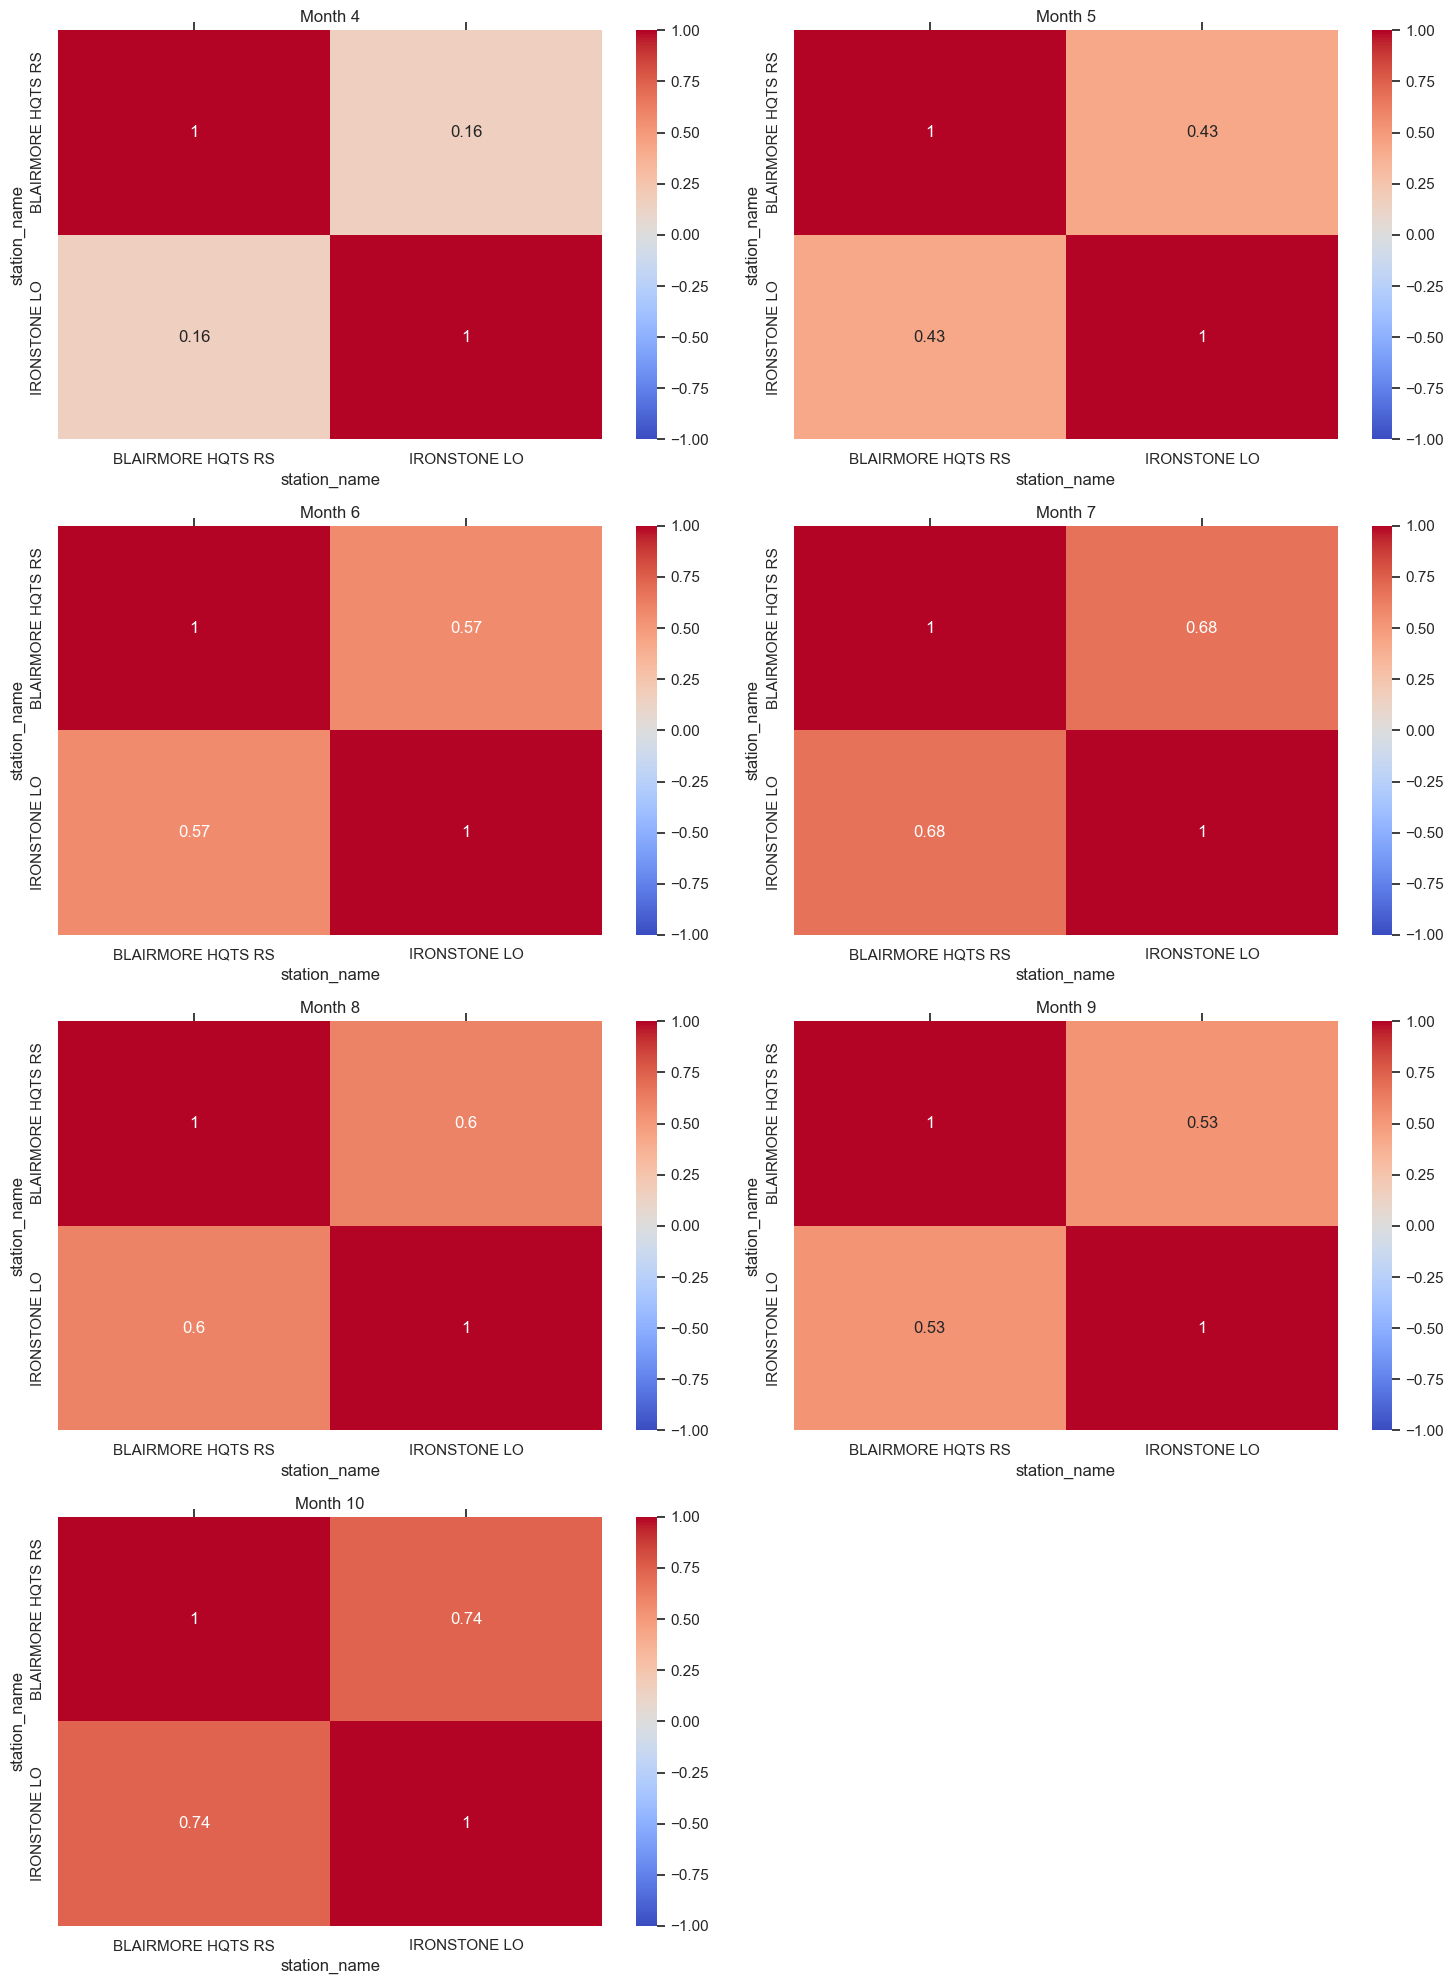

In [295]:
plot_cross_correlation_matrices(c13_monthly_dataframes)

#### Combination 15
combo15 = ['COLEMAN', 'BLAIRMORE HQTS RS', 'CORBIN', 'IRONSTONE LO', 'NATAL HARMER RIDGE'] 1664 count

In [292]:
summary_combo15_monthly_df = describe_dataframes_to_dataframe(c15_monthly_dataframes)
summary_combo15_monthly_df

count       mean       std   min   25%   50%     75%  \
   station_name                                                               
4  BLAIRMORE HQTS RS     5.0   1.900000  3.435113   0.0   0.0   0.5   1.000   
   COLEMAN               5.0   2.400000  3.818377   0.0   0.0   0.6   2.400   
   CORBIN                5.0   0.800000  1.788854   0.0   0.0   0.0   0.000   
   IRONSTONE LO          5.0   4.020000  6.012653   0.0   0.0   1.9   3.800   
   NATAL HARMER RIDGE    5.0   3.200000  6.610598   0.0   0.0   0.0   1.000   
   month                 5.0   4.000000  0.000000   4.0   4.0   4.0   4.000   
5  BLAIRMORE HQTS RS   277.0   2.194224  5.635206   0.0   0.0   0.0   1.500   
   COLEMAN             277.0   2.024910  4.821456   0.0   0.0   0.0   1.300   
   CORBIN              277.0   2.608664  7.916438   0.0   0.0   0.0   1.000   
   IRONSTONE LO        277.0   2.894946  8.519762   0.0   0.0   0.0   1.700   
   NATAL HARMER RIDGE  277.0   1.690975  3.639700   0.0   0.0   0.0   1.800   
   month               277.0   5.000000  0.000000   5.0   5.0   5.0   5.000   
6  BLAIRMORE HQTS RS   322.0   1.703416  4.451184   0.0   0.0   0.0   1.475   
   COLEMAN             322.0   1.950000  4.432261   0.0   0.0   0.0   1.800   
   CORBIN              322.0   2.537888  5.435340   0.0   0.0   0.0   2.600   
   IRONSTONE LO        322.0   2.136025  5.578402   0.0   0.0   0.0   1.700   
   NATAL HARMER RIDGE  322.0   1.660559  3.439096   0.0   0.0   0.0   1.950   
   month               322.0   6.000000  0.000000   6.0   6.0   6.0   6.000   
7  BLAIRMORE HQTS RS   393.0   1.556997  4.653248   0.0   0.0   0.0   1.000   
   COLEMAN             393.0   1.620102  4.171114   0.0   0.0   0.0   1.000   
   CORBIN              393.0   1.763868  5.180652   0.0   0.0   0.0   0.400   
   IRONSTONE LO        393.0   1.679389  5.237912   0.0   0.0   0.0   1.100   
   NATAL HARMER RIDGE  393.0   1.729008  4.390536   0.0   0.0   0.0   0.700   
   month               393.0   7.000000  0.000000   7.0   7.0   7.0   7.000   
8  BLAIRMORE HQTS RS   372.0   1.694624  4.102931   0.0   0.0   0.0   1.025   
   COLEMAN             372.0   1.688441  4.014663   0.0   0.0   0.0   1.525   
   CORBIN              372.0   1.863441  4.397967   0.0   0.0   0.0   1.050   
   IRONSTONE LO        372.0   1.745430  3.997851   0.0   0.0   0.0   1.525   
   NATAL HARMER RIDGE  372.0   1.612634  3.591001   0.0   0.0   0.0   1.900   
   month               372.0   8.000000  0.000000   8.0   8.0   8.0   8.000   
9  BLAIRMORE HQTS RS   230.0   1.612174  4.250243   0.0   0.0   0.0   0.950   
   COLEMAN             230.0   1.667391  3.917961   0.0   0.0   0.0   1.175   
   CORBIN              230.0   2.303478  5.111694   0.0   0.0   0.0   1.900   
   IRONSTONE LO        230.0   2.067826  4.986367   0.0   0.0   0.0   1.275   
   NATAL HARMER RIDGE  230.0   1.656522  3.595670   0.0   0.0   0.0   1.300   
   month               230.0   9.000000  0.000000   9.0   9.0   9.0   9.000   
10 BLAIRMORE HQTS RS    65.0   0.689231  1.930036   0.0   0.0   0.0   0.200   
   COLEMAN              65.0   0.890769  3.402468   0.0   0.0   0.0   0.000   
   CORBIN               65.0   0.600000  1.513275   0.0   0.0   0.0   0.000   
   IRONSTONE LO         65.0   0.972308  3.003098   0.0   0.0   0.0   0.000   
   NATAL HARMER RIDGE   65.0   1.213846  4.504958   0.0   0.0   0.0   0.000   
   month                65.0  10.000000  0.000000  10.0  10.0  10.0  10.000   

                        max  
   station_name              
4  BLAIRMORE HQTS RS    8.0  
   COLEMAN              9.0  
   CORBIN               4.0  
   IRONSTONE LO        14.4  
   NATAL HARMER RIDGE  15.0  
   month                4.0  
5  BLAIRMORE HQTS RS   48.0  
   COLEMAN             39.4  
   CORBIN              83.0  
   IRONSTONE LO        75.8  
   NATAL HARMER RIDGE  25.0  
   month                5.0  
6  BLAIRMORE HQTS RS   52.7  
   COLEMAN             35.6  
   CORBIN              39.2  
   IRONSTONE LO        52.0  
   NAT

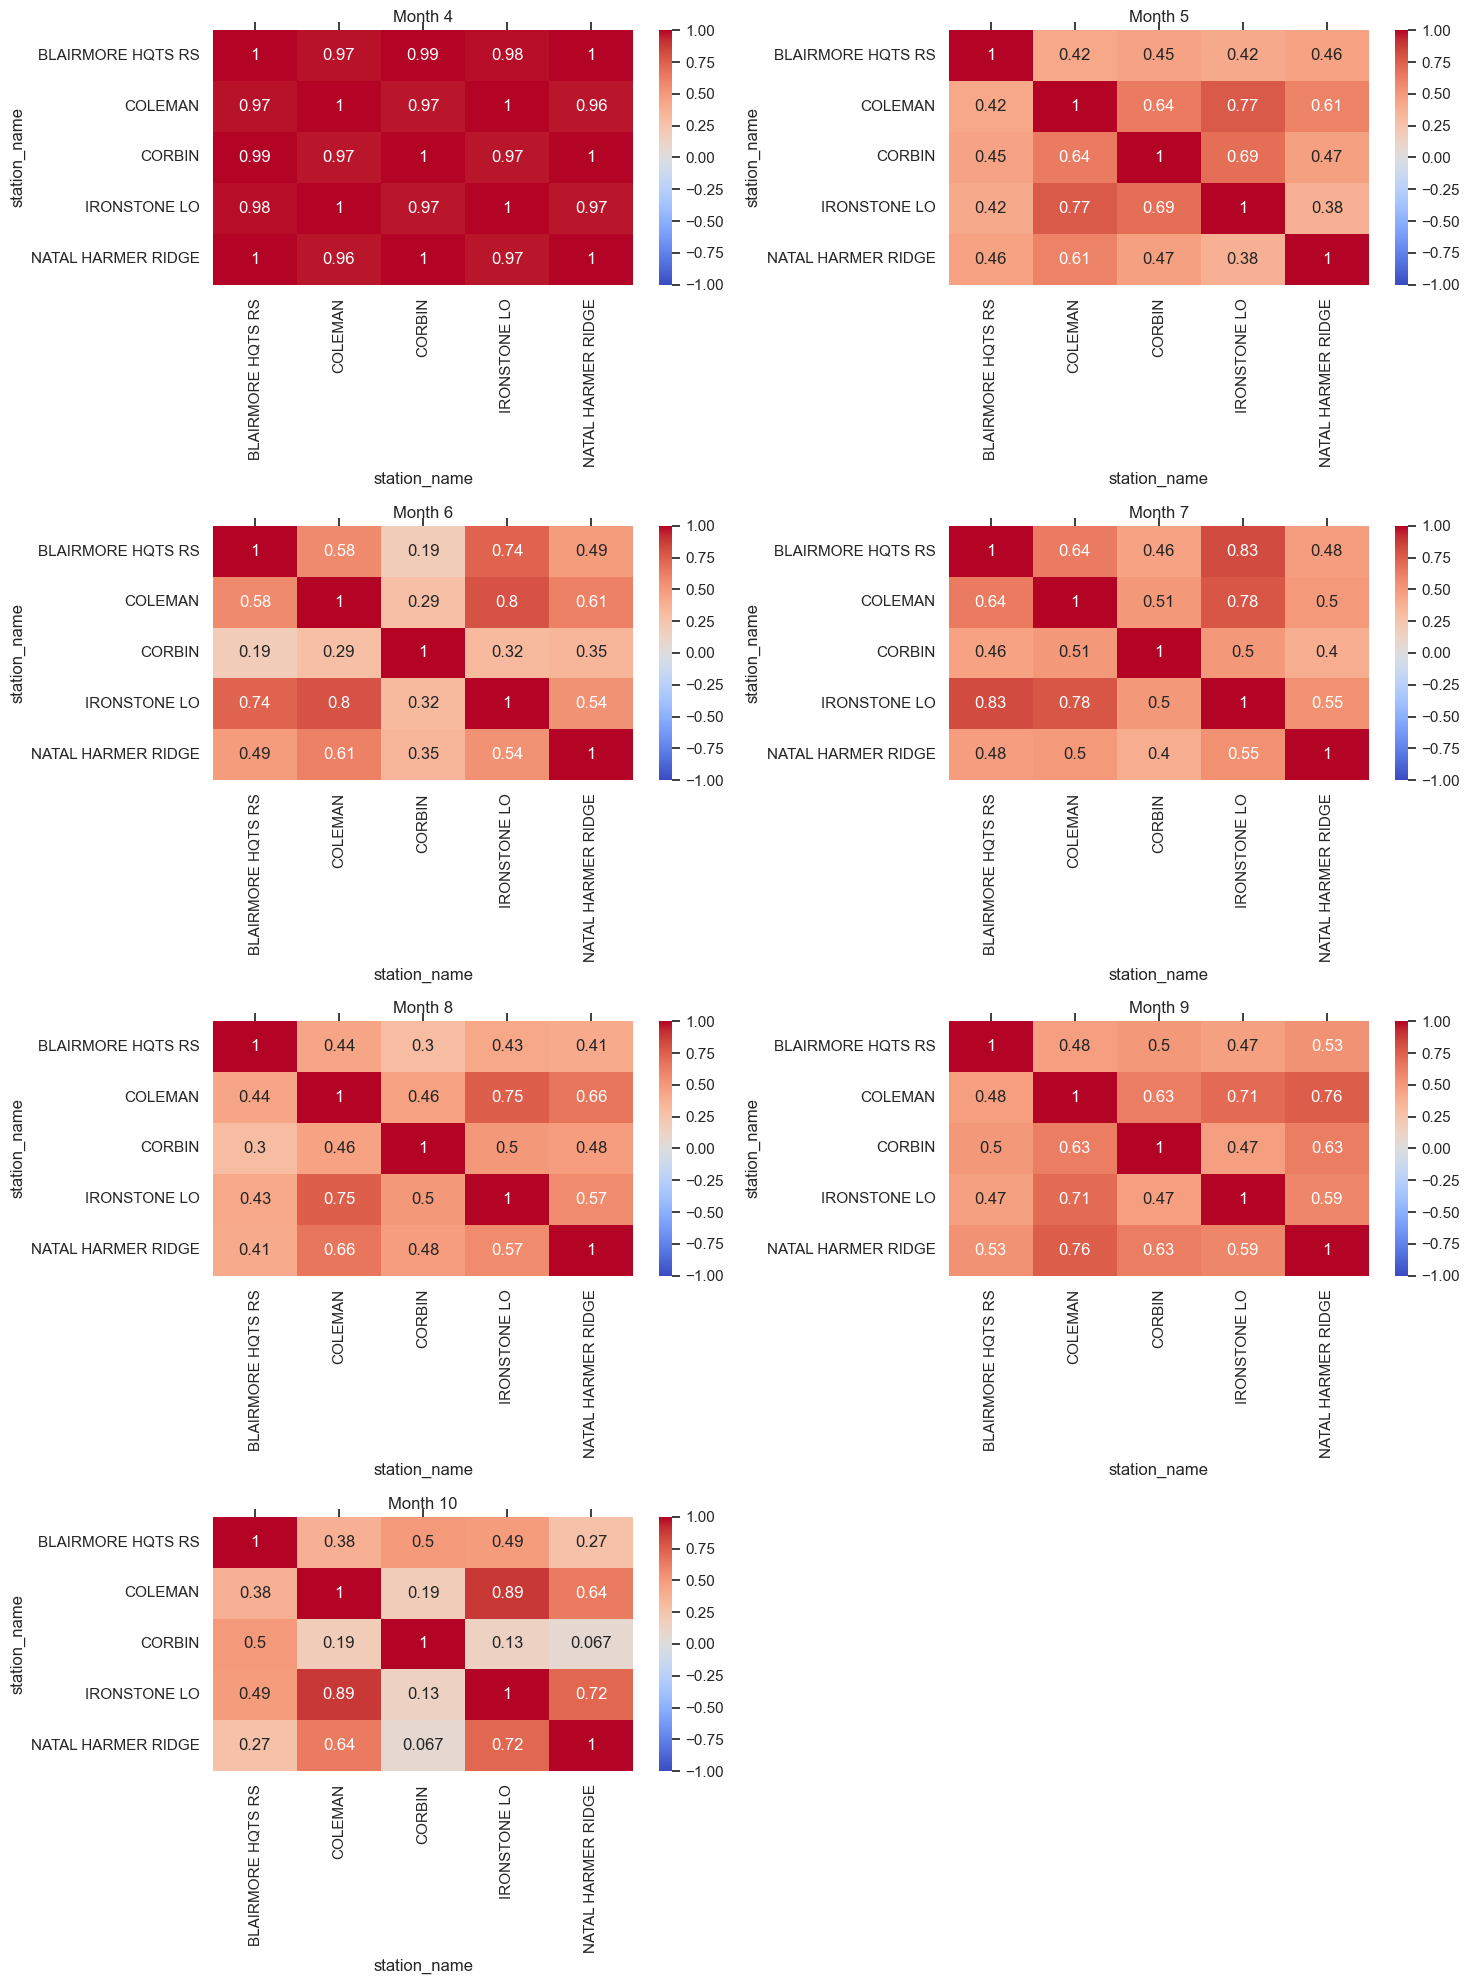

In [293]:
plot_cross_correlation_matrices(c15_monthly_dataframes)

## Cross-Correlation of Hydrometric Stations
2193 count

In [299]:
hydro_combo = ['MICHEL CREEK ABOVE CORBIN CREEK', 'HOSMER CREEK ABOVE DIVERSION', 'ELK RIVER AT FERNIE', 'CROWSNEST RIVER AT FRANK'] 
hydro_combo_df = extract_and_transform_hydro(hydro_combo, hydrometric_df)
hydro_combo_df.head()

Station_name       Date  CROWSNEST RIVER AT FRANK  ELK RIVER AT FERNIE  \
0            1984-04-17                      3.18                 30.8   
1            1984-04-18                      3.49                 34.4   
2            1984-04-19                      3.63                 34.8   
3            1984-04-20                      3.64                 35.1   
4            1984-04-21                      3.48                 35.8   

Station_name  MICHEL CREEK ABOVE CORBIN CREEK  
0                                       0.848  
1                                       0.835  
2                                       0.805  
3                                       0.776  
4                                       0.746

In [300]:
hydro_combo_df.describe(include='all') 


Station_name                           Date  CROWSNEST RIVER AT FRANK  \
count                                  2193               2193.000000   
mean          1989-10-08 20:39:43.584131328                  6.658855   
min                     1984-04-17 00:00:00                  0.946000   
25%                     1986-09-25 00:00:00                  2.620000   
50%                     1989-08-18 00:00:00                  4.590000   
75%                     1992-07-22 00:00:00                  8.570000   
max                     1995-10-10 00:00:00                 92.800000   
std                                     NaN                  6.276872   

Station_name  ELK RIVER AT FERNIE  MICHEL CREEK ABOVE CORBIN CREEK  
count                 2193.000000                      2193.000000  
mean                    68.933333                         1.241036  
min                     12.000000                         0.073000  
25%                     27.100000                         0.221000  
50%                     45.100000                         0.523000  
75%                     89.400000                         1.770000  
max                    642.000000                        12.400000  
std                     61.652926                         1.517714

In [301]:
nan_check = hydro_combo_df.isna().any()
nan_check[nan_check].index.tolist()
hydro_combo_df.isna().sum()

Station_name
Date                               0
CROWSNEST RIVER AT FRANK           0
ELK RIVER AT FERNIE                0
MICHEL CREEK ABOVE CORBIN CREEK    0
dtype: int64

In [302]:
hydro_monthly_dataframes = create_monthly_dataframes_hydro(hydro_combo_df)
summary_hydro_monthly_df = describe_dataframes_to_dataframe(hydro_monthly_dataframes)
summary_hydro_monthly_df

count        mean        std     min  \
   Station_name                                                            
3  CROWSNEST RIVER AT FRANK          40.0    2.789075   1.544834   0.946   
   ELK RIVER AT FERNIE               40.0   20.212500   4.633168  12.000   
   MICHEL CREEK ABOVE CORBIN CREEK   40.0    0.265775   0.178082   0.074   
   month                             40.0    3.000000   0.000000   3.000   
4  CROWSNEST RIVER AT FRANK         344.0    4.065744   2.733207   0.996   
   ELK RIVER AT FERNIE              344.0   37.266279  19.941840  12.300   
   MICHEL CREEK ABOVE CORBIN CREEK  344.0    0.738195   0.681694   0.092   
   month                            344.0    4.000000   0.000000   4.000   
5  CROWSNEST RIVER AT FRANK         372.0   11.461022   7.568534   2.380   
   ELK RIVER AT FERNIE              372.0  114.772581  68.178391  22.400   
   MICHEL CREEK ABOVE CORBIN CREEK  372.0    2.939376   1.616639   0.341   
   month                            372.0    5.000000   0.000000   5.000   
6  CROWSNEST RIVER AT FRANK         341.0   12.286158   8.267823   4.430   
   ELK RIVER AT FERNIE              341.0  141.138416  72.832947  48.800   
   MICHEL CREEK ABOVE CORBIN CREEK  341.0    2.682598   1.710953   0.489   
   month                            341.0    6.000000   0.000000   6.000   
7  CROWSNEST RIVER AT FRANK         342.0    6.794240   4.109393   2.010   
   ELK RIVER AT FERNIE              342.0   70.235965  35.970503  26.300   
   MICHEL CREEK ABOVE CORBIN CREEK  342.0    0.830775   0.682107   0.168   
   month                            342.0    7.000000   0.000000   7.000   
8  CROWSNEST RIVER AT FRANK         342.0    3.542281   1.611419   1.550   
   ELK RIVER AT FERNIE              342.0   35.887427  11.691594  18.300   
   MICHEL CREEK ABOVE CORBIN CREEK  342.0    0.259427   0.148281   0.096   
   month                            342.0    8.000000   0.000000   8.000   
9  CROWSNEST RIVER AT FRANK         330.0    2.733727   1.053312   1.410   
   ELK RIVER AT FERNIE              330.0   25.968788   7.501296  14.800   
   MICHEL CREEK ABOVE CORBIN CREEK  330.0    0.190097   0.100801   0.073   
   month                            330.0    9.000000   0.000000   9.000   
10 CROWSNEST RIVER AT FRANK          82.0    2.468171   0.887416   1.520   
   ELK RIVER AT FERNIE               82.0   22.624390   4.755362  16.000   
   MICHEL CREEK ABOVE CORBIN CREEK   82.0    0.161293   0.062348   0.074   
   month                             82.0   10.000000   0.000000  10.000   

                                         25%       50%        75%      max  
   Station_name                                                             
3  CROWSNEST RIVER AT FRANK          1.47000    2.2150    3.55500    6.730  
   ELK RIVER AT FERNIE              17.02500   20.2000   21.70000   33.200  
   MICHEL CREEK ABOVE CORBIN CREEK   0.14575    0.2175    0.30925    0.844  
   month                             3.00000    3.0000    3.00000    3.000  
4  CROWSNEST RIVER AT FRANK          2.18000    3.2050    4.95750   14.700  
   ELK RIVER AT FERNIE              23.17500   32.5500   43.32500  159.000  
   MICHEL CREEK ABOVE CORBIN CREEK   0.27600    0.5210    0.94500    4.870  
   month                             4.00000    4.0000    4.00000    4.000  
5  CROWSNEST RIVER AT FRANK          6.80000    9.7450   13.60000   52.600  
   ELK RIVER AT FERNIE              68.42500   98.2000  149.00000  428.000  
   MICHEL CREEK ABOVE CORBIN CREEK   1.77750    2.6700    3.91500    9.250  
   month                             5.00000    5.0000    5.00000    5.000  
6  CROWSNEST RIVER AT FRANK          7.59000    9.7600   15.00000   92.800  
   ELK RIVER AT FERNIE              90.00000  119.0000  174.00000  642.000  
   MICHEL CREEK ABOVE CORBIN CREEK   1.44000    2.1600    3.72000   12.400  
   month                             6.00000    6.0000    6.00000    6.000  
7  CROWSNEST RIVER AT FRANK          3.95750    5.6550    8.02000

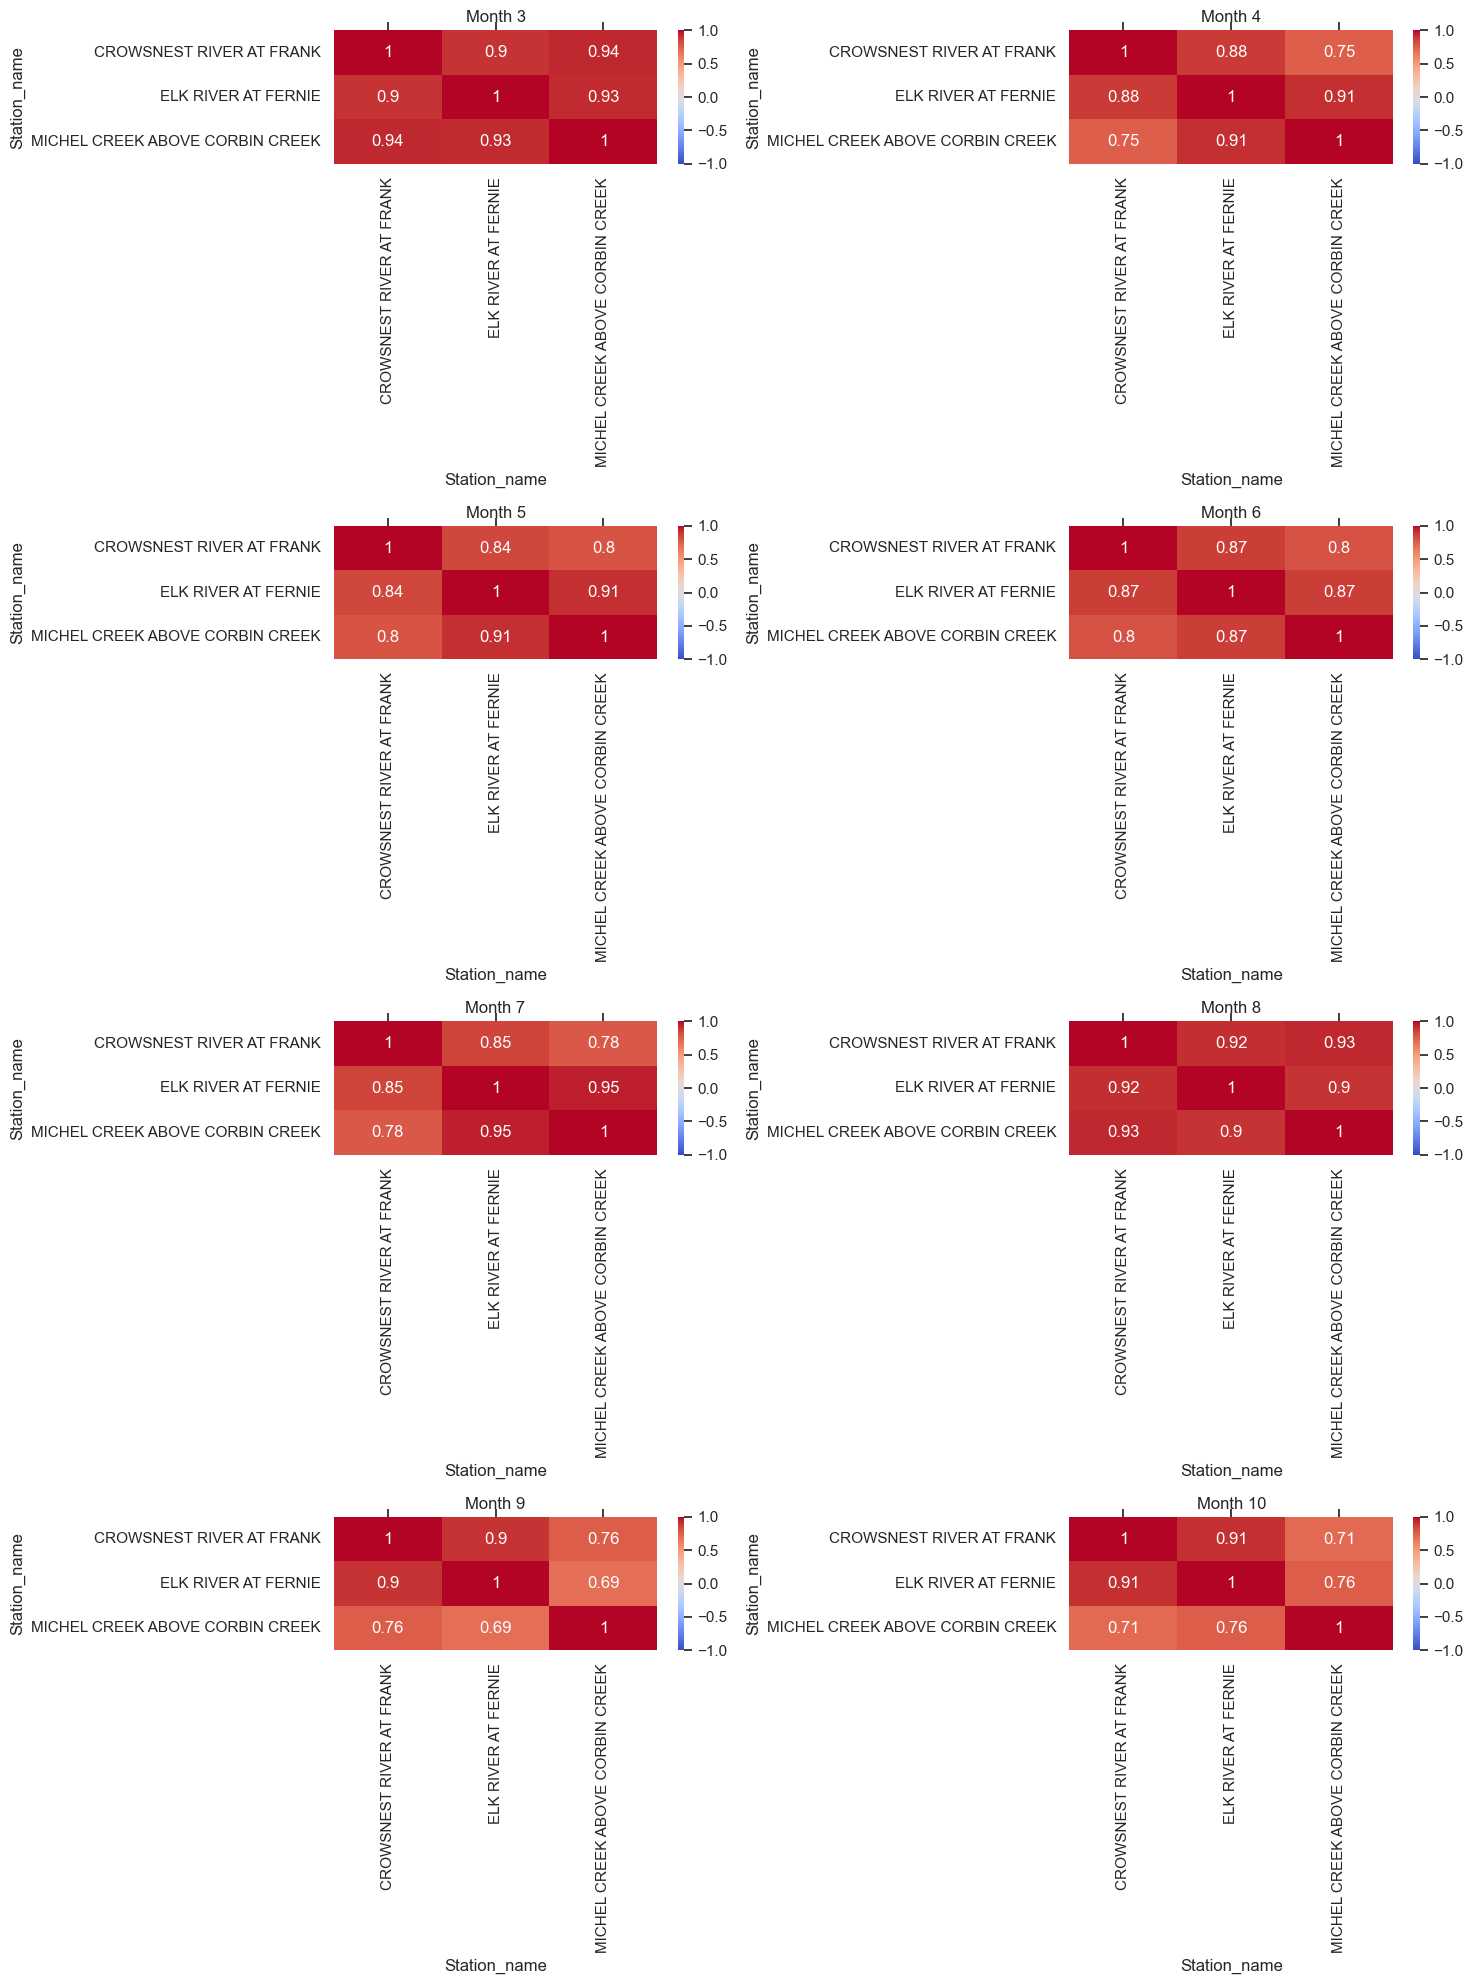

In [303]:
plot_cross_correlation_matrices(hydro_monthly_dataframes)

In [ ]:
# ID	Date	Value	Daily_Discharge_m3/s	Daily_Level_m	Station_name	Years	lat	lon	gross_drainage_area_km2	lat_dd	lon_dd	Year	Month	Max_Peak_Annual_Discharge_m3/s

## Supporting 

In [36]:
weathercan_df.dtypes

station_name      object
station_id         int64
prov              object
lat              float64
lon              float64
elev             float64
date              object
year               int64
month              int64
day                int64
qual              object
cool_deg_days    float64
dir_max_gust     float64
heat_deg_days    float64
max_temp         float64
mean_temp        float64
min_temp         float64
snow_grnd        float64
spd_max_gust     float64
total_precip     float64
total_rain       float64
total_snow       float64
dtype: object

In [37]:
weathercan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252964 entries, 0 to 252963
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   station_name   252964 non-null  object 
 1   station_id     252964 non-null  int64  
 2   prov           252964 non-null  object 
 3   lat            252964 non-null  float64
 4   lon            252964 non-null  float64
 5   elev           252964 non-null  float64
 6   date           252964 non-null  object 
 7   year           252964 non-null  int64  
 8   month          252964 non-null  int64  
 9   day            252964 non-null  int64  
 10  qual           4376 non-null    object 
 11  cool_deg_days  87904 non-null   float64
 12  dir_max_gust   9675 non-null    float64
 13  heat_deg_days  87904 non-null   float64
 14  max_temp       88589 non-null   float64
 15  mean_temp      87904 non-null   float64
 16  min_temp       88441 non-null   float64
 17  snow_grnd      30206 non-null

In [49]:
CROWSNEST_CREEK_df = station_dfs['CROWSNEST_CREEK_df']

# Group by 'year' and 'month' and calculate the mean precipitation
CROWSNEST_CREEK_df['monthly_mean_precip'] = (
    CROWSNEST_CREEK_df.groupby(['year', 'month'])['total_precip']
    .transform('mean'))

CROWSNEST_CREEK_df

station_name  station_id prov    lat     lon    elev       date  \
0     CROWSNEST CREEK       10690   AB  49.61 -114.68  1387.0 1998-01-01   
1     CROWSNEST CREEK       10690   AB  49.61 -114.68  1387.0 1998-01-02   
2     CROWSNEST CREEK       10690   AB  49.61 -114.68  1387.0 1998-01-03   
3     CROWSNEST CREEK       10690   AB  49.61 -114.68  1387.0 1998-01-04   
4     CROWSNEST CREEK       10690   AB  49.61 -114.68  1387.0 1998-01-05   
...               ...         ...  ...    ...     ...     ...        ...   
9500  CROWSNEST CREEK       10690   AB  49.61 -114.68  1387.0 2024-01-05   
9501  CROWSNEST CREEK       10690   AB  49.61 -114.68  1387.0 2024-01-06   
9502  CROWSNEST CREEK       10690   AB  49.61 -114.68  1387.0 2024-01-07   
9503  CROWSNEST CREEK       10690   AB  49.61 -114.68  1387.0 2024-01-08   
9504  CROWSNEST CREEK       10690   AB  49.61 -114.68  1387.0 2024-01-09   

      year  month  day  ... heat_deg_days  max_temp  mean_temp  min_temp  \
0     1998      1    1  ...           NaN       NaN        NaN       NaN   
1     1998      1    2  ...           NaN       NaN        NaN       NaN   
2     1998      1    3  ...           NaN       NaN        NaN       NaN   
3     1998      1    4  ...           NaN       NaN        NaN       NaN   
4     1998      1    5  ...           NaN       NaN        NaN       NaN   
...    ...    ...  ...  ...           ...       ...        ...       ...   
9500  2024      1    5  ...           NaN       NaN        NaN       NaN   
9501  2024      1    6  ...           NaN       NaN        NaN       NaN   
9502  2024      1    7  ...           NaN       NaN        NaN       NaN   
9503  2024      1    8  ...           NaN       NaN        NaN       NaN   
9504  2024      1    9  ...           NaN       NaN        NaN       NaN   

      snow_grnd  spd_max_gust  total_precip  total_rain  total_snow  \
0           NaN           NaN           NaN         NaN         NaN   
1           NaN           NaN           NaN         NaN         NaN   
2           NaN           NaN           NaN         NaN         NaN   
3           NaN           NaN           NaN         NaN         NaN   
4           NaN           NaN           NaN         NaN         NaN   
...         ...           ...           ...         ...         ...   
9500        NaN           NaN           NaN         NaN         NaN   
9501        NaN           NaN           NaN         NaN         NaN   
9502        NaN           NaN           NaN         NaN         NaN   
9503        NaN           NaN           NaN         NaN         NaN   
9504        NaN           NaN           NaN         NaN         NaN   

      monthly_mean_precip  
0                     NaN  
1                     NaN  
2                     NaN  
3                     NaN  
4                     NaN  
...                   ...  
9500                  NaN  
9501                  NaN  
9502                  NaN  
9503                  NaN  
9504                  NaN  

[9505 rows x 23 columns]

In [47]:
distinct_values_crowsnest_year = CROWSNEST_CREEK_df['year'].unique()
distinct_values_crowsnest_year

array([1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020, 2021, 2022, 2023, 2024], dtype=int64)

In [52]:
distinct_values_crowsnest_year_counts = CROWSNEST_CREEK_df['year'].value_counts()
distinct_values_crowsnest_year_counts

year
2000    366
2004    366
2020    366
2008    366
2016    366
2012    366
1998    365
2014    365
2023    365
2022    365
2021    365
2019    365
2018    365
2017    365
2015    365
2011    365
2013    365
1999    365
2010    365
2009    365
2007    365
2006    365
2005    365
2003    365
2002    365
2001    365
2024      9
Name: count, dtype: int64

In [53]:
distinct_values_crowsnest = CROWSNEST_CREEK_df['monthly_mean_precip'].unique()
distinct_values_crowsnest

array([       nan, 0.67419355, 2.12333333, 2.1516129 , 1.13225806,
       1.04642857, 0.91290323, 1.24333333, 2.08064516, 3.10666667,
       1.21612903, 2.17741935, 0.92666667, 2.88709677, 2.65666667,
       0.55806452, 1.83548387, 0.91724138, 1.25483871, 0.88666667,
       2.26451613, 3.52666667, 0.77096774, 0.8516129 , 0.96774194,
       0.40645161, 0.93214286, 1.26129032, 2.28965517, 0.59677419,
       3.62      , 0.32258065, 0.15806452, 0.4       , 1.44193548,
       1.06      , 1.03225806, 2.4       , 2.05714286, 1.38709677,
       1.33      , 3.2483871 , 3.80666667, 0.56129032, 1.17741935,
       2.45333333, 0.74333333, 1.39677419, 1.32903226, 0.30357143,
       2.59032258, 2.39666667, 1.78064516, 1.82      , 0.12258065,
       0.11612903, 0.78      , 2.3483871 , 2.05333333, 0.11724138,
       1.0483871 , 0.78333333, 1.85483871, 3.24666667, 1.71935484,
       3.19354839, 2.18333333, 1.51612903, 1.14      , 1.2       ,
       2.01290323, 1.25      , 1.18709677, 0.99666667, 1.71612

In [56]:
# Check if monthly mean calc match
monthly_mean_precip_counts = (
    CROWSNEST_CREEK_df.groupby(['year', 'monthly_mean_precip'])
    .size()
    .reset_index(name='counts')
)
monthly_mean_precip_counts

year  monthly_mean_precip  counts
0   1998             0.674194      31
1   1998             2.123333      30
2   1998             2.151613      31
3   1999             0.558065      31
4   1999             0.912903      31
..   ...                  ...     ...
78  2005             2.830769      30
79  2005             3.106452      31
80  2005             5.123333      30
81  2005             7.830000      30
82  2007             0.433333      30

[83 rows x 3 columns]

In [65]:
# Check if monthly mean calc match
# Filter the DataFrame for the station 'CROWSNEST_CREEK'
CROWSNEST_CREEK_df_from_wc = weathercan_df[weathercan_df['station_name'] == 'CROWSNEST CREEK']

# Group by 'year' and 'monthly_mean_precip' and get value counts
monthly_mean_precip_counts_wc = (
    CROWSNEST_CREEK_df_from_wc.groupby(['year', 'monthly_mean_precip'])
    .size()
    .reset_index(name='counts')
)

# Print or use the resulting DataFrame as needed
monthly_mean_precip_counts_wc

year  monthly_mean_precip  counts
0   1998             0.674194      31
1   1998             2.123333      30
2   1998             2.151613      31
3   1999             0.558065      31
4   1999             0.912903      31
..   ...                  ...     ...
78  2005             2.830769      30
79  2005             3.106452      31
80  2005             5.123333      30
81  2005             7.830000      30
82  2007             0.433333      30

[83 rows x 3 columns]